- Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV  
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from math import sqrt                                       
import operator                                   
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (20,15)           
plt.rcParams['font.size'] = 15




 - Load datasets

In [2]:
train_data = pd.read_csv('Train.csv', encoding = 'utf-8')
test_data = pd.read_csv('Test.csv', encoding = 'utf-8')

data_def = pd.read_csv('VariableDefinitions.csv', encoding = 'utf-8')
riders =  pd.read_csv('Riders.csv', encoding = 'utf-8')

Building intuition around dataset features


In [3]:
data_def.columns

Index(['Order No', 'Unique number identifying the order'], dtype='object')

In [4]:
train_data.head(5)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


# Exploratory Data Analysis

In [5]:
#additional features about riders

riders.columns

Index(['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings'], dtype='object')

Merging train and test for joint analysis

In [6]:
#creating unique identifiers for train & test

train_data['identifier'] =  1

test_data['identifier'] = 0

test_data['Time from Pickup to Arrival'] = 200000

In [7]:
#merge train and test for joint analysis

all_t = pd.concat([train_data, test_data], axis = 0, sort = True)

In [8]:
all_t.reset_index(inplace = True, drop =True)

In [9]:
all_t.shape

(28269, 30)

Merging rider columns to dataset

In [10]:
all_t = all_t.merge(riders, how = 'inner',\
                    on = ['Rider Id'])




In [11]:
#checking unique values 
all_t.nunique()

Arrival at Destination - Day of Month           31
Arrival at Destination - Time                15725
Arrival at Destination - Weekday (Mo = 1)        7
Arrival at Pickup - Day of Month                31
Arrival at Pickup - Time                     19189
Arrival at Pickup - Weekday (Mo = 1)             7
Confirmation - Day of Month                     31
Confirmation - Time                          19181
Confirmation - Weekday (Mo = 1)                  7
Destination Lat                               6246
Destination Long                              6203
Distance (KM)                                   46
Order No                                     28269
Personal or Business                             2
Pickup - Day of Month                           31
Pickup - Time                                19161
Pickup - Weekday (Mo = 1)                        7
Pickup Lat                                    4393
Pickup Long                                   4377
Placement - Day of Month       

We have just one transport Vehicle type which `Bike`.

In [12]:
all_t['Vehicle Type'].unique()

array(['Bike'], dtype=object)

We have two classes of client `Business` and `Personal`.

In [13]:
all_t['Personal or Business'].unique()

array(['Business', 'Personal'], dtype=object)

From placement to delivery, is it same day?

In [14]:
#Correlation with days


corr_check = ['Arrival at Destination - Day of Month', 'Arrival at Pickup - Day of Month', 'Confirmation - Day of Month', \
             'Pickup - Day of Month']

all_t[corr_check].apply(lambda x : x.corr(all_t['Placement - Day of Month']))


Arrival at Destination - Day of Month    0.999998
Arrival at Pickup - Day of Month         0.999999
Confirmation - Day of Month              0.999999
Pickup - Day of Month                    0.999999
dtype: float64

Drop redundant day columns, leave only pickup later

In [15]:
all_t.columns

Index(['Arrival at Destination - Day of Month',
       'Arrival at Destination - Time',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'identifier',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings'],
      dtype='object')

# Overview of verifying how the Target Time from Pickup to arrival was computed - Difference from overall pickup and destination time

In [16]:
#creating copy of train set for analysis and manipulation

all_t_cop = all_t[all_t['identifier'] == 1].copy()


#function to create full date that account for overall arrival and pickup date
def create_dates(x, y, z):
    
    return '2019' + '-' + '08' + '-' + str(int(x)) + '-' + '0' + str(int(y)) + ' ' + str(z)

In [17]:
# applying function that created the combined dates and times from individual columns

all_t_cop['pickup time overall'] = np.vectorize(create_dates)(all_t_cop['Pickup - Day of Month'],\
                                                   all_t_cop['Pickup - Weekday (Mo = 1)'],
                                                   all_t_cop['Pickup - Time'])

all_t_cop['arrival dest time overall'] = np.vectorize(create_dates)(all_t_cop['Arrival at Destination - Day of Month'], \
                                               all_t_cop['Arrival at Destination - Weekday (Mo = 1)'],  
                                               all_t_cop['Arrival at Destination - Time'] )

In [18]:
pd.to_datetime(all_t_cop['pickup time overall'])

0       2019-08-09 10:27:30
1       2019-08-18 16:13:37
2       2019-08-31 13:33:08
3       2019-08-02 07:38:46
4       2019-08-22 10:59:40
5       2019-08-29 12:25:10
6       2019-08-02 09:37:47
7       2019-08-19 16:39:21
8       2019-08-28 15:32:26
9       2019-08-14 15:28:59
10      2019-08-16 17:10:35
11      2019-08-28 16:35:55
12      2019-08-08 10:51:39
13      2019-08-02 12:53:33
14      2019-08-14 14:11:23
15      2019-08-04 11:25:46
16      2019-08-09 17:40:14
17      2019-08-24 12:56:37
18      2019-08-02 08:16:28
19      2019-08-25 13:46:10
20      2019-08-14 14:06:25
21      2019-08-15 11:58:03
22      2019-08-17 15:35:56
30      2019-08-12 11:44:09
31      2019-08-22 11:15:38
32      2019-08-15 12:06:28
33      2019-08-14 12:59:33
34      2019-08-10 12:01:17
35      2019-08-04 15:28:33
36      2019-08-20 15:42:17
                ...        
28186   2019-08-02 13:50:40
28189   2019-08-11 09:27:36
28190   2019-08-07 16:15:10
28191   2019-08-28 14:37:49
28192   2019-08-28 1

In [19]:
# #converting to date format for date arithmetic 

all_t_cop['pickup time overall'] = pd.to_datetime(all_t_cop['pickup time overall'])

all_t_cop['arrival dest time overall'] = pd.to_datetime(all_t_cop['arrival dest time overall'])



In [20]:
# #time difference in total seconds

# #time difference between pick up and destination arrival time

all_t_cop['timedelta'] = all_t_cop['arrival dest time overall'] - all_t_cop['pickup time overall']

all_t_cop['timedelta'] = all_t_cop['timedelta'].dt.total_seconds()

In [21]:
# #checking difference betwen timedelta (Pickup to Arrival difference) and given Target Time from Pickup to Arrival

all_t_cop['confirmed'] = all_t_cop['timedelta'] - all_t_cop['Time from Pickup to Arrival']

In [22]:
# #confirmed difference in seconds

all_t_cop['confirmed'] = all_t_cop['confirmed'].round(3)

if (all_t_cop['confirmed'].unique() == 0.0):
    
    print('Confirmed difference of 0 seconds' )
    
    print('Time from Pickup to Arrival is same as diffence between arrival time and pickup time overall' )

Confirmed difference of 0 seconds
Time from Pickup to Arrival is same as diffence between arrival time and pickup time overall


# Analysis of nulls and duplicates

In [23]:
#investigating NAN values

all_t.isnull().sum(axis = 0)

Arrival at Destination - Day of Month         7068
Arrival at Destination - Time                 7068
Arrival at Destination - Weekday (Mo = 1)     7068
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Time                         0
Arrival at Pickup - Weekday (Mo = 1)             0
Confirmation - Day of Month                      0
Confirmation - Time                              0
Confirmation - Weekday (Mo = 1)                  0
Destination Lat                                  0
Destination Long                                 0
Distance (KM)                                    0
Order No                                         0
Personal or Business                             0
Pickup - Day of Month                            0
Pickup - Time                                    0
Pickup - Weekday (Mo = 1)                        0
Pickup Lat                                       0
Pickup Long                                      0
Placement - Day of Month       

In [24]:
#percentage of missing to overall dataset(train)

print(len(all_t.loc[all_t['Precipitation in millimeters'].isna()])/len(all_t))

len(all_t.loc[all_t['Temperature'].isna()])/len(all_t)


0.9734337967384767


0.20527786621387387

In [25]:
# #Removing precipitation feature

all_t = all_t.drop(['Precipitation in millimeters'], axis = 1)


In [26]:
#using median of temperatures to fill temperature NANs

all_t['Temperature'] = all_t['Temperature'].fillna(all_t['Temperature'].median())

In [27]:
all_t.isnull().sum(axis = 0)   

Arrival at Destination - Day of Month        7068
Arrival at Destination - Time                7068
Arrival at Destination - Weekday (Mo = 1)    7068
Arrival at Pickup - Day of Month                0
Arrival at Pickup - Time                        0
Arrival at Pickup - Weekday (Mo = 1)            0
Confirmation - Day of Month                     0
Confirmation - Time                             0
Confirmation - Weekday (Mo = 1)                 0
Destination Lat                                 0
Destination Long                                0
Distance (KM)                                   0
Order No                                        0
Personal or Business                            0
Pickup - Day of Month                           0
Pickup - Time                                   0
Pickup - Weekday (Mo = 1)                       0
Pickup Lat                                      0
Pickup Long                                     0
Placement - Day of Month                        0


In [28]:
#Investigating duplicate values

print(all_t.duplicated(keep = 'first').sum())


0


# Correlation Analysis & Observations

In [29]:
# Correlation
corr = all_t.corr()
corr.style.background_gradient(cmap = 'Spectral')

C:\Users\Damola\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Weekday (Mo = 1),Platform Type,Temperature,Time from Pickup to Arrival,identifier,No_Of_Orders,Age,Average_Rating,No_of_Ratings
Arrival at Destination - Day of Month,1,0.0261233,1,0.0261233,1,0.0261233,0.00754959,0.0020726,-0.00758657,1,0.0261233,-0.00492294,-0.00544797,0.999998,0.0261323,0.0127704,0.012316,-0.014701,nan,0.0080994,-0.000114324,0.0127956,-0.00171221
Arrival at Destination - Weekday (Mo = 1),0.0261233,1,0.0261233,1,0.0261233,1,-0.00425082,-0.000899644,0.0035743,0.0261233,1,-0.00088275,0.0110362,0.0261222,0.999952,-0.058005,0.0278343,0.00974442,nan,-0.0242052,-0.0155138,-0.0068034,-0.0257685
Arrival at Pickup - Day of Month,1,0.0261233,1,0.023891,1,0.023891,0.00388795,0.00304896,-0.00197861,1,0.023891,-0.00508726,0.000764451,0.999999,0.0238978,0.0139626,0.00788054,-0.00170357,0.0015769,0.00621546,-0.00333992,0.011818,-0.00176757
Arrival at Pickup - Weekday (Mo = 1),0.0261233,1,0.023891,1,0.023891,1,0.00270561,-0.000933848,0.0093881,0.023891,1,0.000240969,0.0105035,0.0238903,0.999964,-0.058612,0.0270463,0.0027398,-0.00265615,-0.0249131,-0.0162515,-0.00694462,-0.0250913
Confirmation - Day of Month,1,0.0261233,1,0.023891,1,0.023891,0.00388795,0.00304896,-0.00197861,1,0.023891,-0.00508726,0.000764451,0.999999,0.0238978,0.0139626,0.00788054,-0.00170357,0.0015769,0.00621546,-0.00333992,0.011818,-0.00176757
Confirmation - Weekday (Mo = 1),0.0261233,1,0.023891,1,0.023891,1,0.00270561,-0.000933848,0.0093881,0.023891,1,0.000240969,0.0105035,0.0238903,0.999964,-0.058612,0.0270463,0.0027398,-0.00265615,-0.0249131,-0.0162515,-0.00694462,-0.0250913
Destination Lat,0.00754959,-0.00425082,0.00388795,0.00270561,0.00388795,0.00270561,1,0.0442183,-0.076642,0.00388795,0.00270561,0.10925,0.0165409,0.00388152,0.00266956,0.00655777,0.0103975,0.00353359,-0.00406913,-0.0075824,0.00689613,0.0209719,0.00833074
Destination Long,0.0020726,-0.000899644,0.00304896,-0.000933848,0.00304896,-0.000933848,0.0442183,1,0.145198,0.00304896,-0.000933848,0.0514812,0.0818428,0.00305229,-0.000915103,0.0424249,0.0172537,0.00164747,-0.00103664,-0.0115068,-0.0183313,0.00197,-0.0034074
Distance (KM),-0.00758657,0.0035743,-0.00197861,0.0093881,-0.00197861,0.0093881,-0.076642,0.145198,1,-0.00197861,0.0093881,-0.128315,0.180356,-0.00197755,0.00939372,0.00598095,-0.00446676,0.00137504,0.00364813,0.0383359,0.0326379,-0.00319227,0.0515642
Pickup - Day of Month,1,0.0261233,1,0.023891,1,0.023891,0.00388795,0.00304896,-0.00197861,1,0.023891,-0.00508726,0.000764451,0.999999,0.0238978,0.0139626,0.00788054,-0.00170357,0.0015769,0.00621546,-0.00333992,0.011818,-0.00176757


- Correlation observations

All weekdays and Day of Month of Pickup and Arrival are perfectly correlated, hence same day delivery

Destination latitude is most correlated with pickup, although weak correlation

Distance has relatively high correlation with time from pickup to arrival

Temperature has a slight correlation with platform type, understand this trend further

Most of our present features have weak correlation with Target Time, look for ways to augment data further

No of orders has high correlation with No of Ratings, hence drivers have higher no of times rated with higher number of orders delivered. This makes sense. Can we create new feature to show no of ratings / no of orders or can we just discard number of ratings and retain no of orders

No of orders correlated with Age. Showing how new the driver is. This makes sense


# Feature Engineering & Dataset enrichment

1 Can we extract features showing how fast rider was that day from Confirmation to Pickup in general, which might be related to

how fast from pickup to delivery (These could abstractly indicate things like general traffic that day, rider speed in events before delivery):

Extract Time diff between arrival pickup and pickup

Extract Time diff between Order placement and pickup

Extract Time diff between Driver confirmation and arrival pick up



In [30]:
#double check pickup, confirmation, arrival pickup and pickup days are all same. 

#Correlation isn't exactly 1 from correlation analysis, possible outliers present


all_t[all_t['Confirmation - Day of Month'] != all_t['Placement - Day of Month']]\
[['Confirmation - Day of Month', 'Placement - Day of Month', 'Arrival at Pickup - Day of Month', 'Pickup - Day of Month', 
 'Time from Pickup to Arrival']]


,Confirmation - Day of Month,Placement - Day of Month,Arrival at Pickup - Day of Month,Pickup - Day of Month,Time from Pickup to Arrival
6765,13,11,13,13,1854
22082,18,17,18,18,2640


Only placement looks out of place, replacing with unified Day of month

In [31]:
all_t['Placement - Day of Month'].loc[6765] = all_t['Confirmation - Day of Month'].loc[6765]

all_t['Placement - Day of Month'].loc[22082] = all_t['Confirmation - Day of Month'].loc[22082]

all_t['Placement - Weekday (Mo = 1)'].loc[6765] = all_t['Confirmation - Weekday (Mo = 1)'].loc[6765]

all_t['Placement - Weekday (Mo = 1)'].loc[22082] = all_t['Confirmation - Weekday (Mo = 1)'].loc[22082]


C:\Users\Damola\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
#verify it's fixed

all_t[all_t['Confirmation - Day of Month'] != all_t['Placement - Day of Month']]

,Arrival at Destination - Day of Month,Arrival at Destination - Time,Arrival at Destination - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,...,Rider Id,Temperature,Time from Pickup to Arrival,User Id,Vehicle Type,identifier,No_Of_Orders,Age,Average_Rating,No_of_Ratings


In [33]:
#creating copy of train set for analysis and manipulation

#Extracting times and days for confirmation, placement, pickup, arrival pickup

#NOTE I DON'T DIRECTLY MANIPULATE WORKING DATASET ALL_T, CREATED A COPY ALL_T_COP EARLIER FOR DATA MANIPULATION


all_t_cop = all_t.copy()

In [34]:

focus = ['confirmed time overall', 'arrival pick time overall', 'pick time overall', 'placement time overall']

times = [['Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time'],\
         ['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time'],\
        ['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time'], \
        ['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Placement - Time']]

for f in focus:
    
    stop_count = 0

    for t in times:
        
        if (stop_count == 0):
            
            x, y, z = t
    
    
            #using previous function created that was used to verify how Time to Pickup to Arrival was calculated above
        
            all_t_cop[f] = np.vectorize(create_dates)(all_t_cop[x],\
                                                   all_t_cop[y],
                                                   all_t_cop[z])
        
            
            
            #converting to date format for date arithmetic 

            all_t_cop[f] = pd.to_datetime(all_t_cop[f])
            
        
            #stop count ensures the inside loop is only run once for the specific time
            
            stop_count += 1
            
            #we only need 1 from each times list for each point in focus and since it's sequential
            #deleted each one when it's been used
            
            times.remove(t)
            
        else:
            
            pass

    
    






In [35]:
#confirming times list is empty due to removal after each use
times

[]

In [36]:
#time difference between various time events from confirmation to pickup

def create_deltas(df, copy):
    
    
#time difference between confirmation and order placement

    df['confirmation_placement_delta'] = copy['confirmed time overall'] - copy['placement time overall']
    
    
#time difference between arrival pickup and placement
    df['arrival pickup_confirmation delta'] = copy['arrival pick time overall'] - copy['confirmed time overall']


#time difference between pickup and arrival pick up 

    df['pickup_arrival pickup_delta'] = copy['pick time overall'] - copy['arrival pick time overall']
    

#hour of day of pickup

    df['pick time hour'] = copy['pick time overall'].dt.hour
    
#hour of day of pickup

    df['arrival pick time hour'] = copy['arrival pick time overall'].dt.hour    

    
    return df

In [37]:
all_t = create_deltas(all_t, all_t_cop)

In [38]:
#converting time difference to seconds


deltas = ['confirmation_placement_delta', 'arrival pickup_confirmation delta', 'pickup_arrival pickup_delta']

for delta in deltas:
    
    all_t[delta] = all_t[delta].dt.total_seconds().round(3)
    
    
    

In [39]:

#converting hour to strings

all_t['arrival pick time hour'] = all_t['arrival pick time hour'].astype(str)

all_t['pick time hour'] = all_t['pick time hour'].astype(str)

In [40]:
#removing redundant columns after feature extraction

all_t = all_t.drop(['Arrival at Destination - Day of Month',
       'Arrival at Destination - Time',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)',\
       'Pickup - Time'], axis = 1)

2 Since Distance is most correlated with Time Variable, can we augment with more geographic location based features between Pickup and Destination Latitude & Longitude Difference

In [41]:
all_t['latitude difference'] =  abs(all_t['Destination Lat'] - all_t['Pickup Lat'])

all_t['longitude difference'] = abs(all_t['Destination Long'] - all_t['Pickup Long'])

#combined latitude and longitude difference in a right angle trianle, obtaining hypotenuse here

all_t['long lat diff'] = np.sqrt((all_t['latitude difference'] ** 2) + (all_t['longitude difference']  ** 2))

In [42]:
all_t.describe()

,Destination Lat,Destination Long,Distance (KM),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Platform Type,Temperature,Time from Pickup to Arrival,...,No_Of_Orders,Age,Average_Rating,No_of_Ratings,confirmation_placement_delta,arrival pickup_confirmation delta,pickup_arrival pickup_delta,latitude difference,longitude difference,long lat diff
count,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,...,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,28269.000000,2.826900e+04,28269.000000,28269.000000
mean,-1.282499,36.811247,9.494641,15.645831,3.242633,-1.281613,36.811235,2.752167,23.285313,51172.955570,...,1698.576497,988.157522,13.882684,341.504333,432.906045,776.165517,741.933921,3.356910e-02,0.042207,0.058477
std,0.034677,0.044420,5.645726,8.793188,1.570642,0.030392,0.037595,0.624872,3.218317,85937.186386,...,1588.125645,653.147480,0.899127,404.672506,1021.544776,687.124250,757.296378,2.774518e-02,0.036491,0.039877
min,-1.430298,36.606594,1.000000,1.000000,1.000000,-1.438302,36.653621,1.000000,11.200000,1.000000,...,2.000000,96.000000,0.000000,0.000000,-4664.000000,0.000000,60.000000,2.000000e-07,0.000005,0.000797
25%,-1.301043,36.785934,5.000000,8.000000,2.000000,-1.300921,36.784605,3.000000,21.400000,1047.000000,...,557.000000,494.000000,13.600000,61.000000,27.000000,307.000000,263.000000,1.204880e-02,0.014580,0.028328
50%,-1.284001,36.807974,8.000000,15.000000,3.000000,-1.279395,36.807040,3.000000,23.400000,1768.000000,...,1212.000000,872.000000,14.000000,158.000000,69.000000,614.000000,492.000000,2.784120e-02,0.031851,0.049321
75%,-1.261199,36.828916,13.000000,23.000000,5.000000,-1.257147,36.829721,3.000000,25.300000,200000.000000,...,2311.000000,1236.000000,14.300000,495.000000,292.000000,1044.000000,926.000000,4.625660e-02,0.061301,0.079207
max,-1.030225,37.018958,49.000000,31.000000,7.000000,-1.147170,36.991046,4.000000,32.100000,200000.000000,...,9756.000000,3764.000000,15.200000,2298.000000,14540.000000,6970.000000,5985.000000,2.706956e-01,0.277473,0.329909


Check corelation with target variable

In [43]:
#picking only train set for correlation check

#We will only be using train set for any analysis versus Time

all_t_train = all_t[all_t['identifier'] == 1]

In [44]:
#Extracting numeric columns for correlation check

#dict for holding numeric columns

scatter =[]

for column in all_t.columns:
    
    if all_t[column].dtype != 'object':
        
        scatter.append(column)
        

In [45]:
#Correlation with target variable

features_correlation = all_t_train[scatter].apply(lambda x : x.corr(all_t_train['Time from Pickup to Arrival']))

features_correlation_abs = features_correlation.apply(lambda x : abs(x))
           
    
feature_correlation_sorted = sorted(features_correlation_abs.items(), key = operator.itemgetter(1), reverse = True)


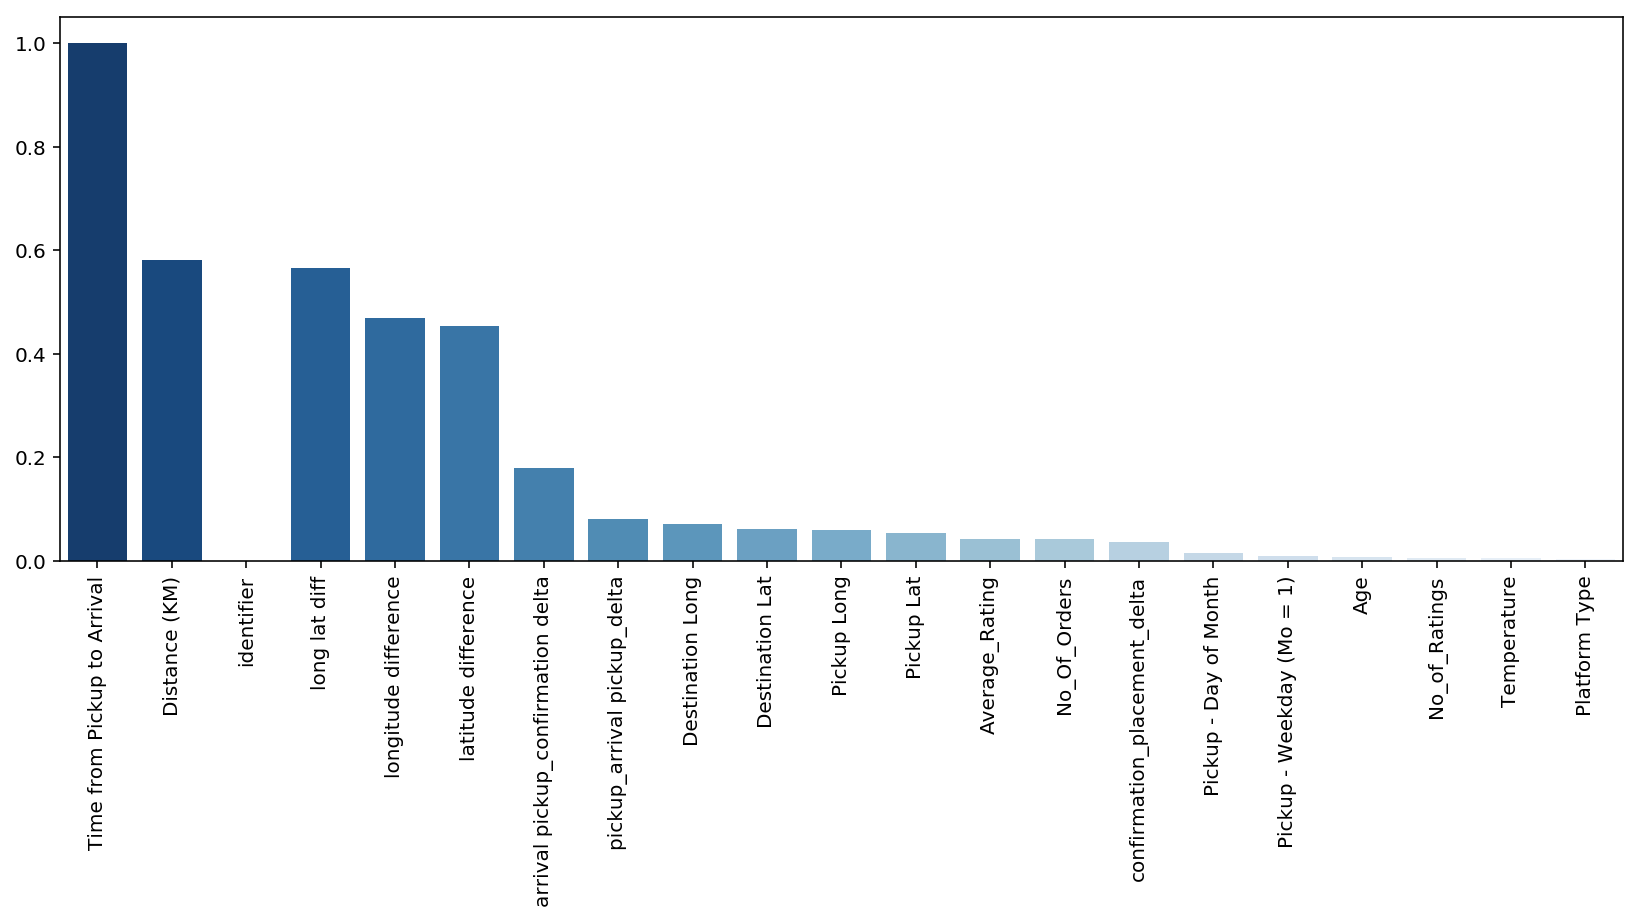

In [46]:
#BARPLOT SHOWING FEATURE CORRELATION SCORES

features_corr = dict(feature_correlation_sorted)

plt.figure(figsize = (14, 5))
sb.barplot(x = list(features_corr.keys()), y = list(features_corr.values()), palette = "Blues_r")
plt.xticks (rotation = 90)
plt.show()

Good judgement, improved correlation strength with engineered features

# Obtain Speed for Rides



In [47]:
all_t['speed'] = all_t['Distance (KM)']  / all_t['Time from Pickup to Arrival']

In [48]:
#converting km/s to km/hr for easier analysis

all_t['speed'] = all_t['speed'] * 3600

In [49]:
all_t['speed'].head()

0    19.328859
1    24.948025
2     8.260038
3    21.701273
4    15.730337
Name: speed, dtype: float64

In [50]:
all_t[all_t['speed'] == all_t['speed'].max()][['Time from Pickup to Arrival', 'Distance (KM)']]

,Time from Pickup to Arrival,Distance (KM)
22326,1,17


In [51]:
all_t['speed'].max()

61200.0

Certain outlier values where distance is large and Time is minimal, affecting Speed distribution

# Categorical Features EDA

In [52]:
all_t.dtypes

Destination Lat                      float64
Destination Long                     float64
Distance (KM)                          int64
Order No                              object
Personal or Business                  object
Pickup - Day of Month                  int64
Pickup - Weekday (Mo = 1)              int64
Pickup Lat                           float64
Pickup Long                          float64
Platform Type                          int64
Rider Id                              object
Temperature                          float64
Time from Pickup to Arrival            int64
User Id                               object
Vehicle Type                          object
identifier                             int64
No_Of_Orders                           int64
Age                                    int64
Average_Rating                       float64
No_of_Ratings                          int64
confirmation_placement_delta         float64
arrival pickup_confirmation delta    float64
pickup_arr

In [53]:
# #delete vehicle type (constant feature)

all_t = all_t.drop(['Vehicle Type'], axis =1)

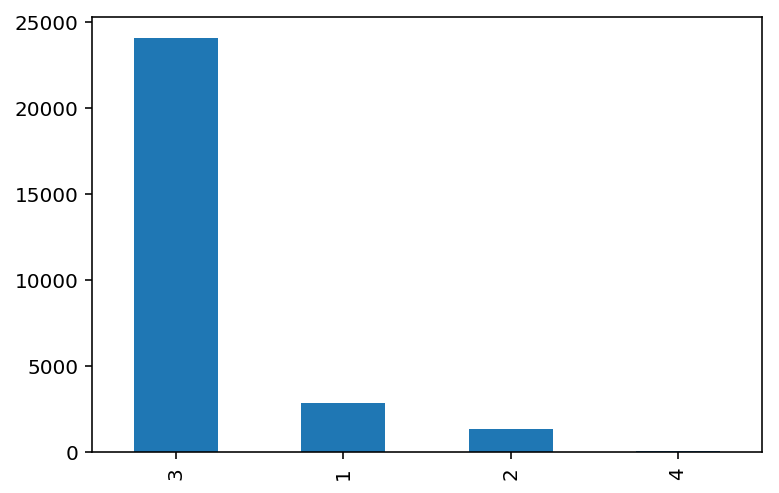

In [54]:
#check pick time hour, arrival pick time hour, Personal or Business, Platform Type

#Platform visualization

all_t['Platform Type'].value_counts().plot(kind = "bar")

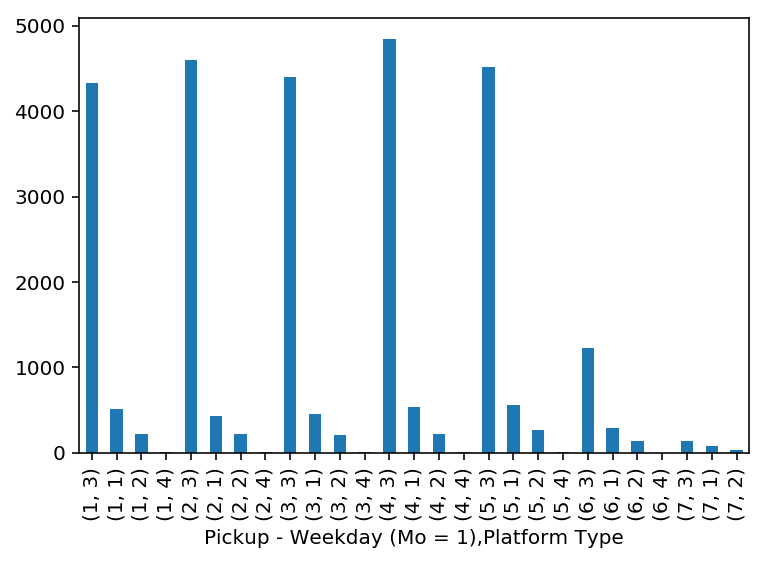

In [55]:
all_t.groupby('Pickup - Weekday (Mo = 1)')['Platform Type'].value_counts().plot(kind='bar')

- Write your observation 

Most orders are primarily in platform 3 with a few in platform 1

- We should investigate what these platforms represent

- We should investigate if orders on certain platforms are faster or slower

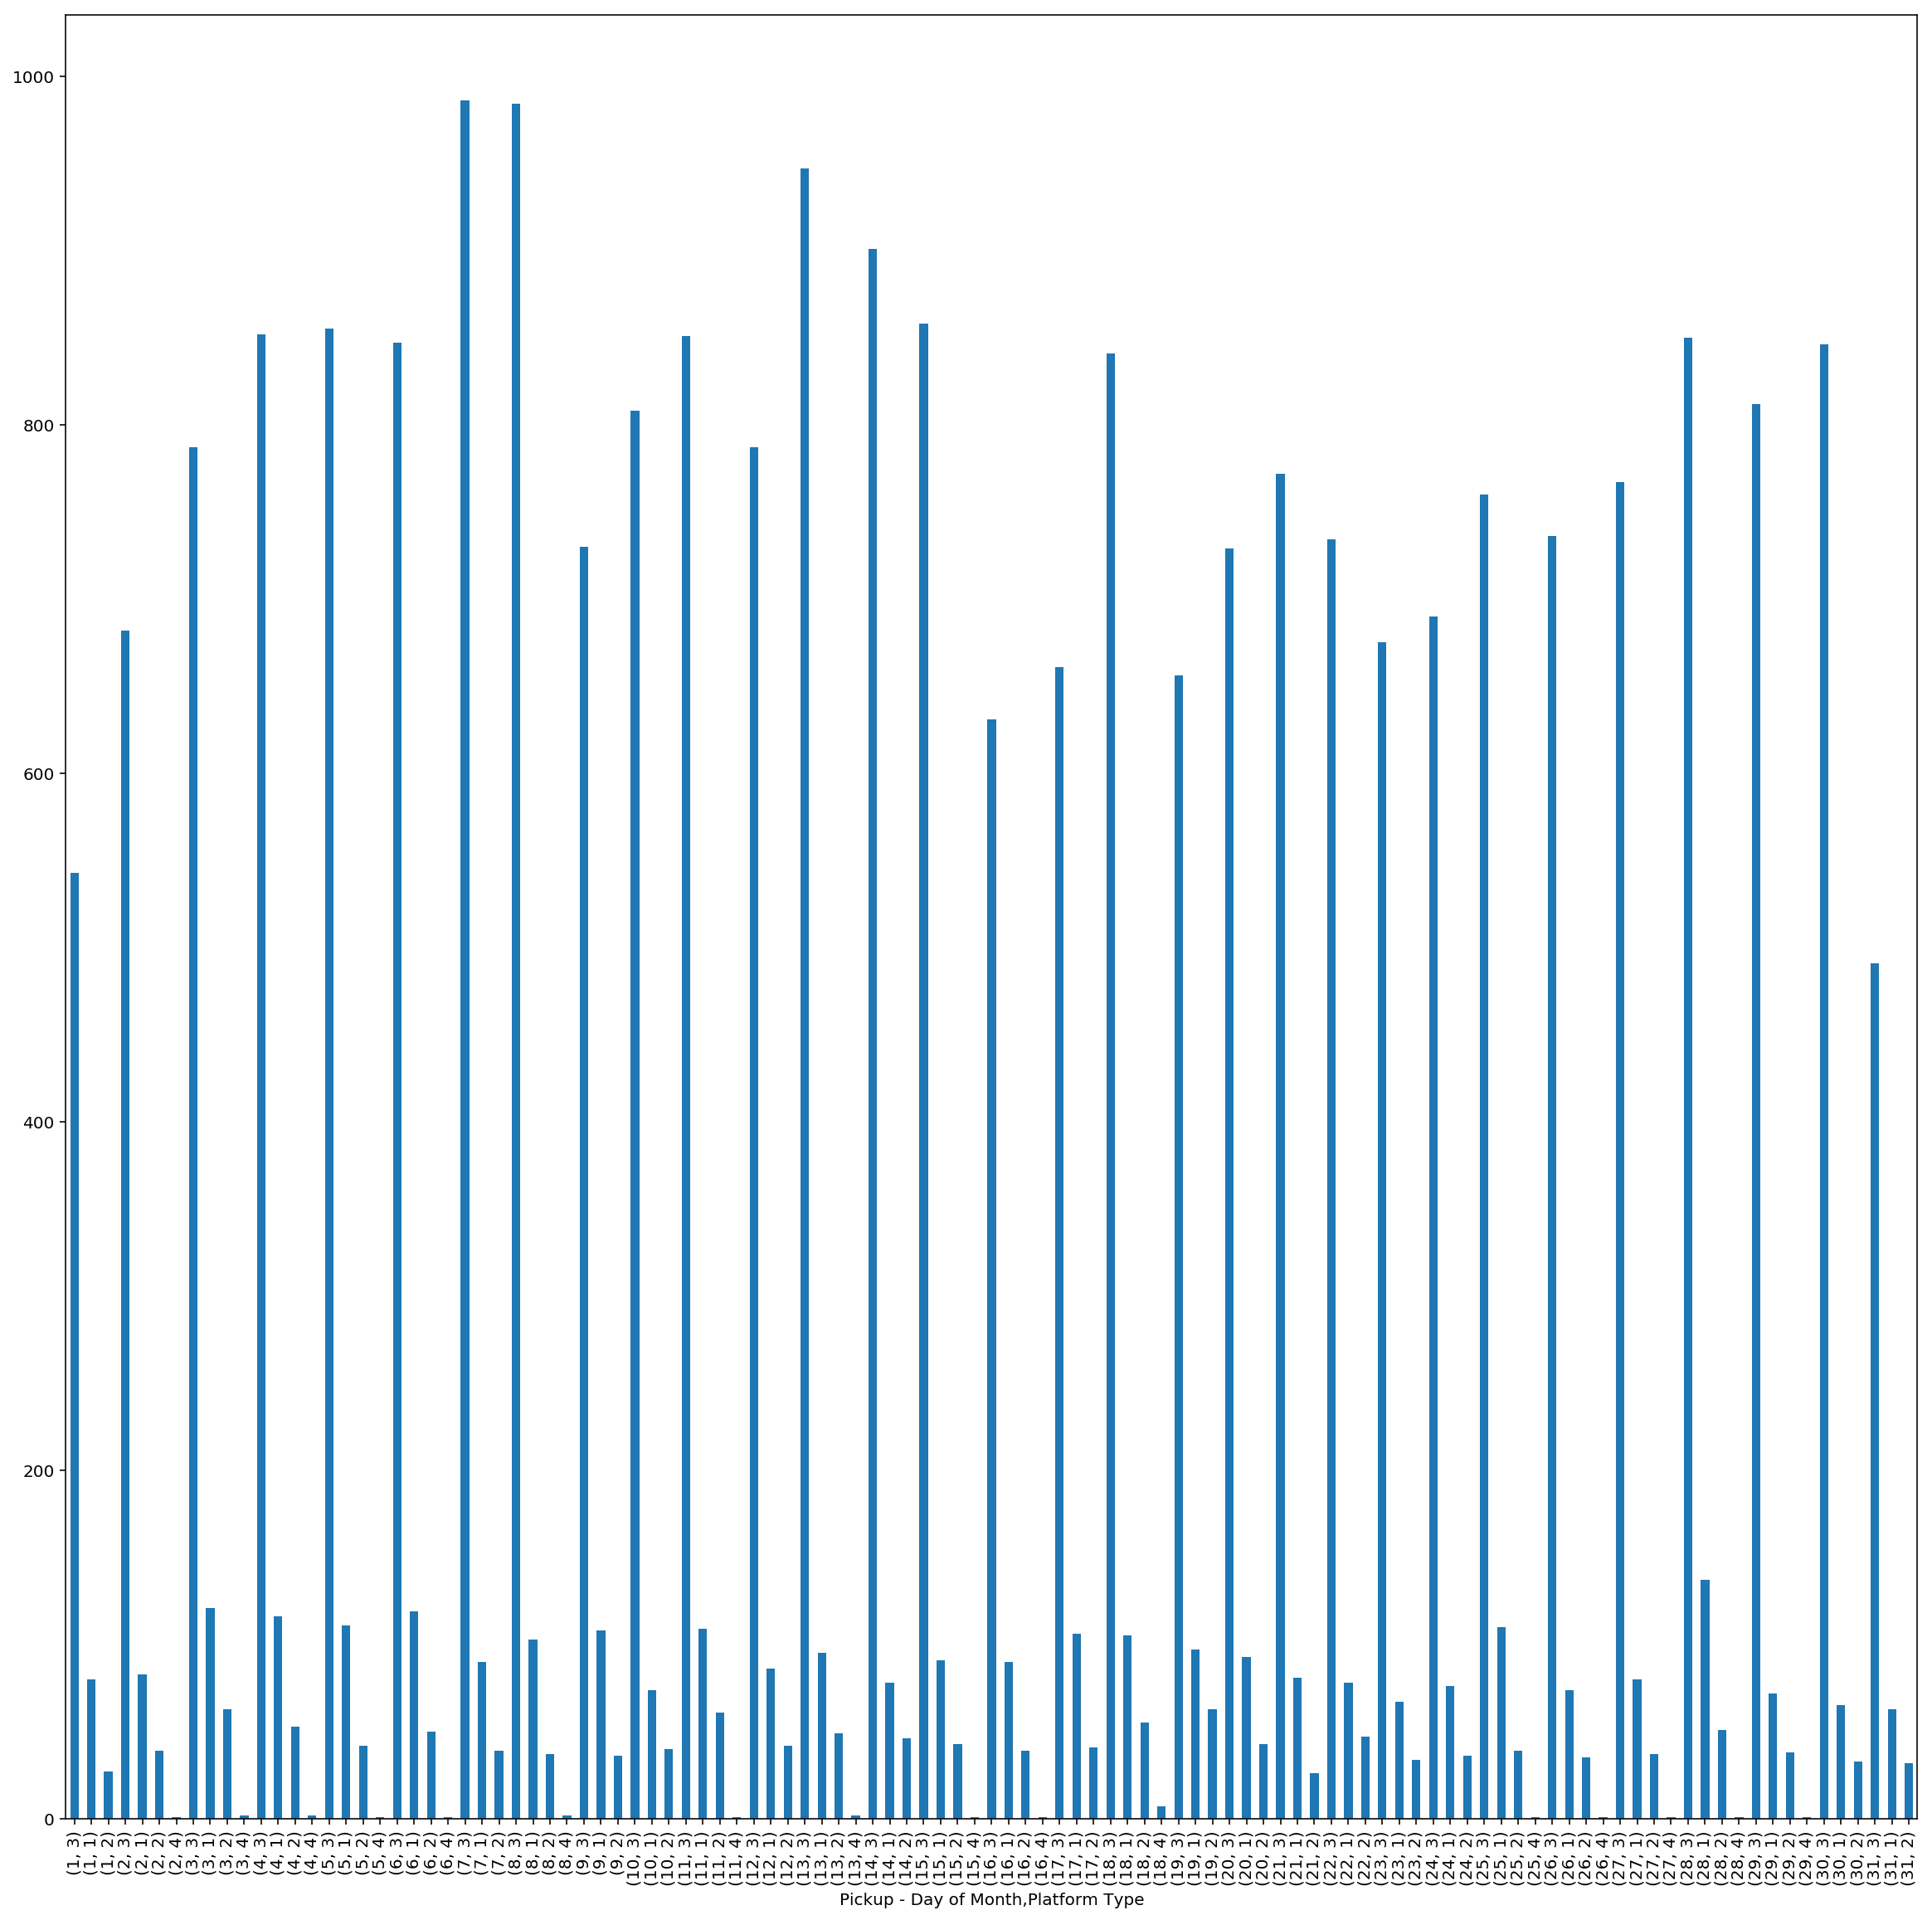

In [56]:
plt.figure(figsize = (20, 20))

all_t.groupby(['Pickup - Day of Month'])['Platform Type'].value_counts().plot(kind='bar')

In [57]:
all_t.columns

Index(['Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Platform Type', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'identifier', 'No_Of_Orders',
       'Age', 'Average_Rating', 'No_of_Ratings',
       'confirmation_placement_delta', 'arrival pickup_confirmation delta',
       'pickup_arrival pickup_delta', 'pick time hour',
       'arrival pick time hour', 'latitude difference', 'longitude difference',
       'long lat diff', 'speed'],
      dtype='object')

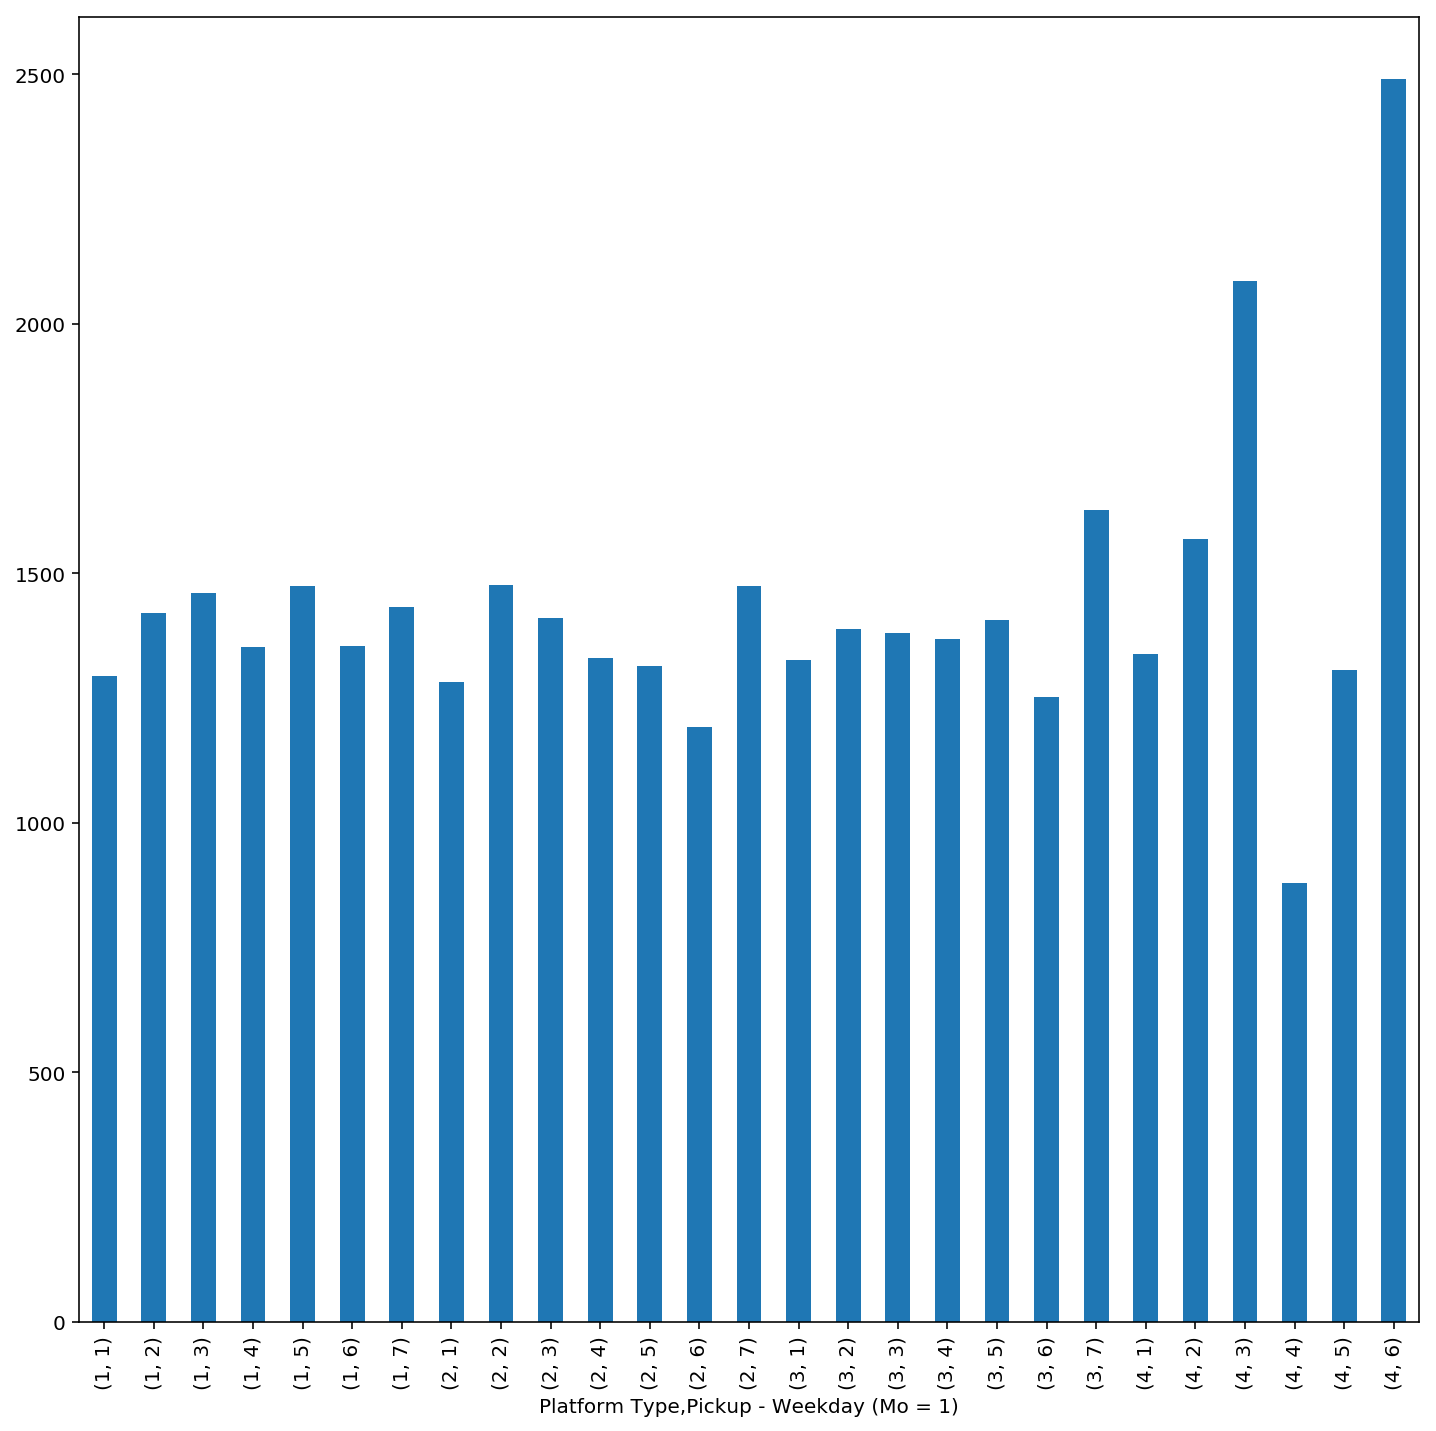

In [58]:
#Platform range of Time of Arrival

plt.figure(figsize = (12, 12))

all_t_train.groupby(['Platform Type', 'Pickup - Weekday (Mo = 1)'])['Time from Pickup to Arrival'].median().plot(kind = 'bar')

Platform 4 & weekday 6 high Time from Pickup to Arrival, possibly just few datapoints

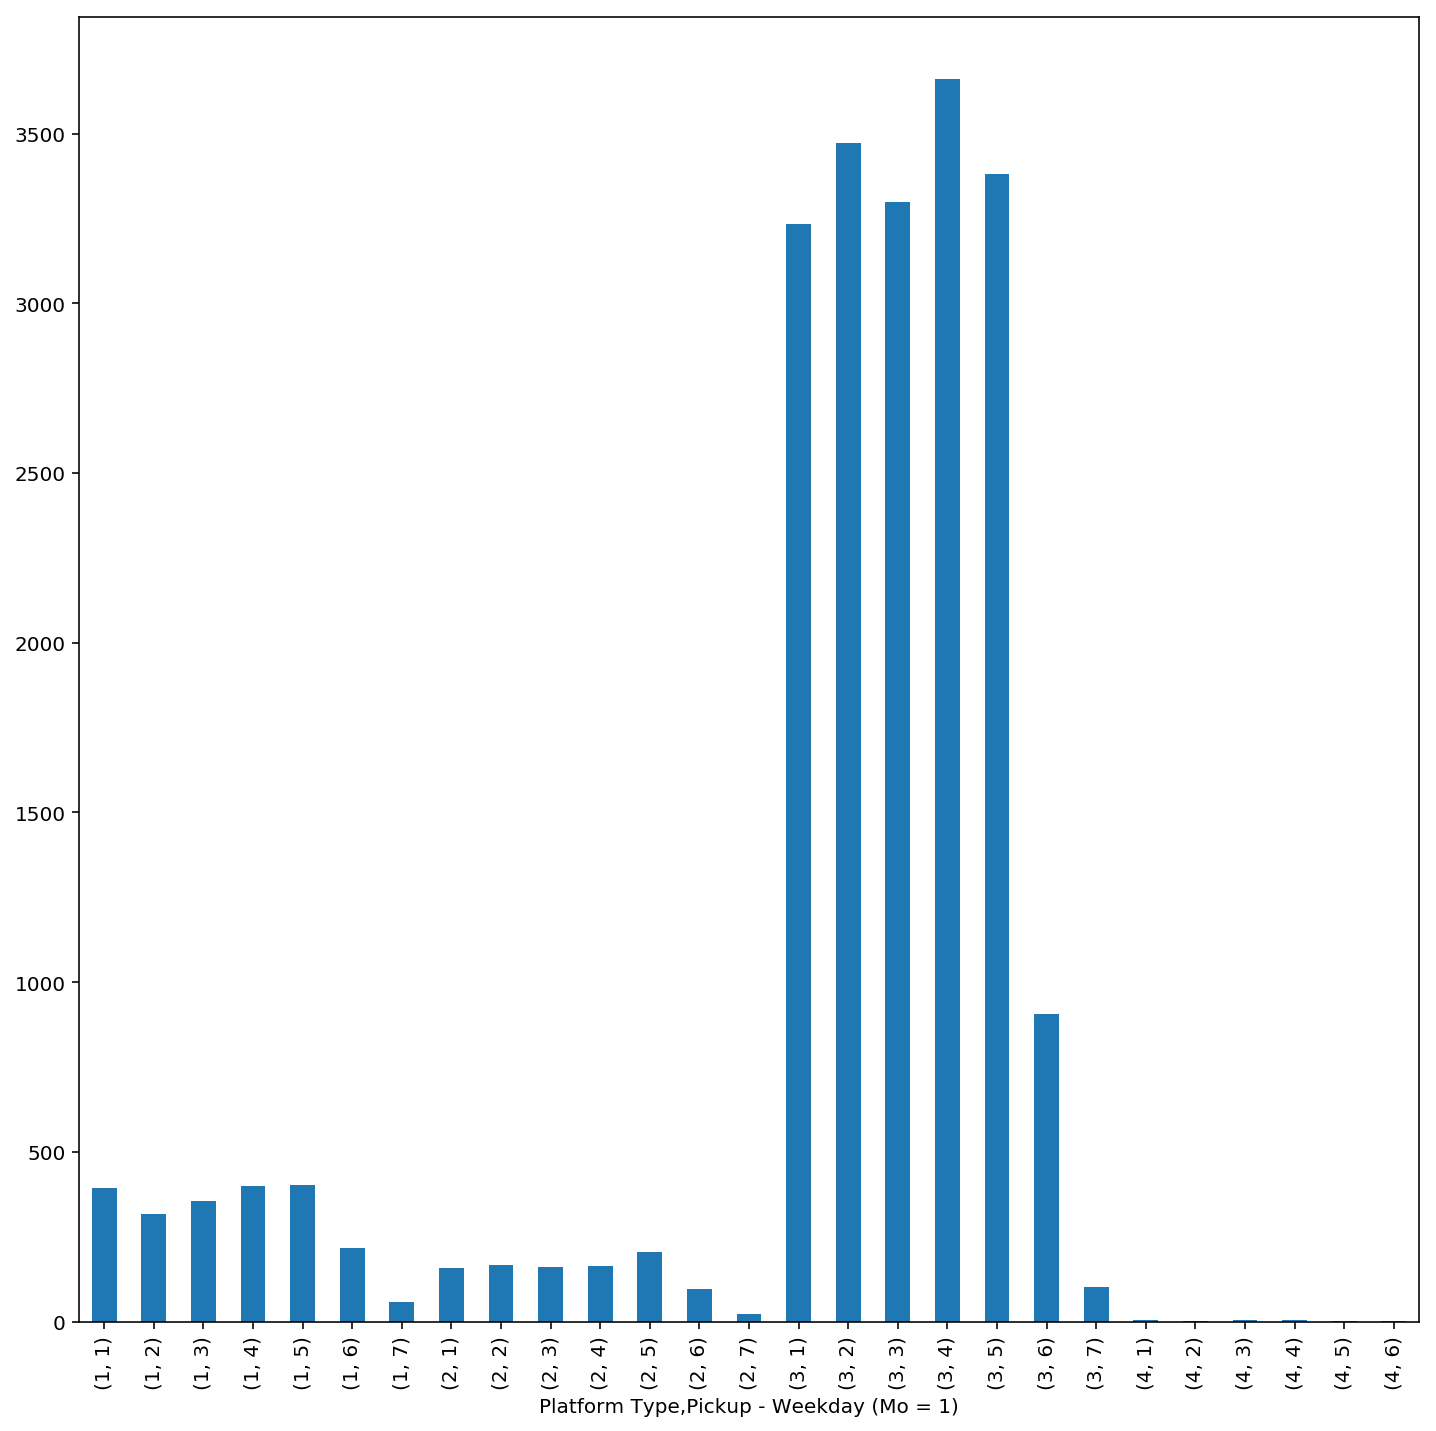

In [59]:
#Platform range of Time of Arrival

plt.figure(figsize = (12, 12))

all_t_train.groupby(['Platform Type', 'Pickup - Weekday (Mo = 1)'])['Time from Pickup to Arrival'].count().plot(kind = 'bar')

Verified High Time value in Platform 4 & weekday 6 due to few datapoints

No clear pattern for Time values by Platforms

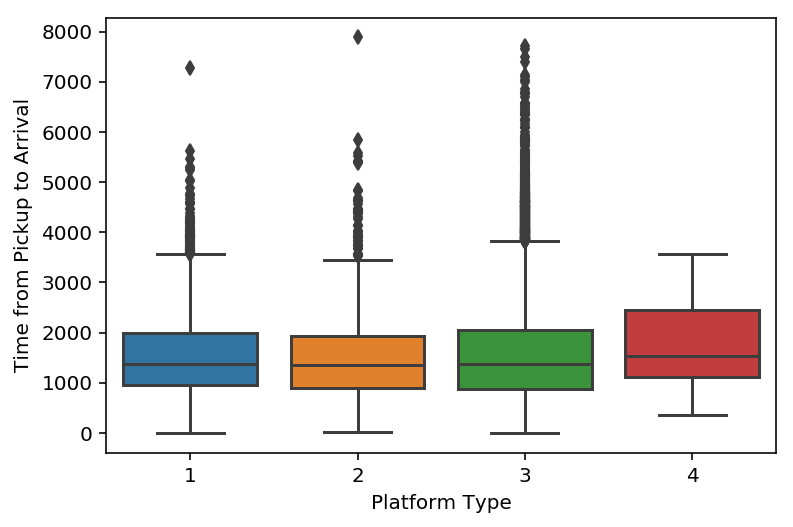

In [60]:
#visualize Platform boxplot to understand distribution 

sb.boxplot(data = all_t_train, x = 'Platform Type', y = 'Time from Pickup to Arrival')

Verfied Platform Type isn't a clear indication of Time from Pickup to Arrival

Time range is similar across all platforms, with a few outliers

Unlikely to be a predictive feature

In [61]:
all_t.columns

Index(['Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Platform Type', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'identifier', 'No_Of_Orders',
       'Age', 'Average_Rating', 'No_of_Ratings',
       'confirmation_placement_delta', 'arrival pickup_confirmation delta',
       'pickup_arrival pickup_delta', 'pick time hour',
       'arrival pick time hour', 'latitude difference', 'longitude difference',
       'long lat diff', 'speed'],
      dtype='object')

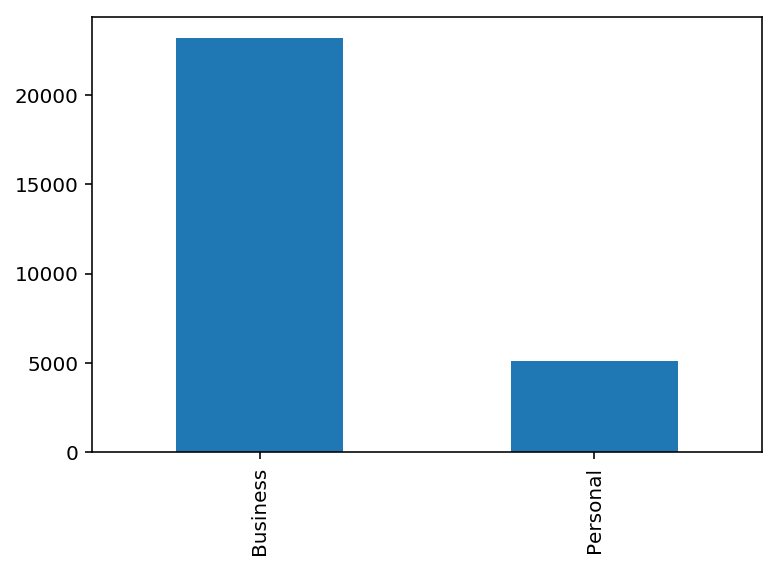

In [62]:
#Personal or Business visualization

all_t['Personal or Business'].value_counts().plot(kind = "bar")

In [63]:
all_t.groupby('Pickup - Day of Month')['Personal or Business'].unique().head(3)

Pickup - Day of Month
1    [Business, Personal]
2    [Personal, Business]
3    [Business, Personal]
Name: Personal or Business, dtype: object

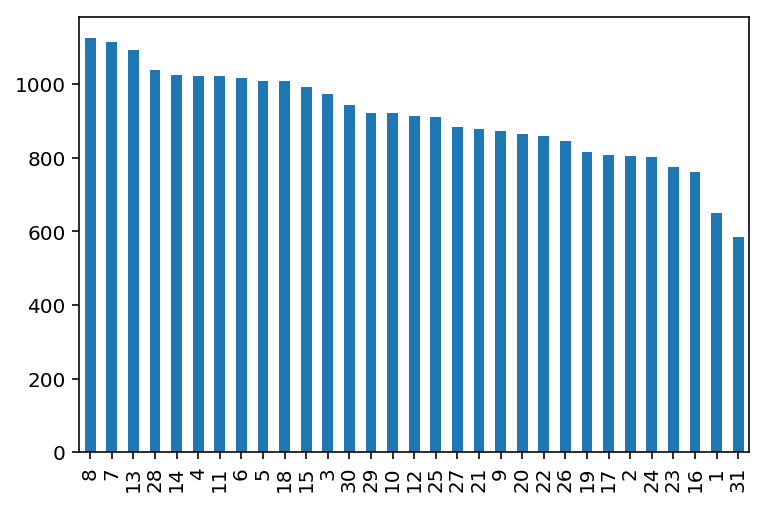

In [64]:
all_t['Pickup - Day of Month'].value_counts().plot(kind='bar')

We have the highest frequency of riding activity on `7th & 8th day`. That is probably the second monday & tuesday of the month.

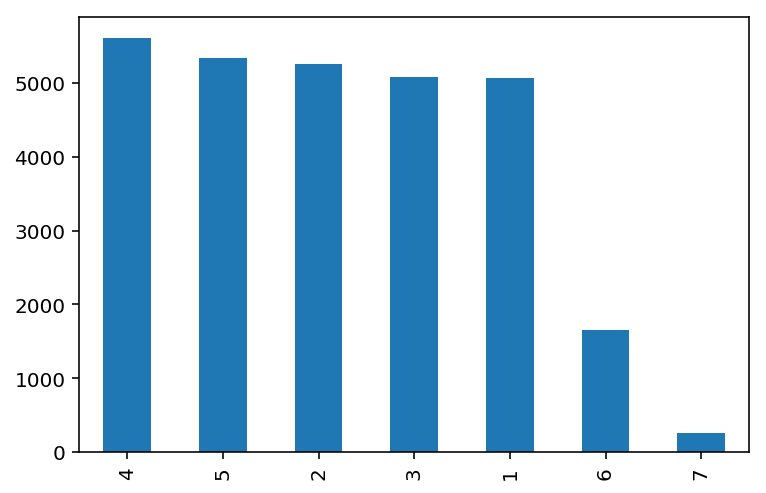

In [65]:
all_t['Pickup - Weekday (Mo = 1)'].value_counts().plot(kind='bar')

- Write your observation 

Lowest activity on weekday 6 & 7, most likely Saturday & Sunday

Peak activity on weekday 4, Thursday


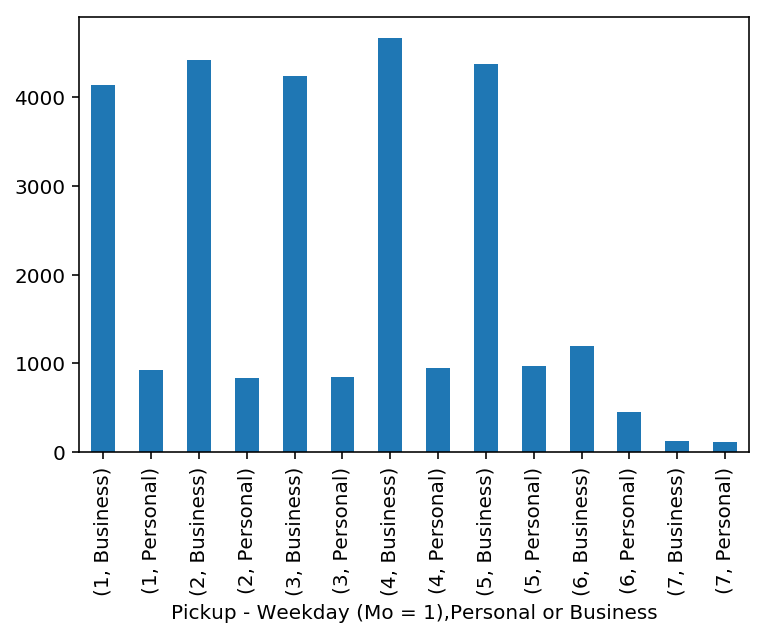

In [66]:
all_t.groupby('Pickup - Weekday (Mo = 1)')['Personal or Business'].value_counts().plot(kind='bar')

- Write your observation 

Most orders are weekdays and for business purposes

On weekends, businesses order less, which makes sense since it's typically a non-working day

- We should investigate what range of values for Time of arrival for business and personal orders

- We should investigate if non-working days Time of arrival orders are slower or faster


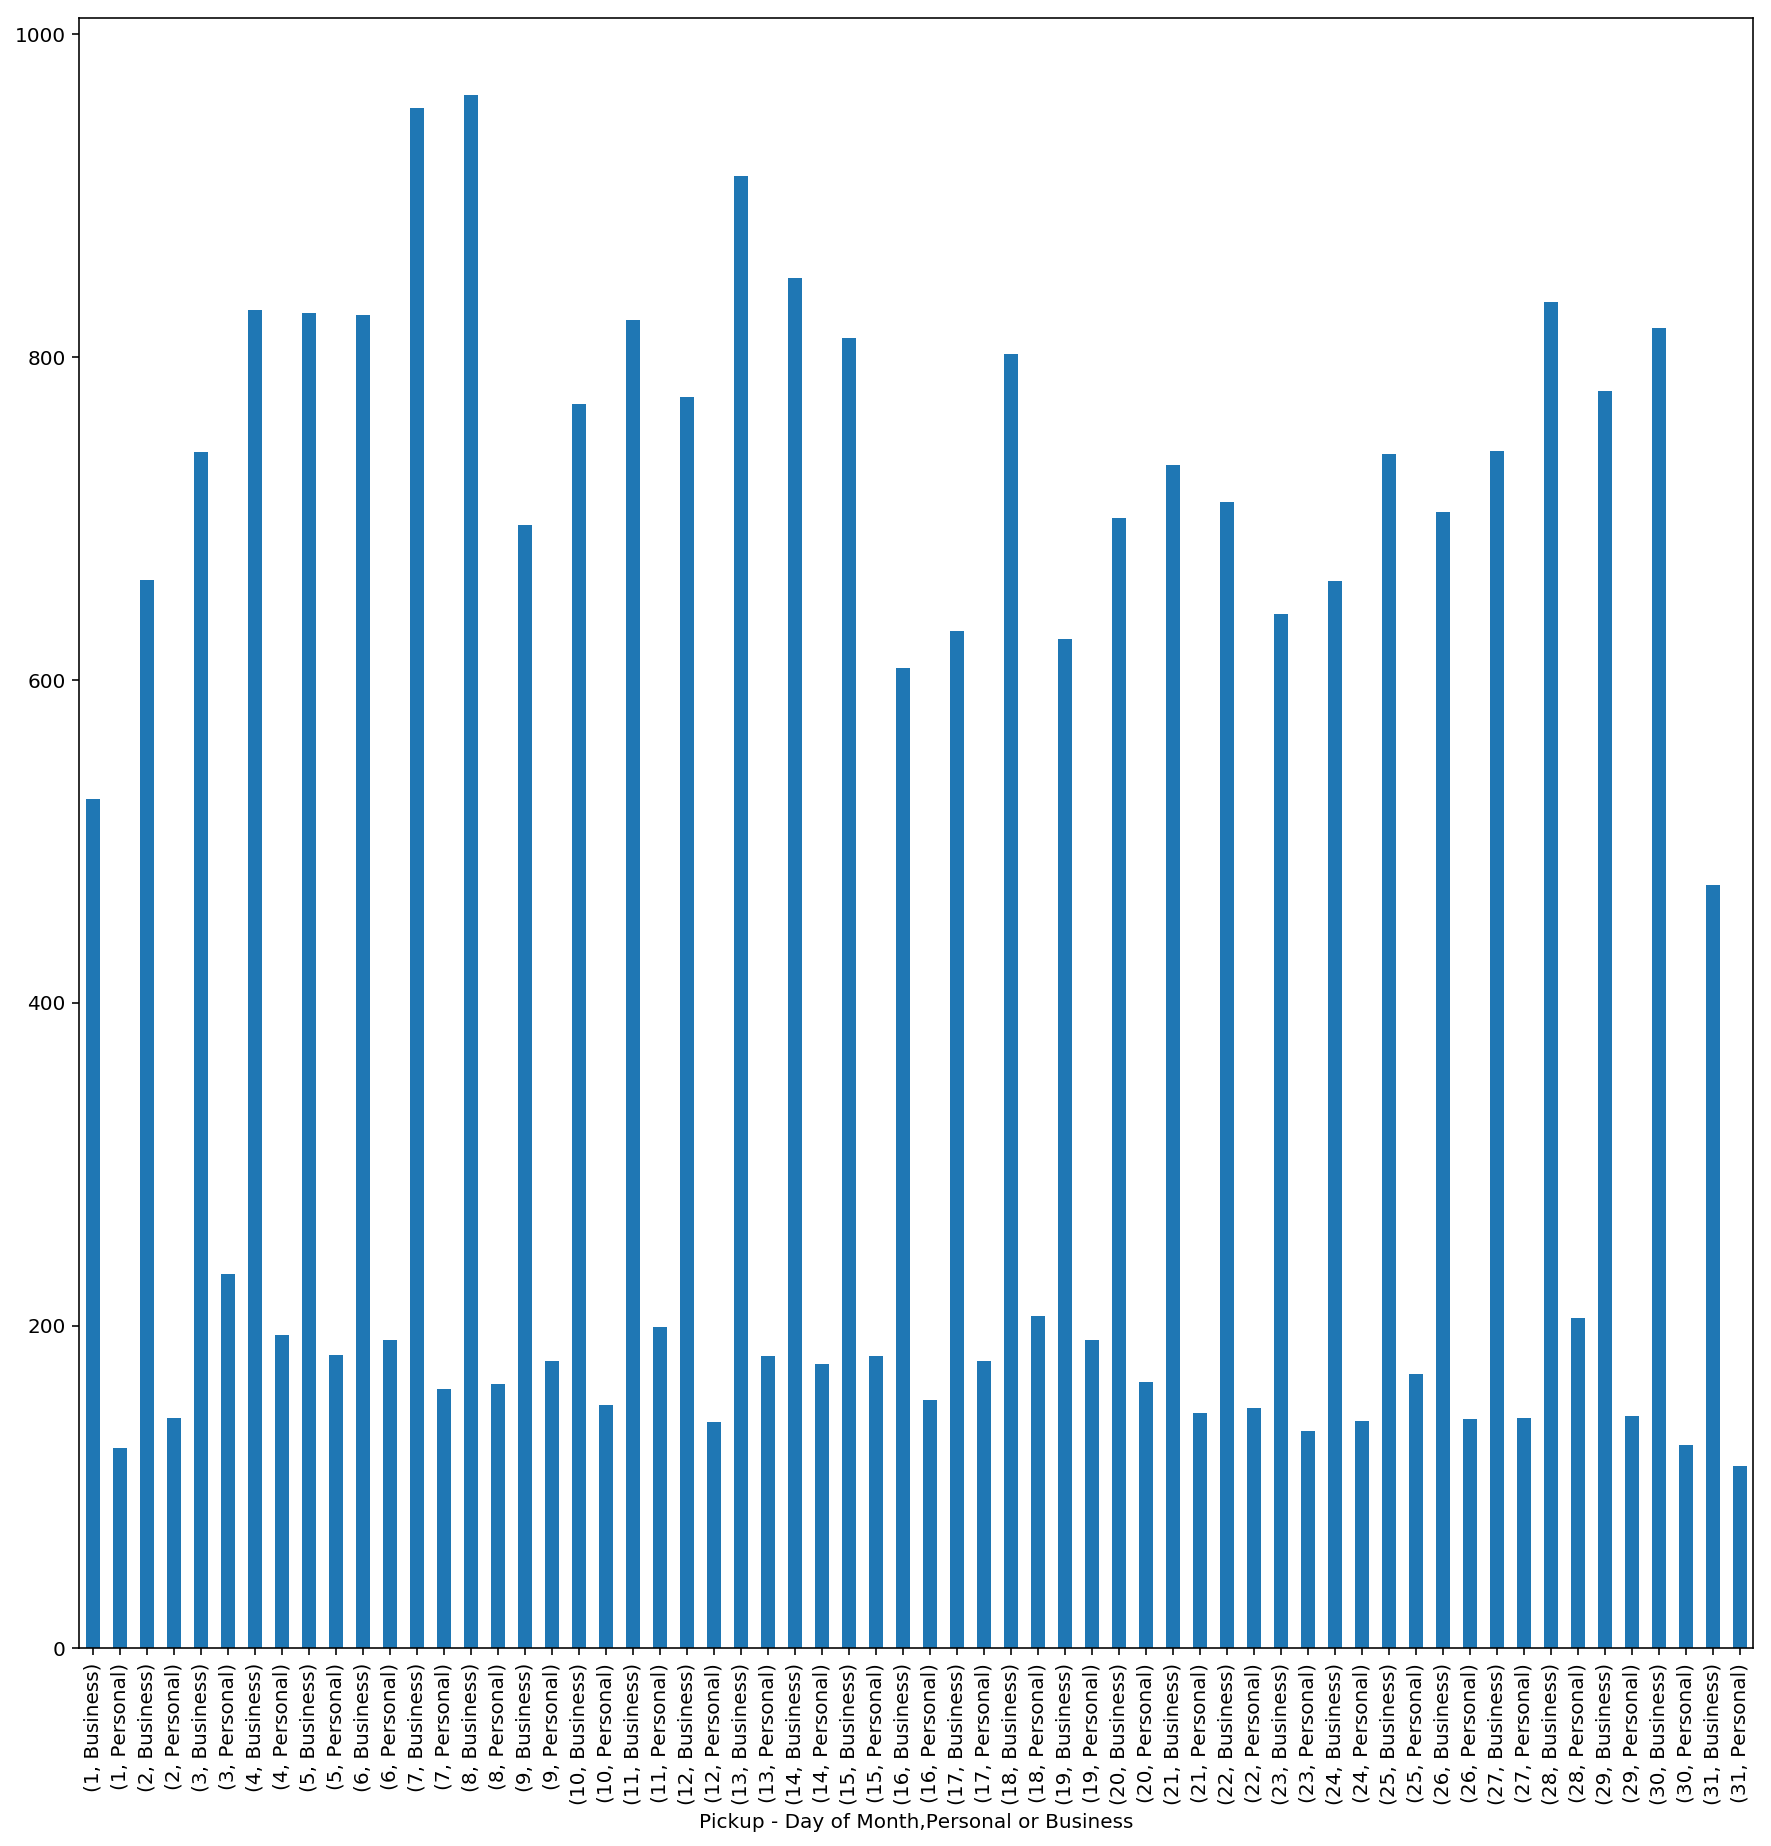

In [67]:
plt.figure(figsize = (15, 15))

all_t.groupby(['Pickup - Day of Month'])['Personal or Business'].value_counts().plot(kind='bar')

- Write your observation 
 
 Peak orders are in the 2nd week between 7th to 14th day of month for business orders

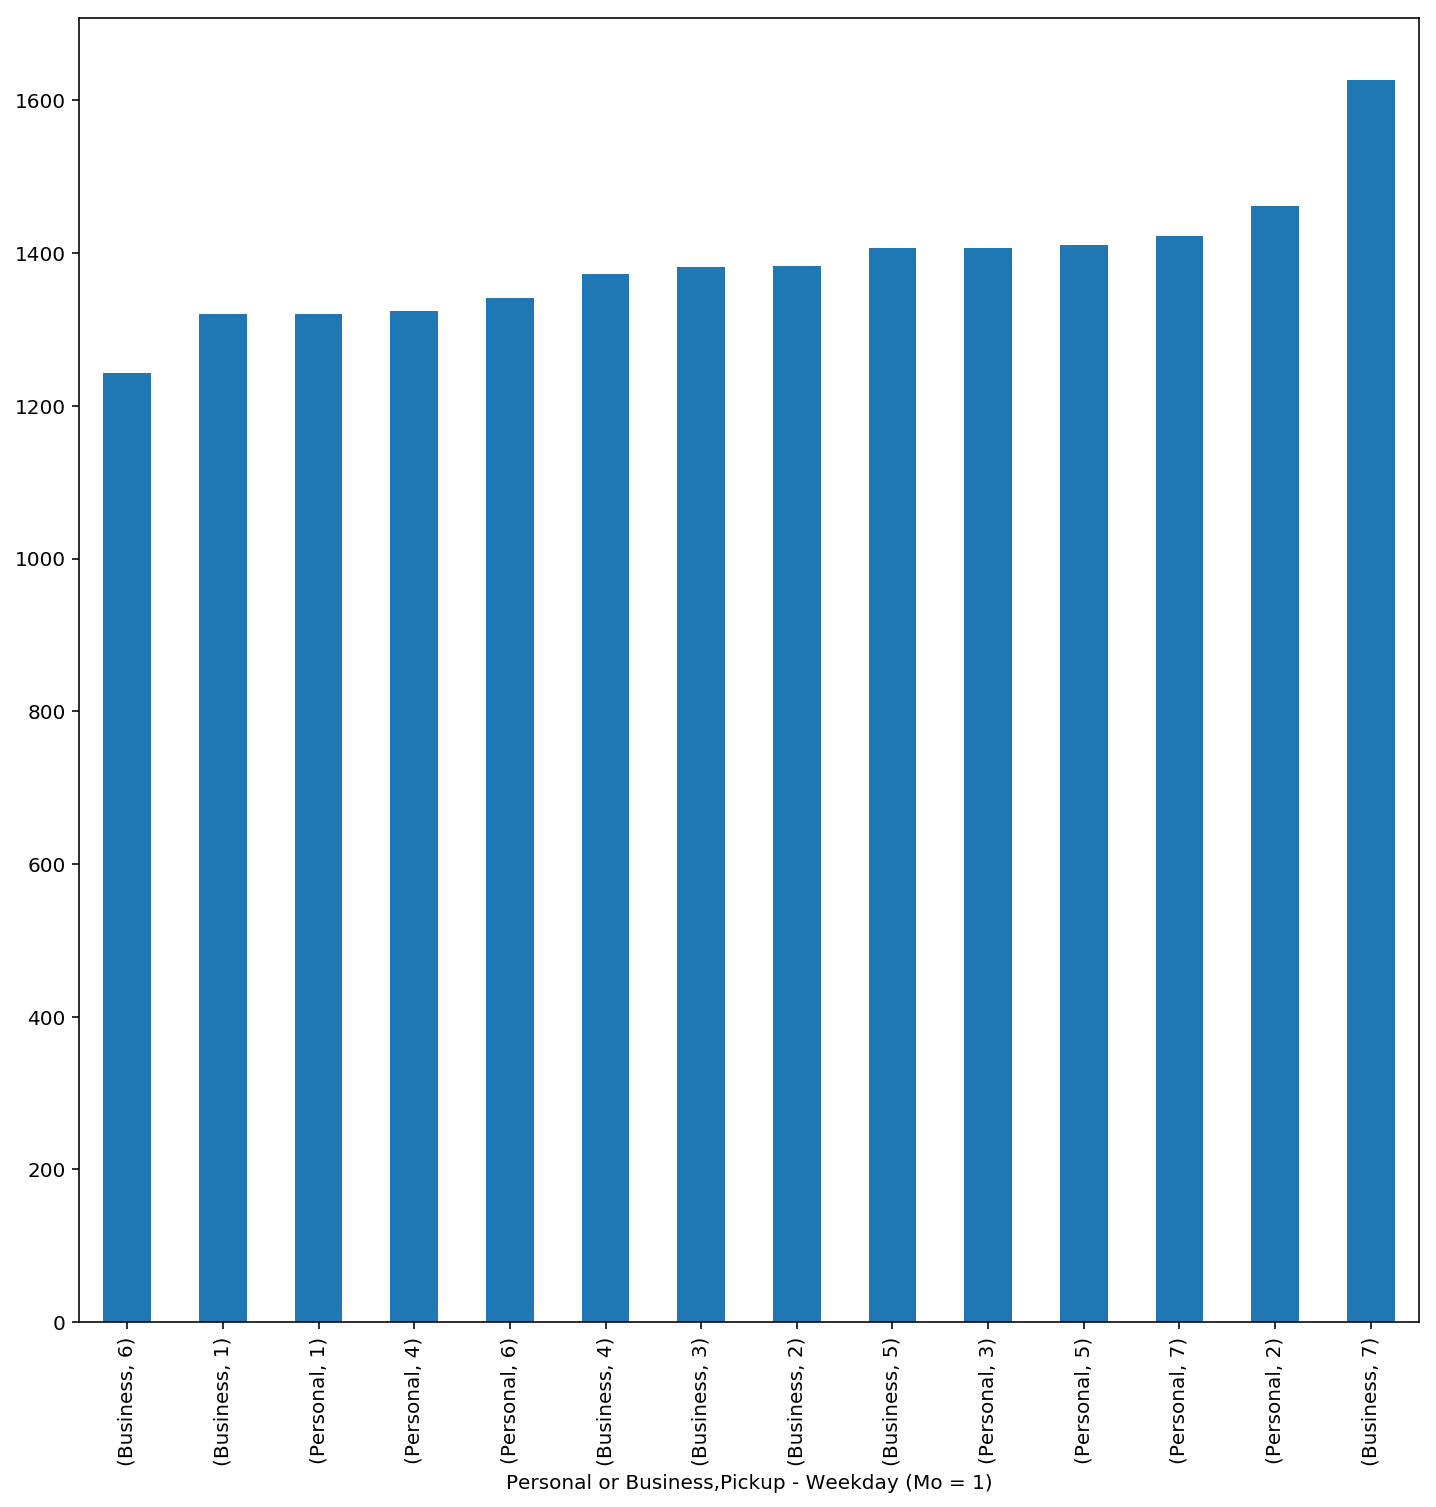

In [68]:
#Platform range of Time of Arrival

plt.figure(figsize = (12, 12))

all_t_train.groupby(['Personal or Business', 'Pickup - Weekday (Mo = 1)'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')


- Write your observation 

Confirmed Business Orders on Sundays are significantly slower in delivery

Examine Personal & Business by hour






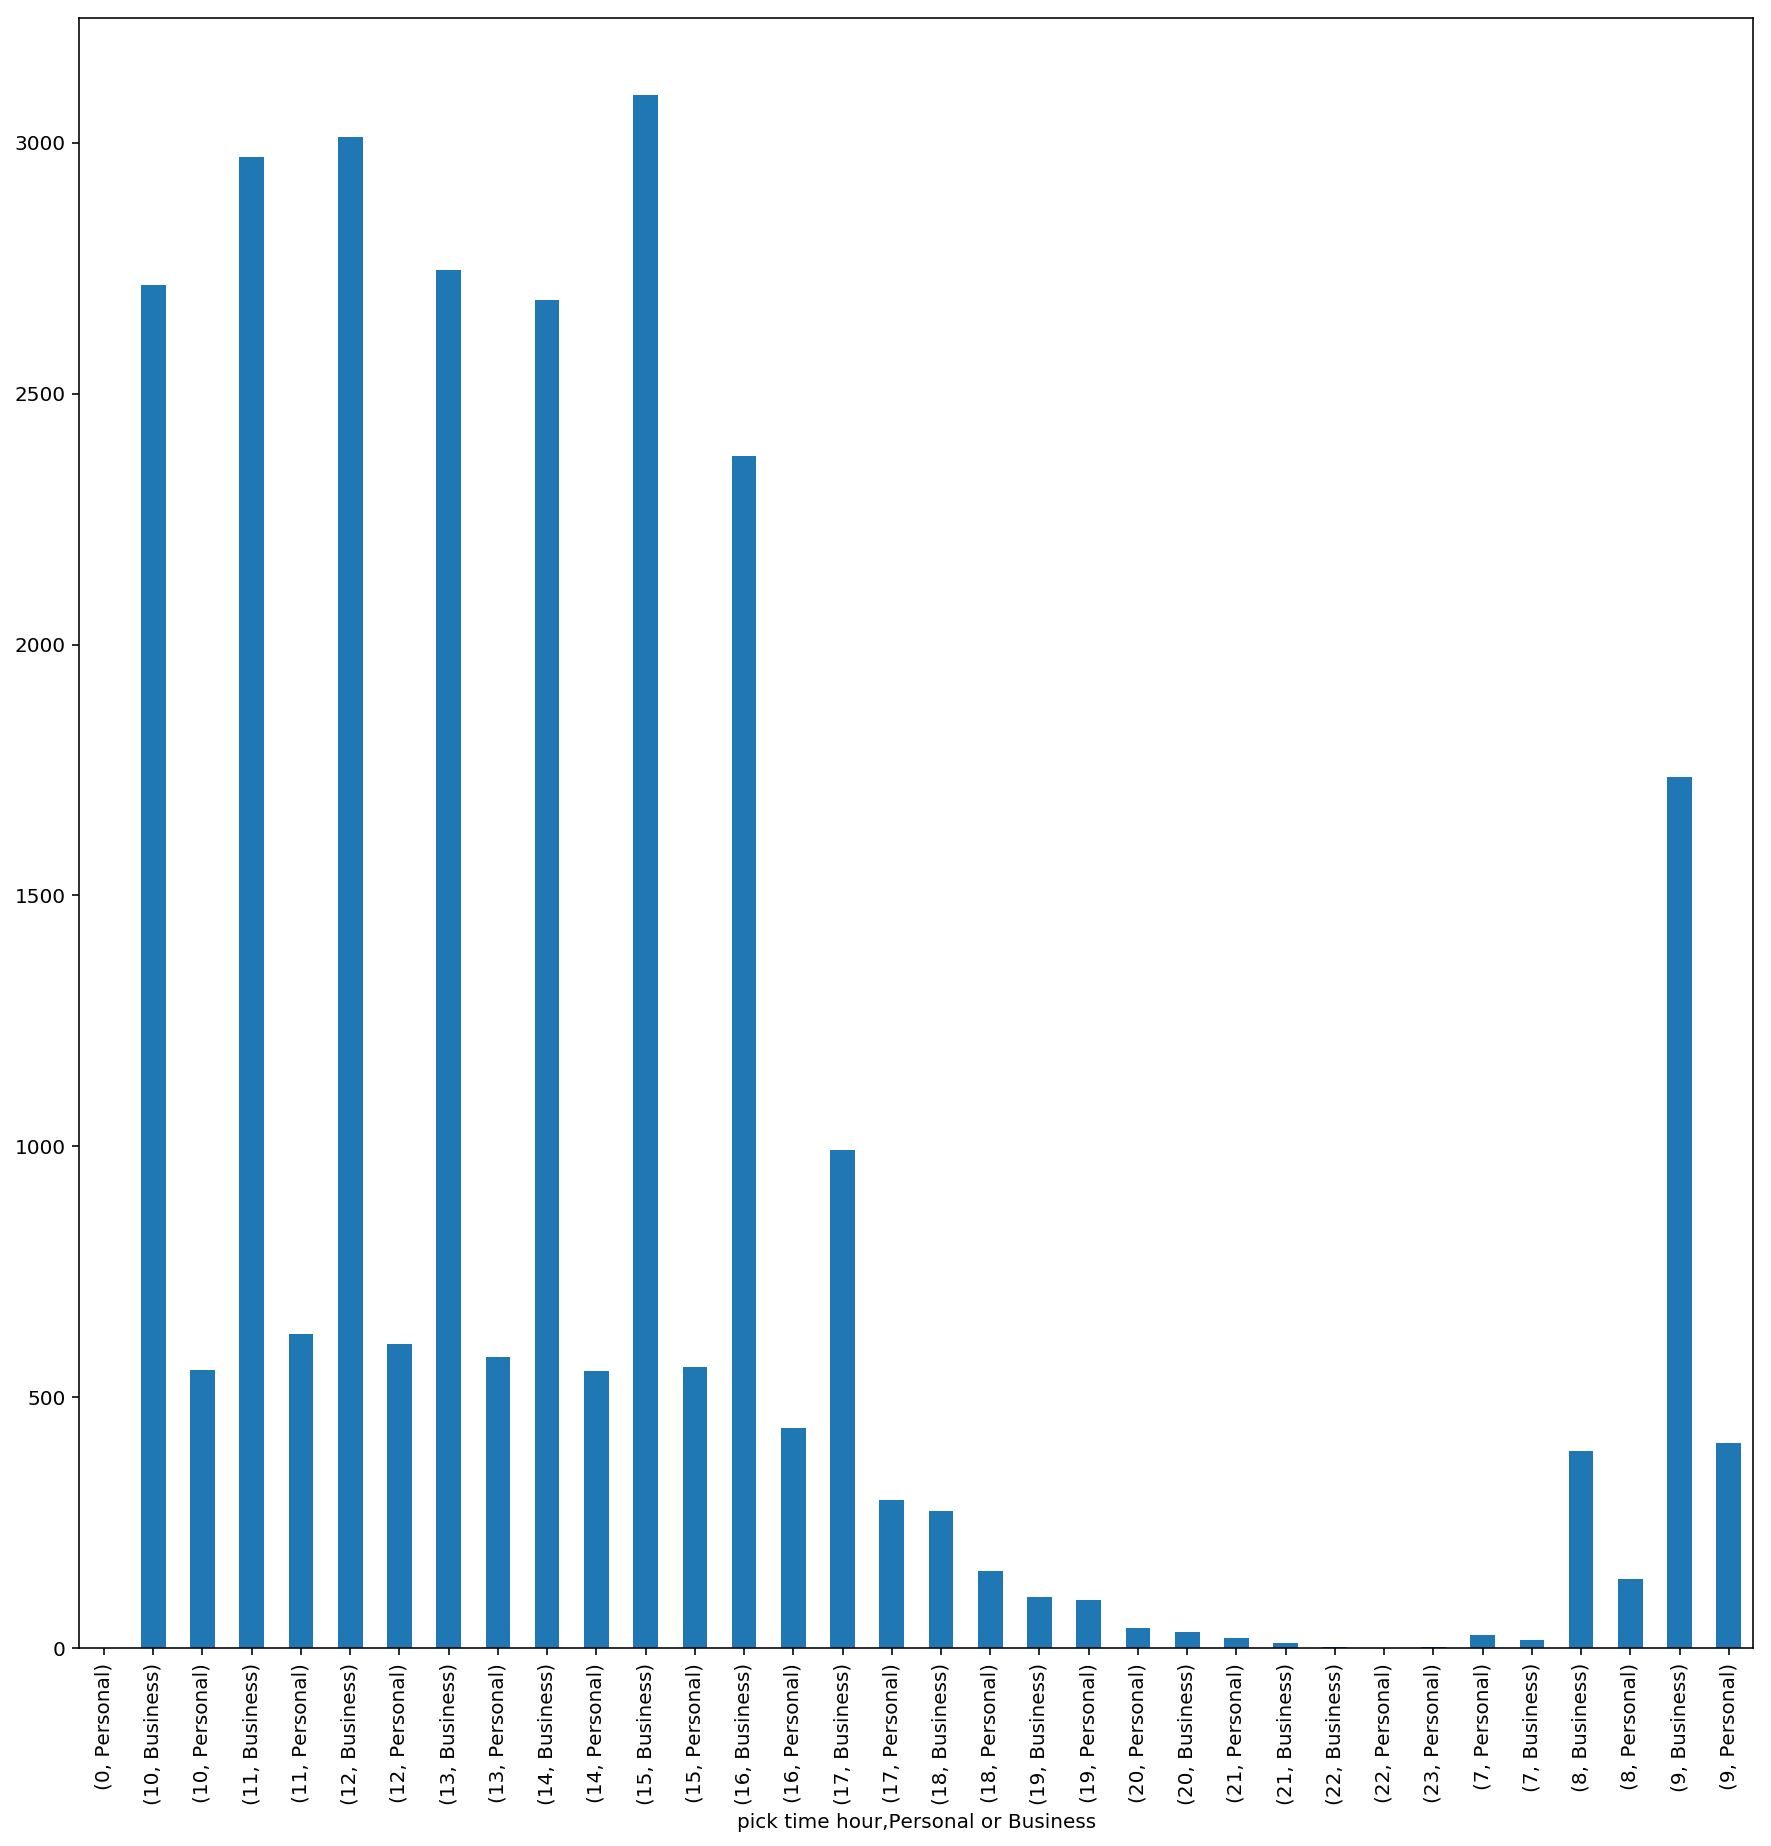

In [69]:
plt.figure(figsize = (15, 15))

all_t.groupby(['pick time hour'])['Personal or Business'].value_counts().plot(kind='bar')

Most business orders are between 9am - 3pm

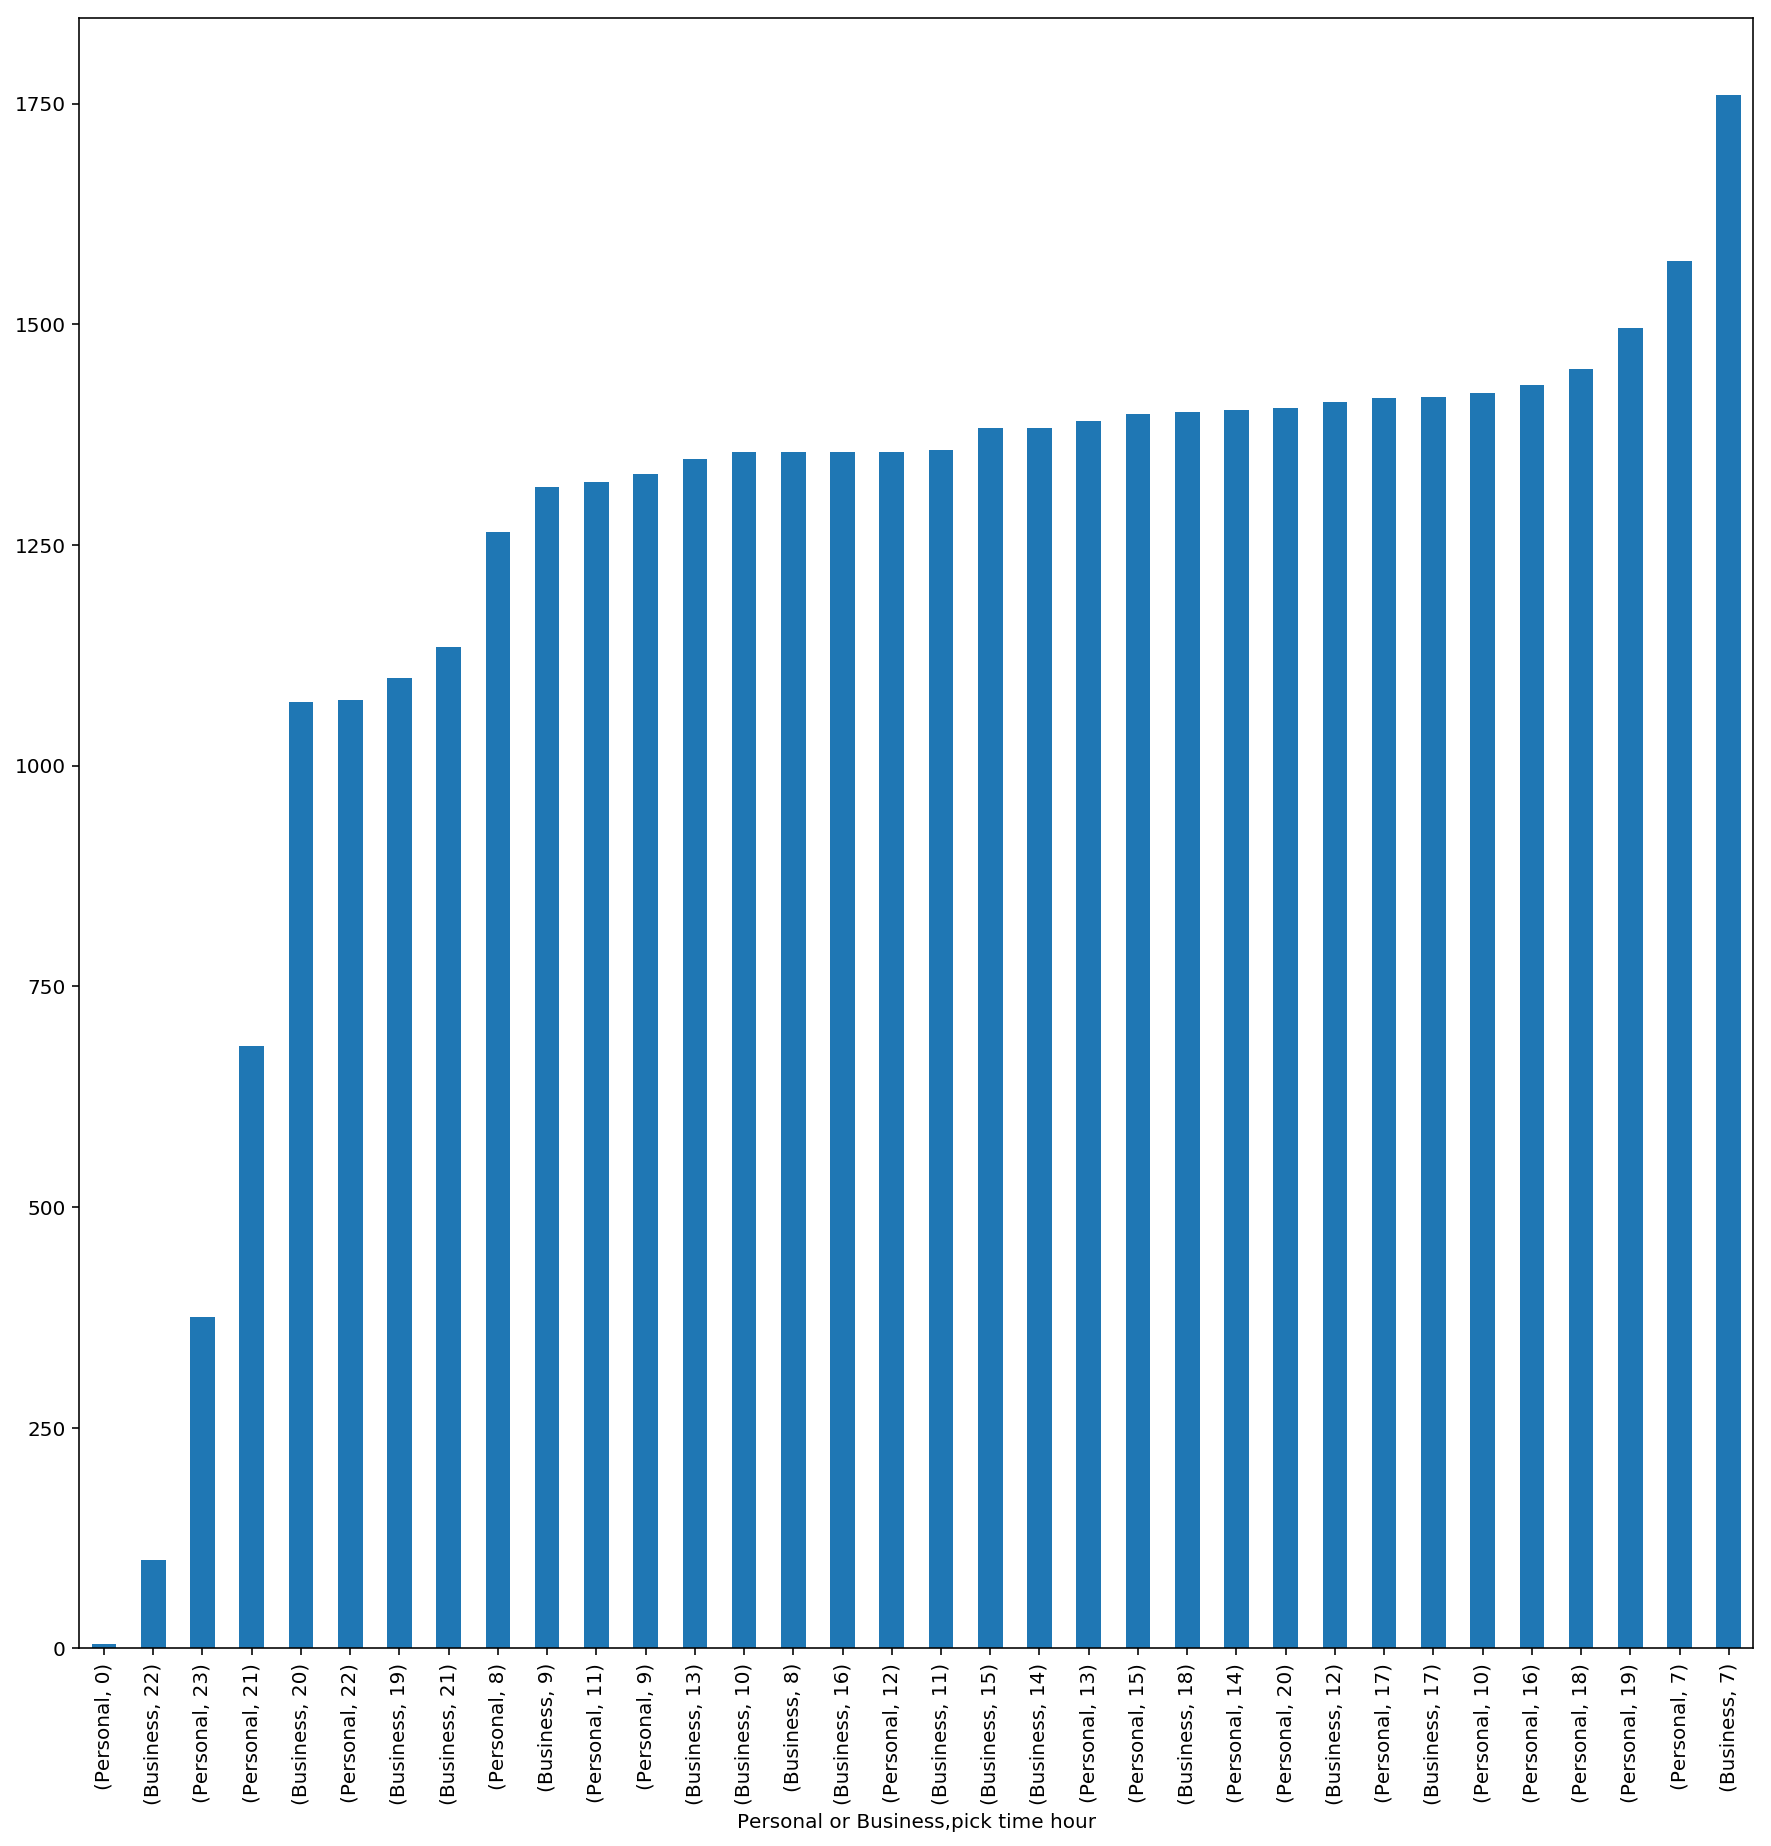

In [70]:
#Platform range of Time of Arrival

plt.figure(figsize = (15, 15))

all_t_train.groupby(['Personal or Business', 'pick time hour'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')


Business orders by 7am & 5pm, within work closing time are the longest in delivery possibly due to traffic

7am seems like a general traffic period for both business 7 personal orders, investigate using hours as features

Orders are quicker in deliveries at night

(Hour of day most likely a good feature especially for rush hour and inactivity period at night)



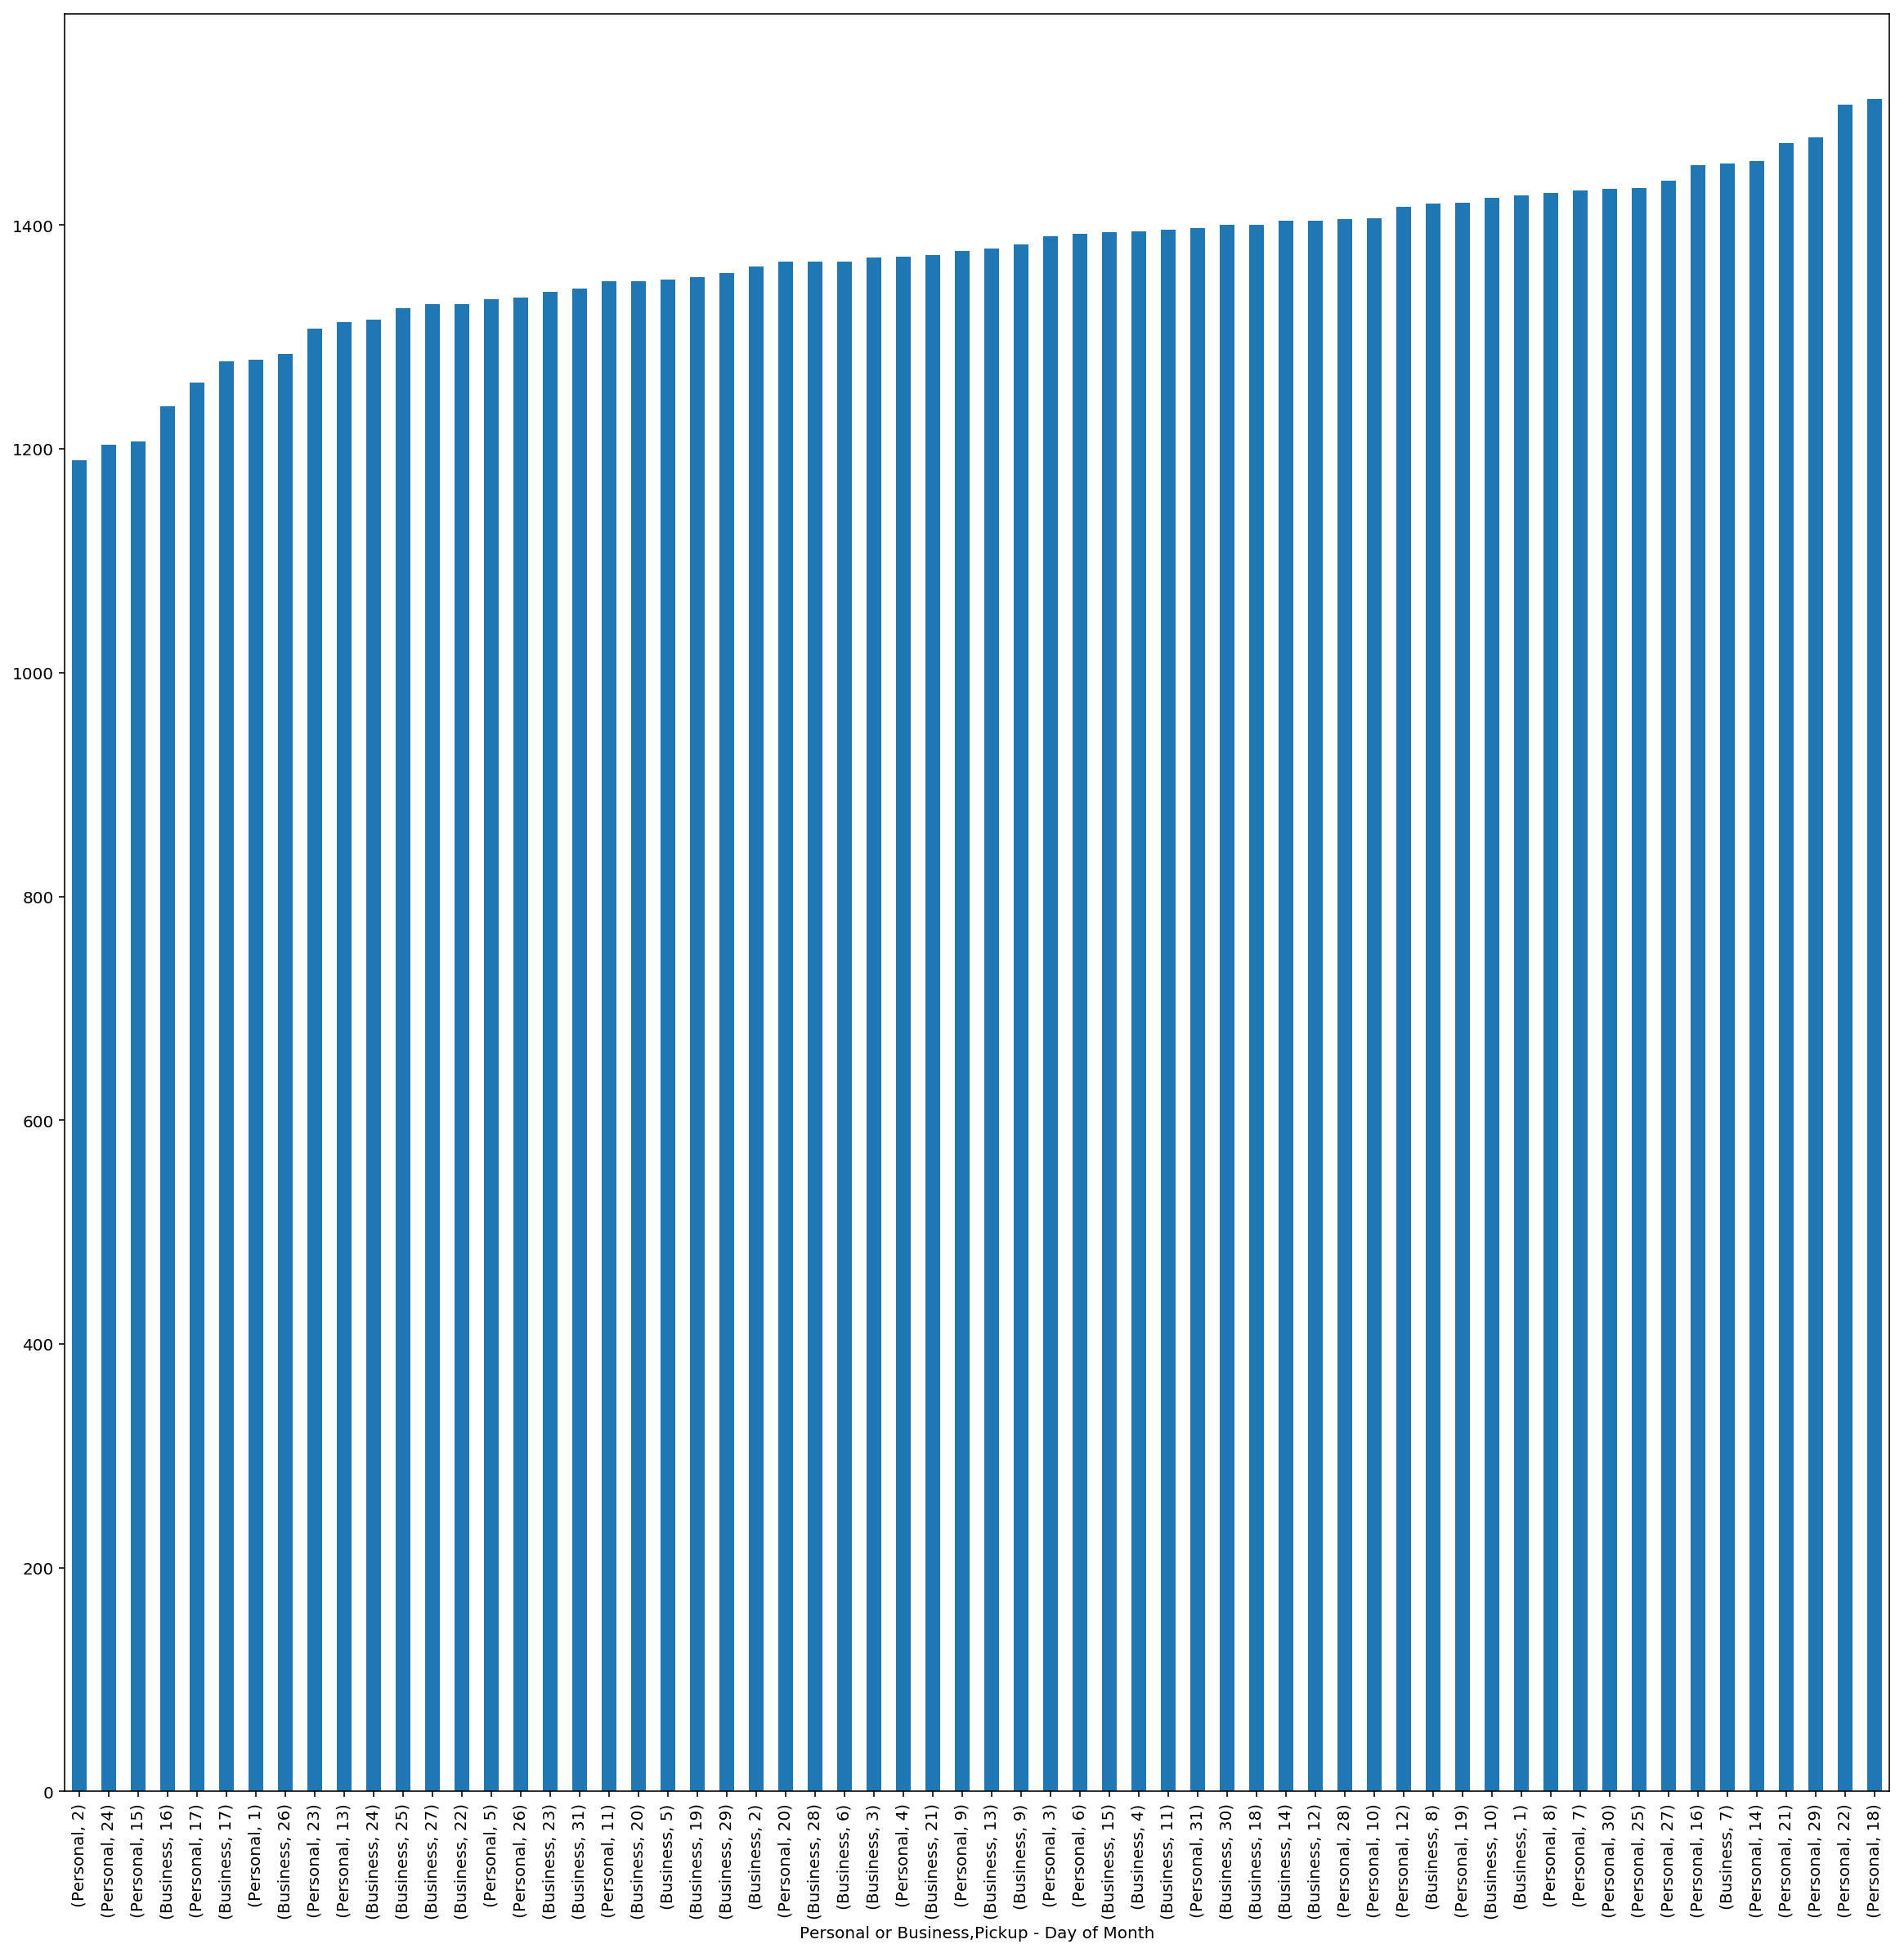

In [71]:
#Platform range of Time of Arrival

plt.figure(figsize = (20, 20))

all_t_train.groupby(['Personal or Business', 'Pickup - Day of Month'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')


There is no specific day of month where orders typically take longer in deliveries

Personal orders are much longer in week 3-4

Business orders are longer in week 2

Try augmenting the datasets by week of month instead of Day of Month & check pattern again

In [72]:
#function for week of month

def augment_month_week(df):
    
    if df in list(range(1, 8)):
        
        return 'week 1'
    
    elif df in list(range(8, 15)):
        
        return 'week 2'
    
    elif df in list(range(15, 23)):
        
        return 'week 3'
    
    else:
        
        return 'week 4'

In [73]:
#applying augment month_week fucntion

all_t['week of month'] = all_t['Pickup - Day of Month'].apply(augment_month_week)

In [74]:
#resassign train data to reflect new feature

all_t_train = all_t[all_t['identifier'] == 1]

In [75]:
all_t_train.shape

(21201, 29)

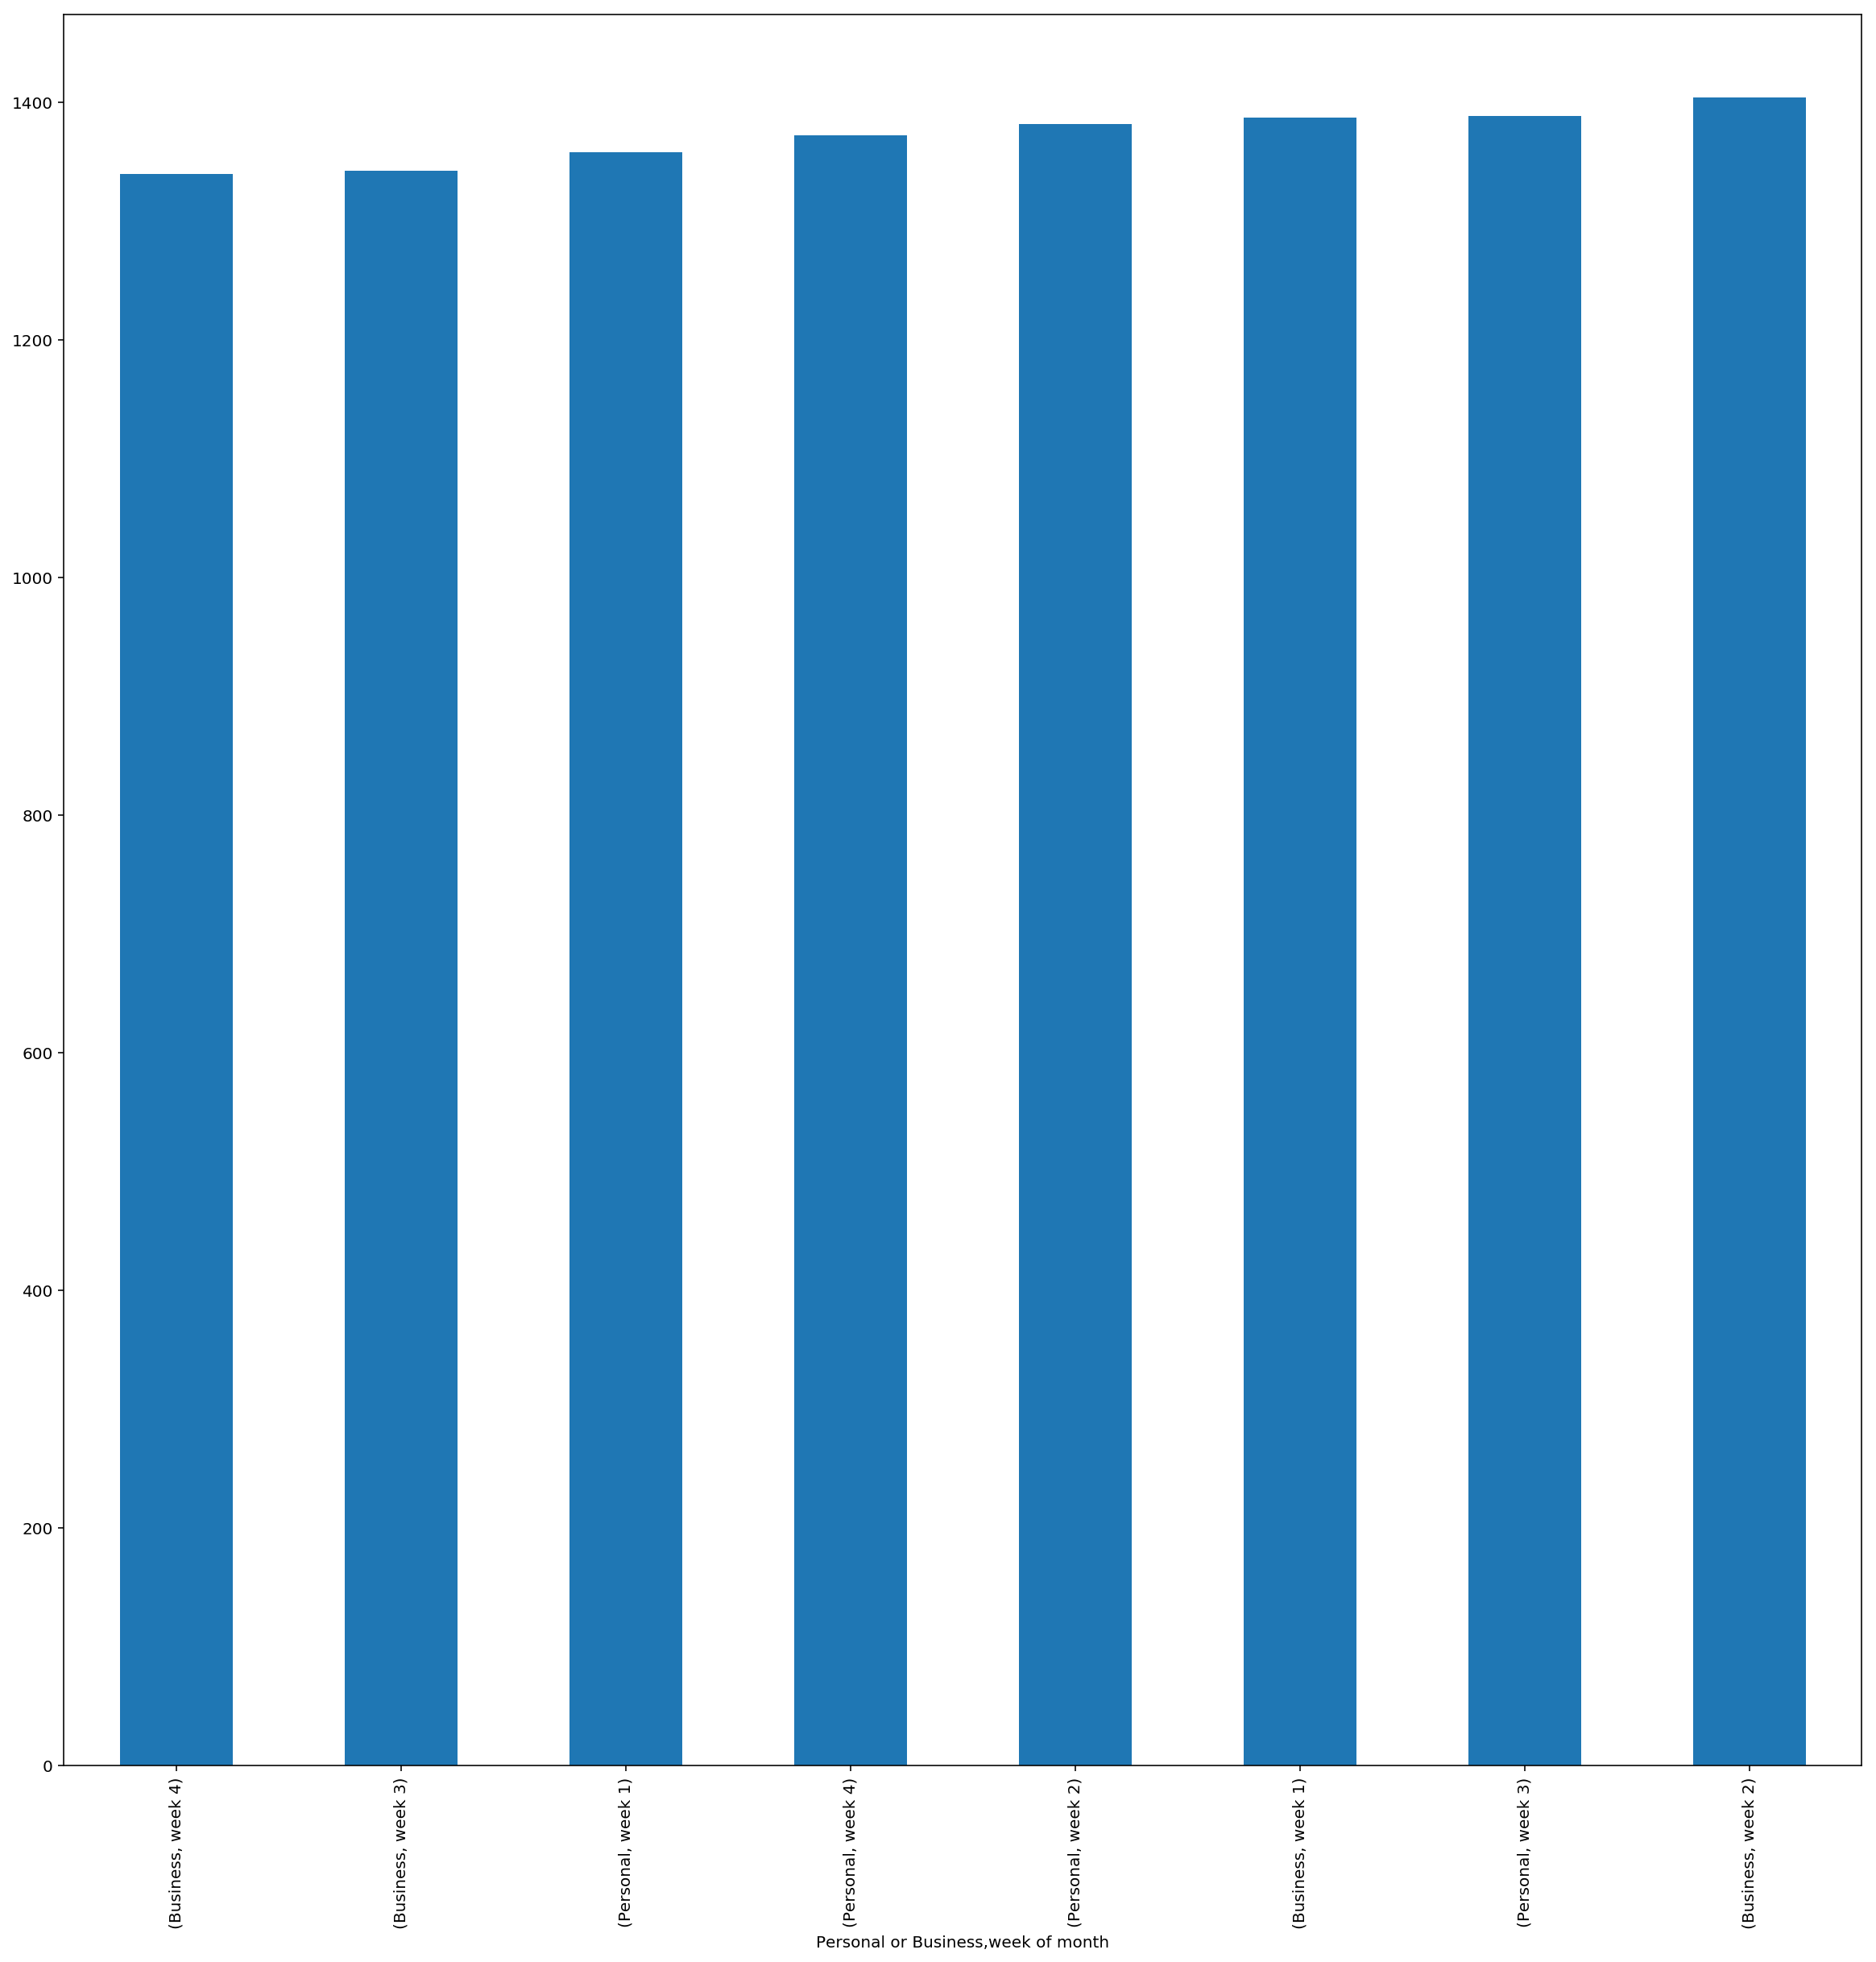

In [76]:
#Platform range of Time of Arrival for week of month

plt.figure(figsize = (20, 20))

all_t_train.groupby(['Personal or Business', 'week of month'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')


Orders are longer generally in week 2

Business longest in week 1 & 2, personal orders longest in week 2 & 3

Week feature more predictive than Day of Month & easier to recognize a pattern

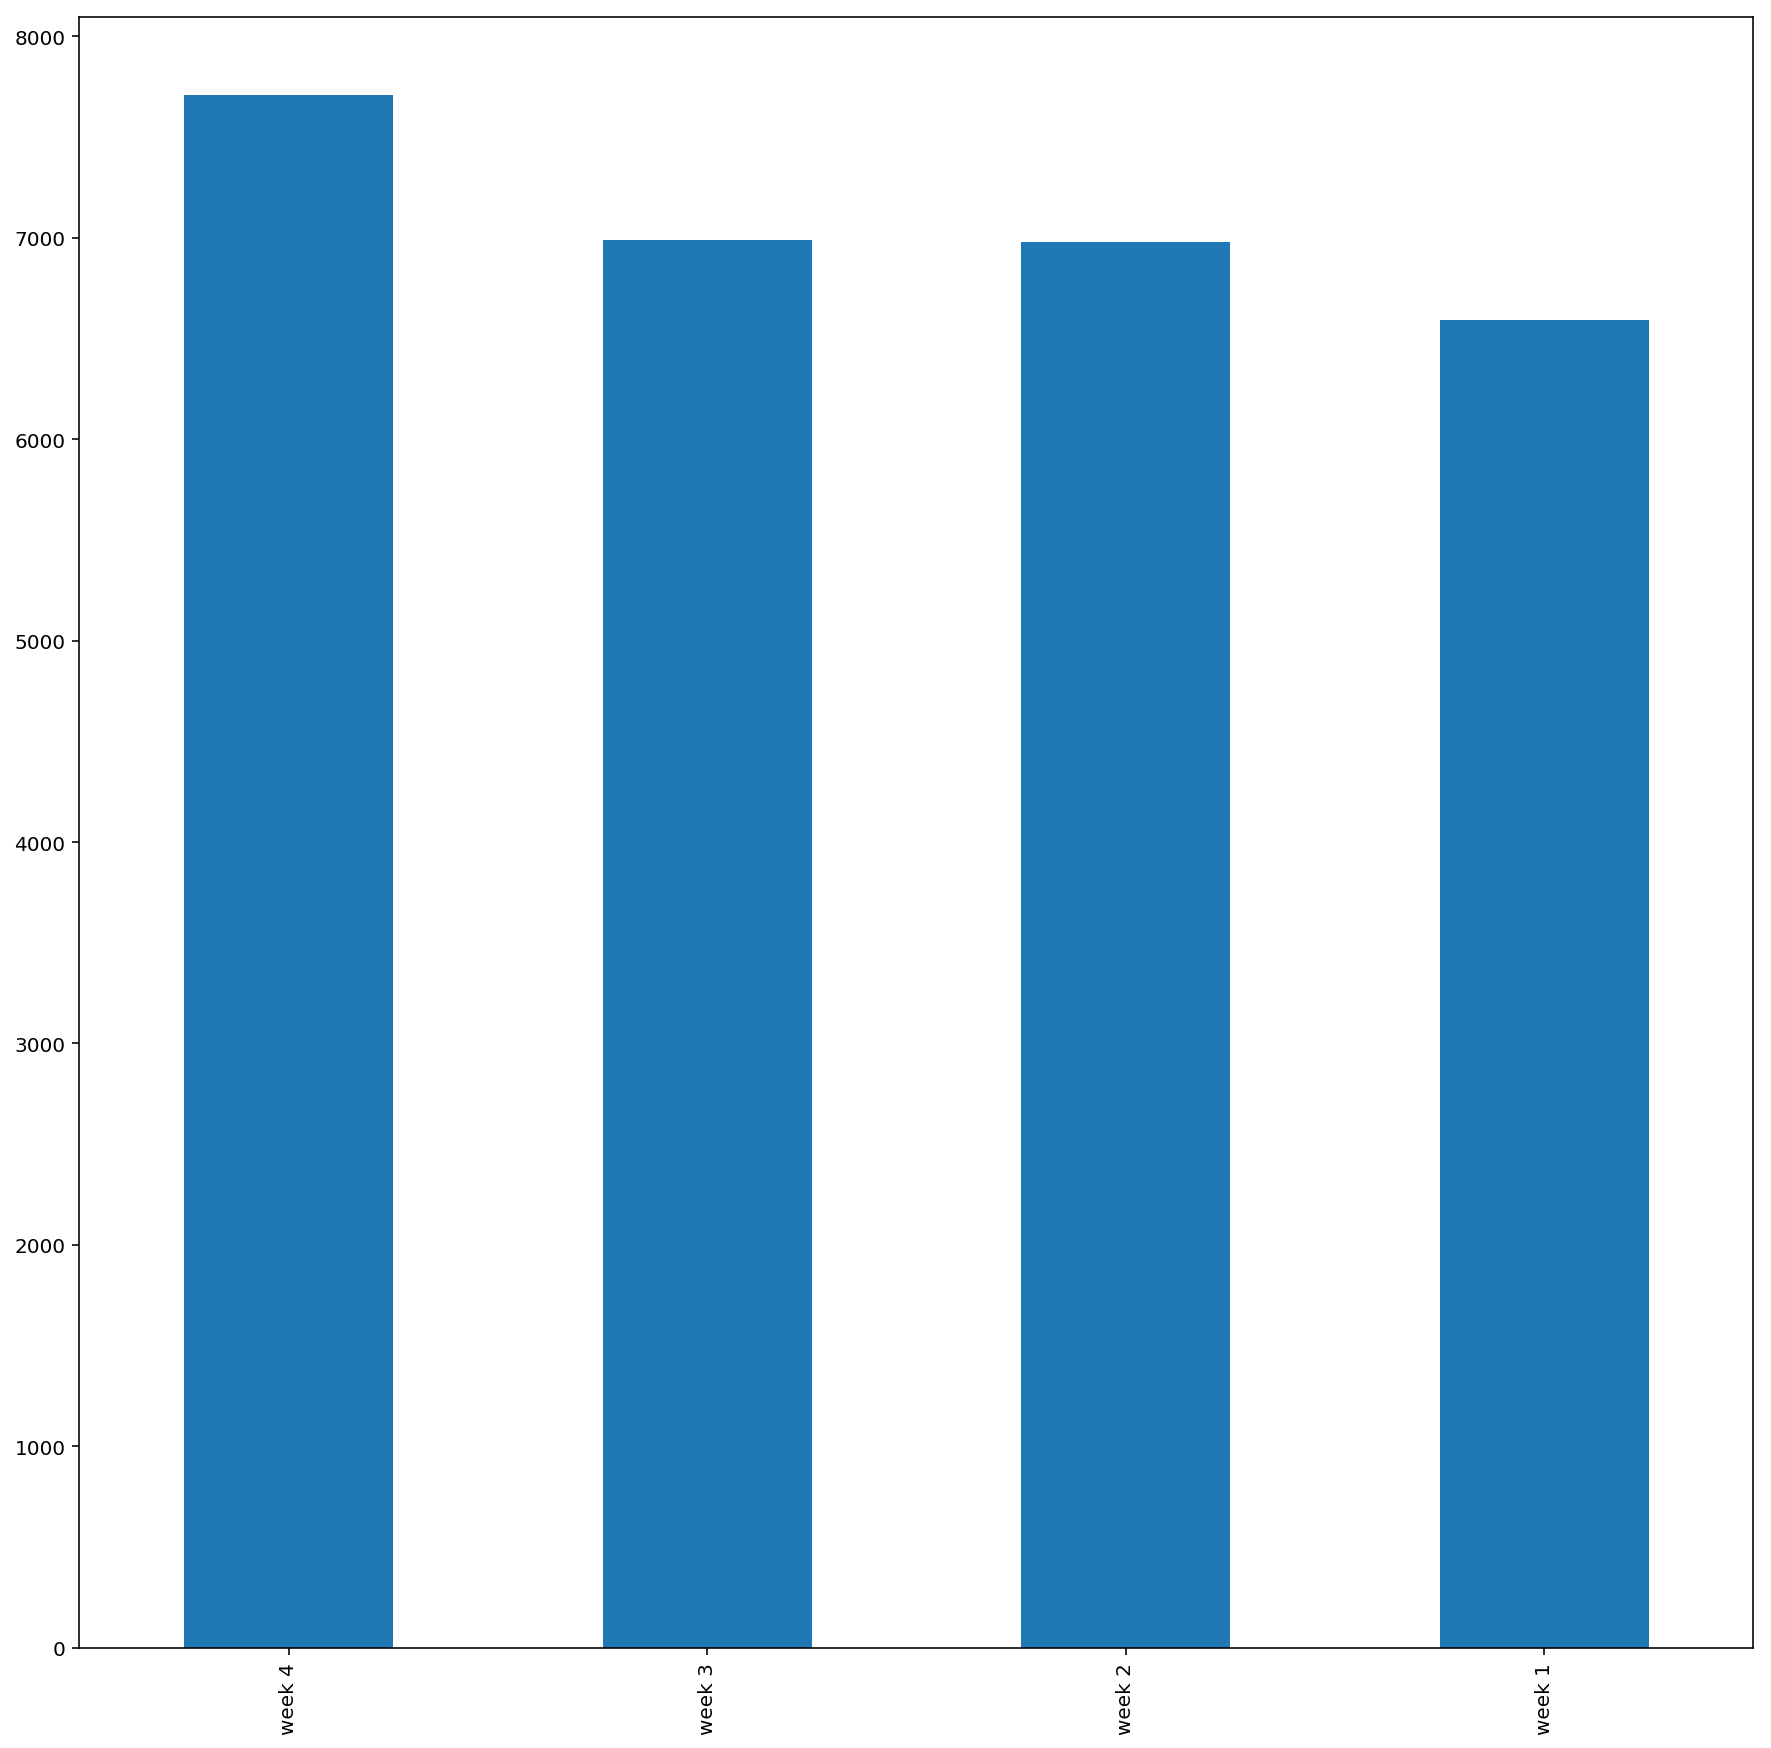

In [77]:
#week of month distribution

plt.figure(figsize = (15, 15))

all_t['week of month'].value_counts().plot(kind='bar')

Most orders in week 4 & 2

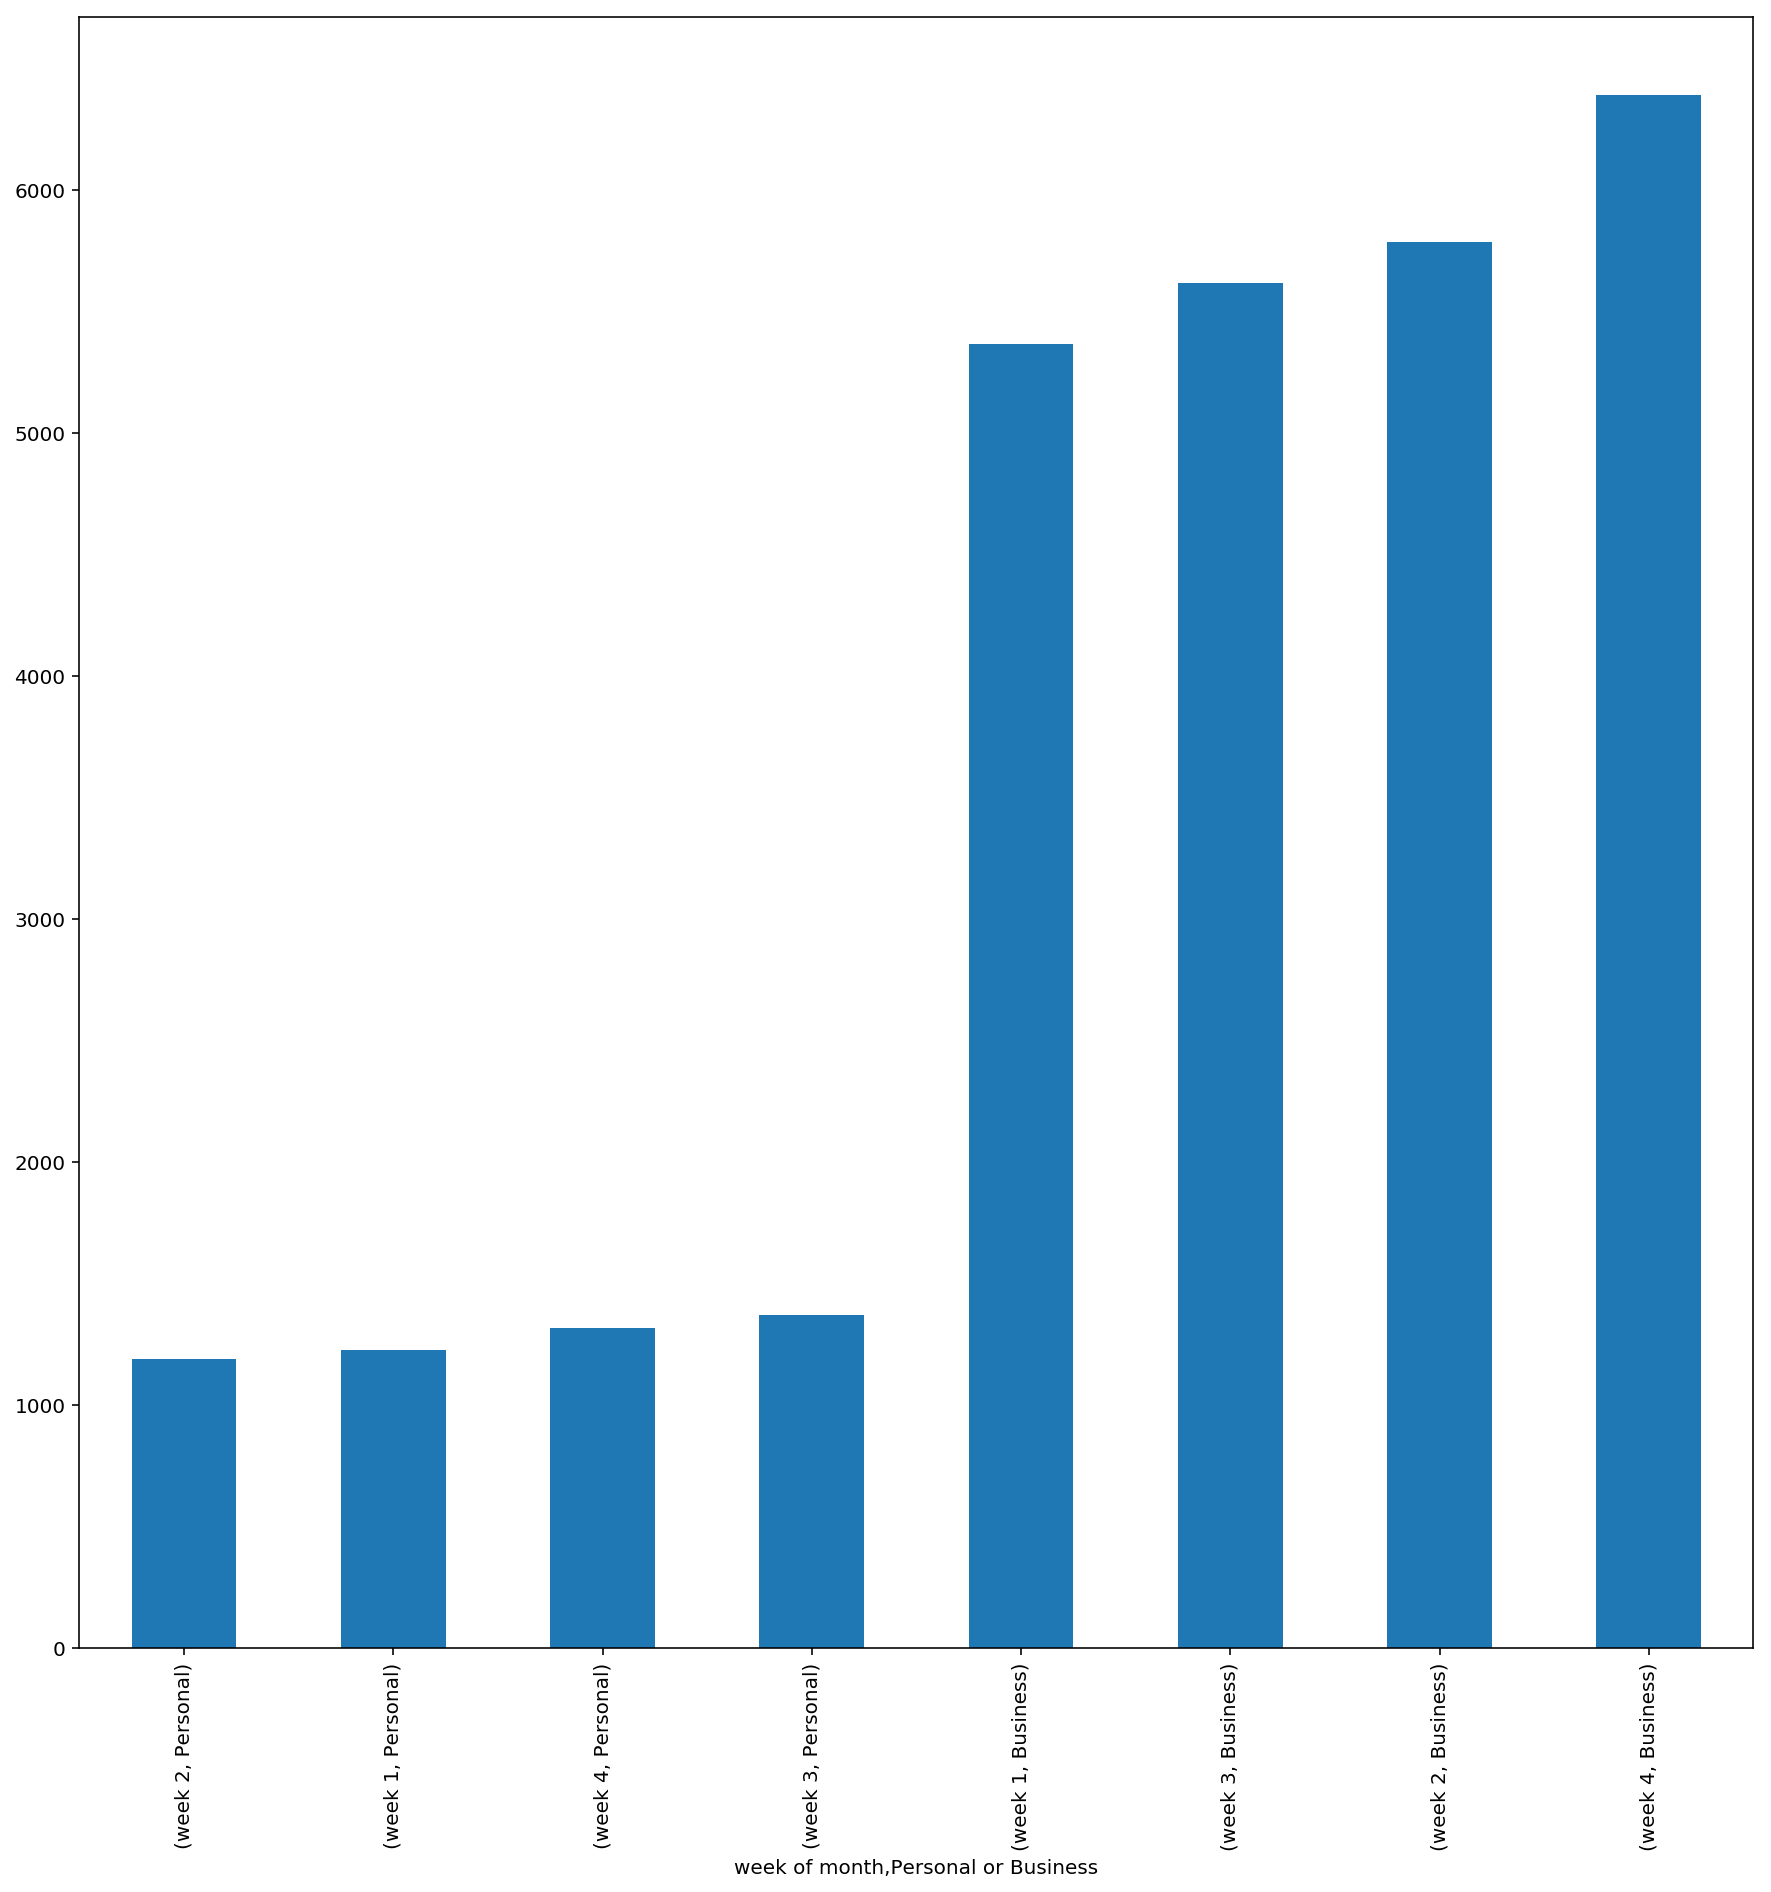

In [78]:
plt.figure(figsize = (15, 15))

all_t.groupby(['week of month'])['Personal or Business'].value_counts().sort_values().plot(kind='bar')

Business orders in week 1 & 2 are also predominant, but these orders are slower observed from Time of arrival chart above. This might be due to surge in orders too much to handle

Highest business orders in week 3 & 4, this might be an expected pattern for company, they might have planned after surge in week 1 & 2. Hence they deploy more riders for fast delivery since business orders in week 3 & 4 are quicker


In [79]:
#cross check pick time hour and arrival pick up hour are same

(all_t['pick time hour'].astype(int) - all_t['arrival pick time hour'].astype(int)).value_counts()


0    22430
1     5758
2       81
dtype: int64

It appears some orders are not same hour as arrival pick time and pick time

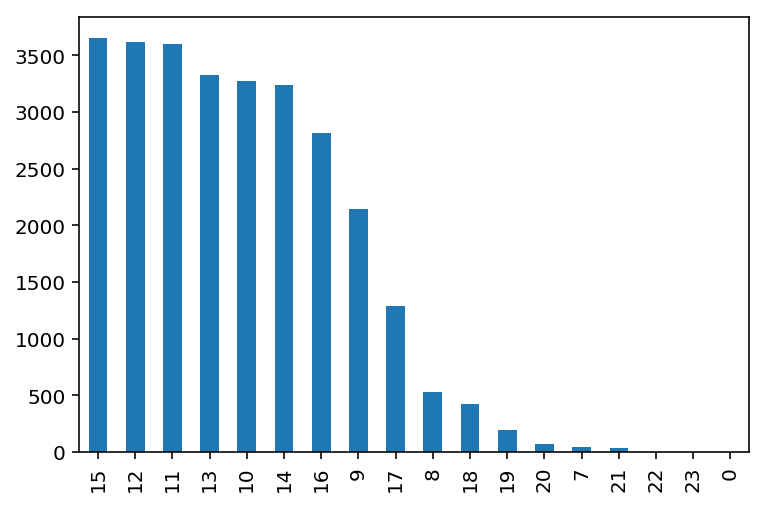

In [80]:
all_t['pick time hour'].value_counts().plot(kind='bar')

Few values within 21, 22, 23, & 0, Possibly that's inactivity time

Few values within 7, possibly that's rush hour time. Pacakges will be preferred to be delivered later in day

More values within 11-15, possibly this is generally work time. Traffic will be less

Few values for 9, 17. Possibly mild traffic during that time, hence fewer deliveries

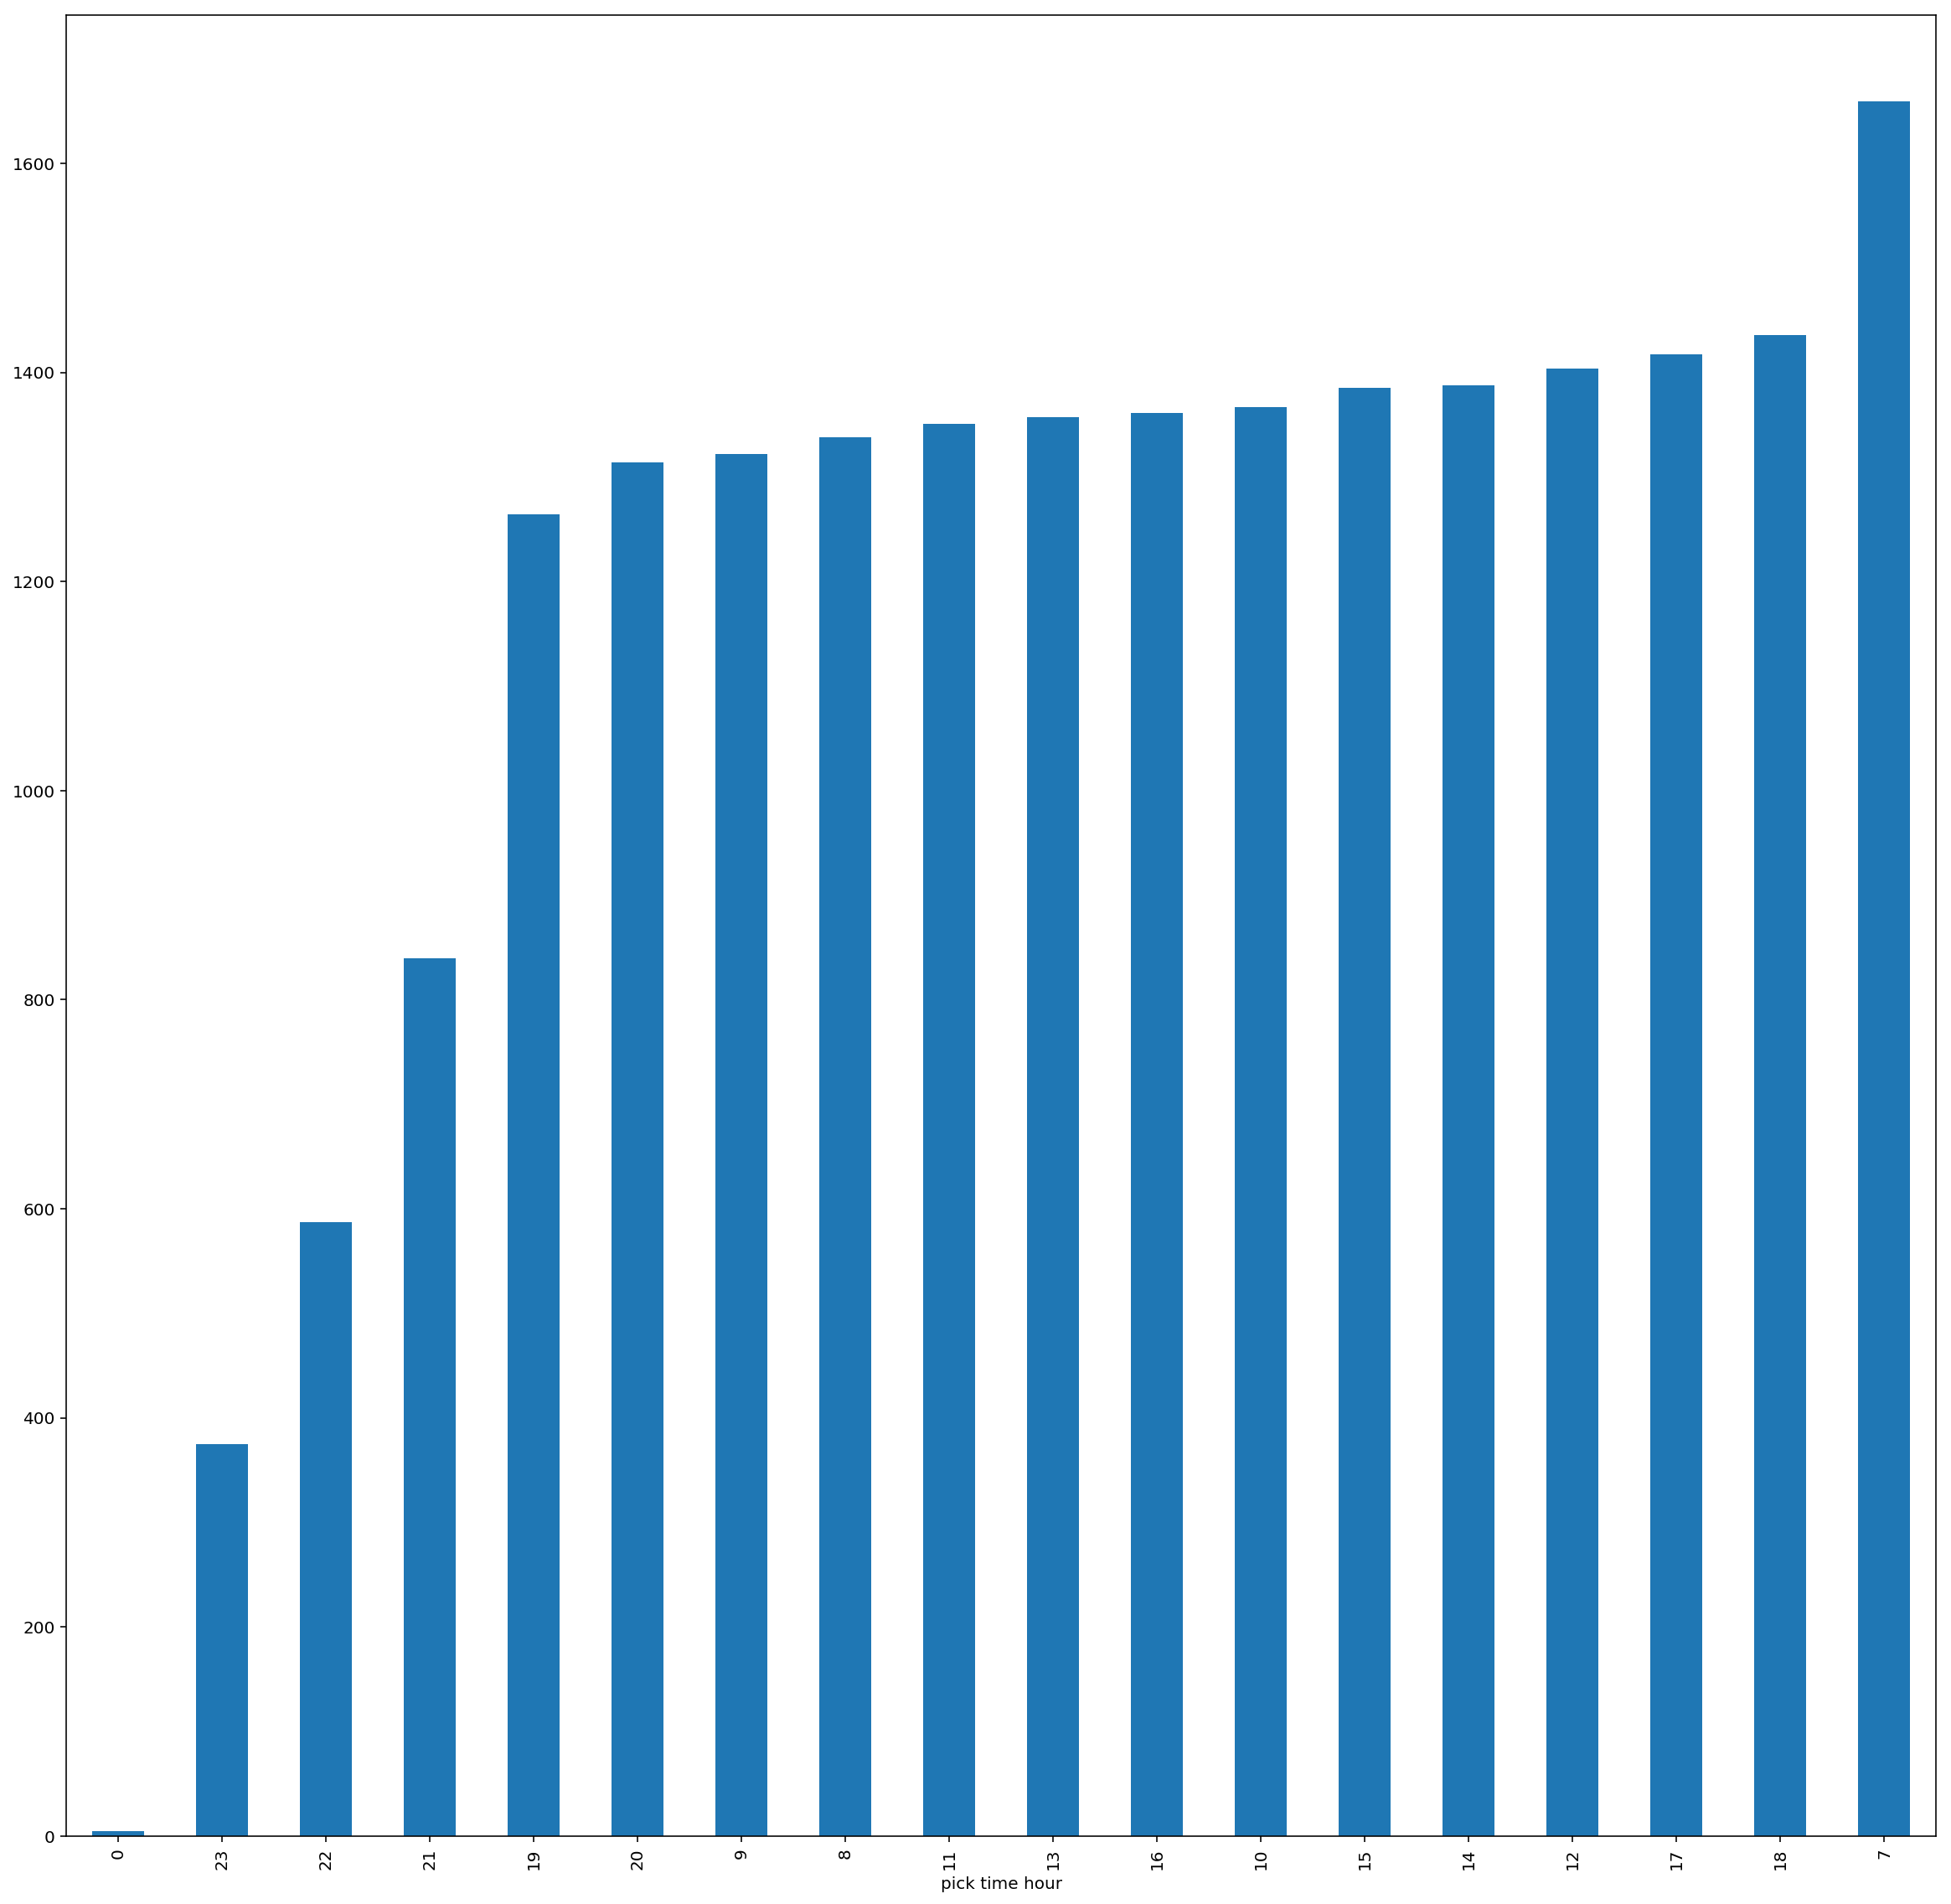

In [81]:
#Pick time hour Time from arrival range

plt.figure(figsize = (20, 20))

all_t_train.groupby(['pick time hour'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')

High delivery time by 7am (rush hour), somewhat high delievry time 17 & 18 possibly this is work close rush hour period(very predictive)(work close)

Slightly low delivery time between 19-21, maybe this is an inactive period after work 

Lowest delivery by 22-12am, since this is a general inactive period (very predictive)

Similar delivery time between 8- 4pm (neutral time)

Looking at value counts above, this is likely to be a weak feature, our most predictive models have very small frequency compared to neutral time

We will try augmenting hours into time brackets(rush hour, work close, neutral)

In [82]:
all_t_train  = all_t[all_t['identifier'] == 1]

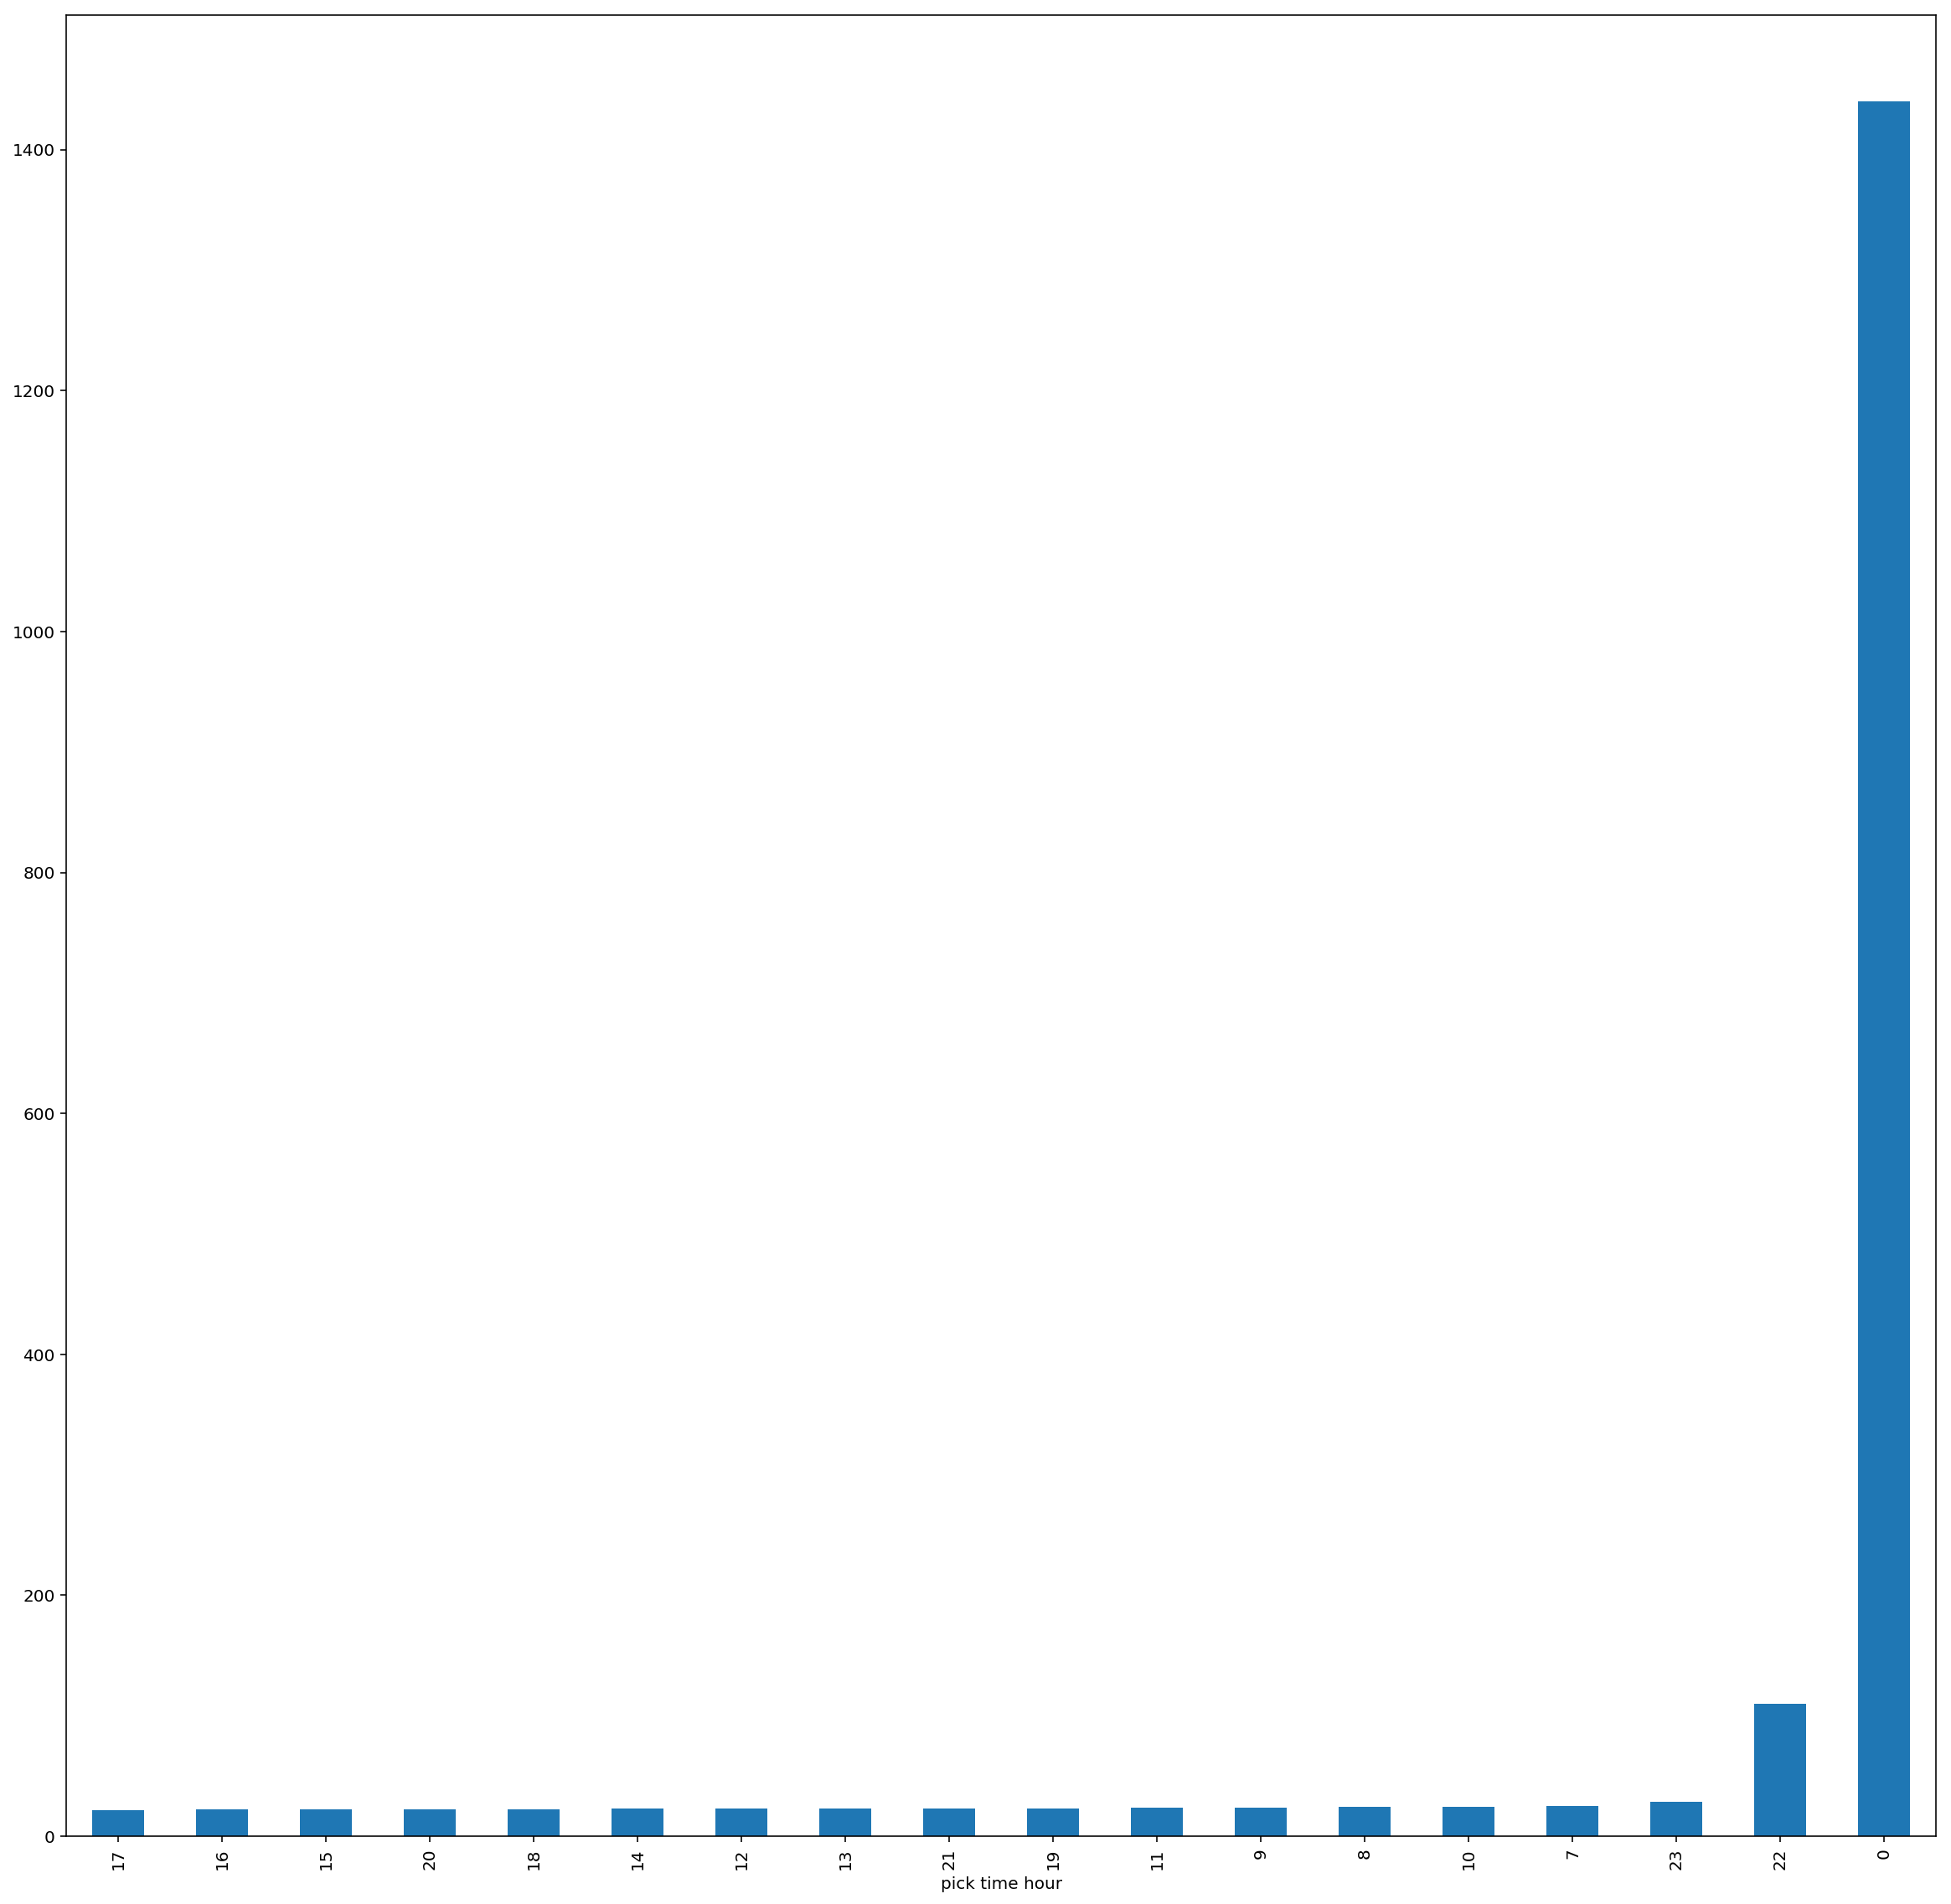

In [83]:
#Pick time hour Speed range

plt.figure(figsize = (20, 20))

all_t_train.groupby(['pick time hour'])['speed'].median().sort_values()\
.plot(kind = 'bar')



Outlier values at time 0, affecting Speed distribution

We will replot without outliers

In [84]:
all_t_train_s = all_t_train.copy()

#on average, 5 km trip should take 10 mins

all_t_train_s = all_t_train_s[~((all_t_train_s['Distance (KM)'] > 5 ) & (all_t_train_s['Time from Pickup to Arrival'] < 600))]

In [85]:
#function for hour brackets

def hour_of_day(df):
    
    if df in ['7']:
        
        return 'rush hour'
    
    elif df in ['0', '23', '22', '21']:
        
        return 'inactive hour'
    
    elif df in ['9', '8', '19', '20', '11', '13', '16', '10', '15', '14', '12']:
        
        return 'neutral'
    
    else:
        
        return 'work close'

In [86]:
#applying augment month_week fucntion

all_t['hour bracket'] = all_t['pick time hour'].apply(hour_of_day)

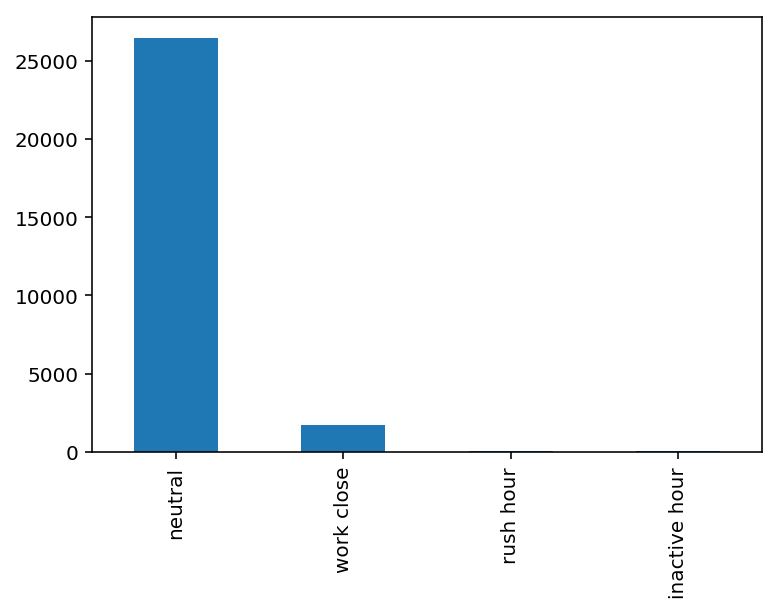

In [87]:
all_t['hour bracket'].value_counts().plot(kind = 'bar')

confirmed most predictive features with significant high or low time have smaller frequency

In [88]:
#resassign train data to reflect new feature

all_t_train = all_t[all_t['identifier'] == 1]

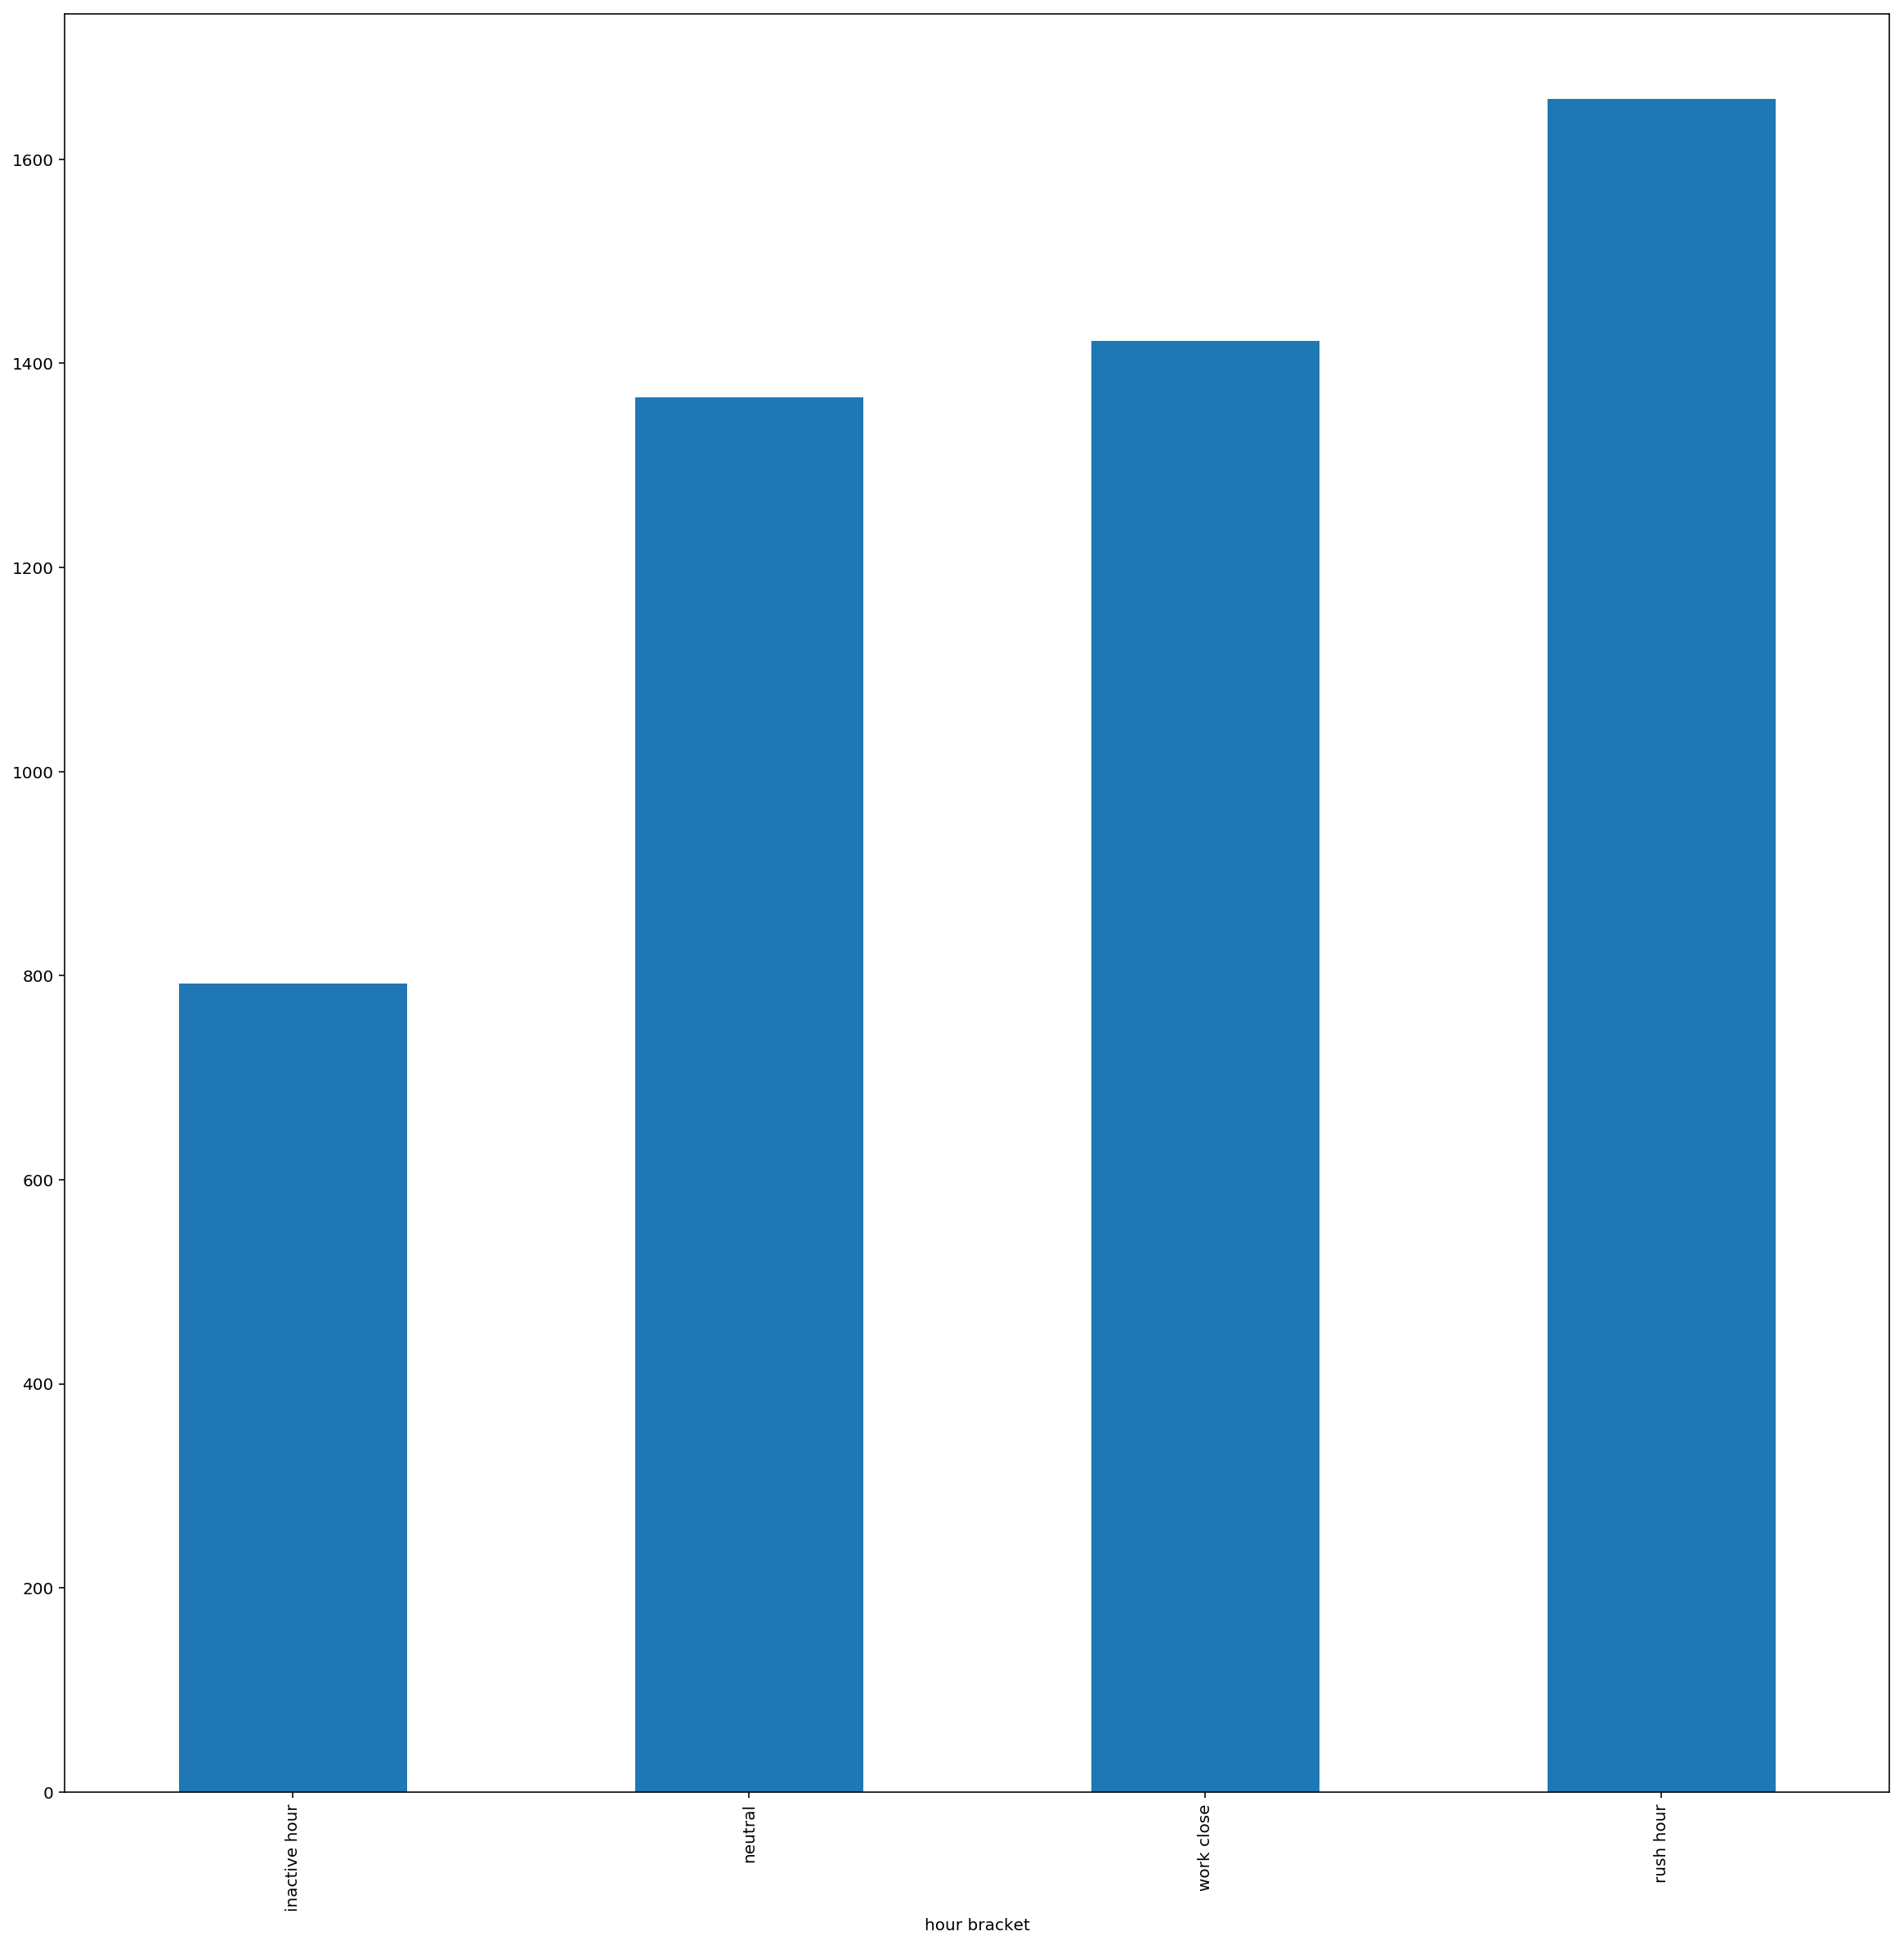

In [89]:
#Pick time hour Time from arrival range

plt.figure(figsize = (20, 20))

all_t_train.groupby(['hour bracket'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')

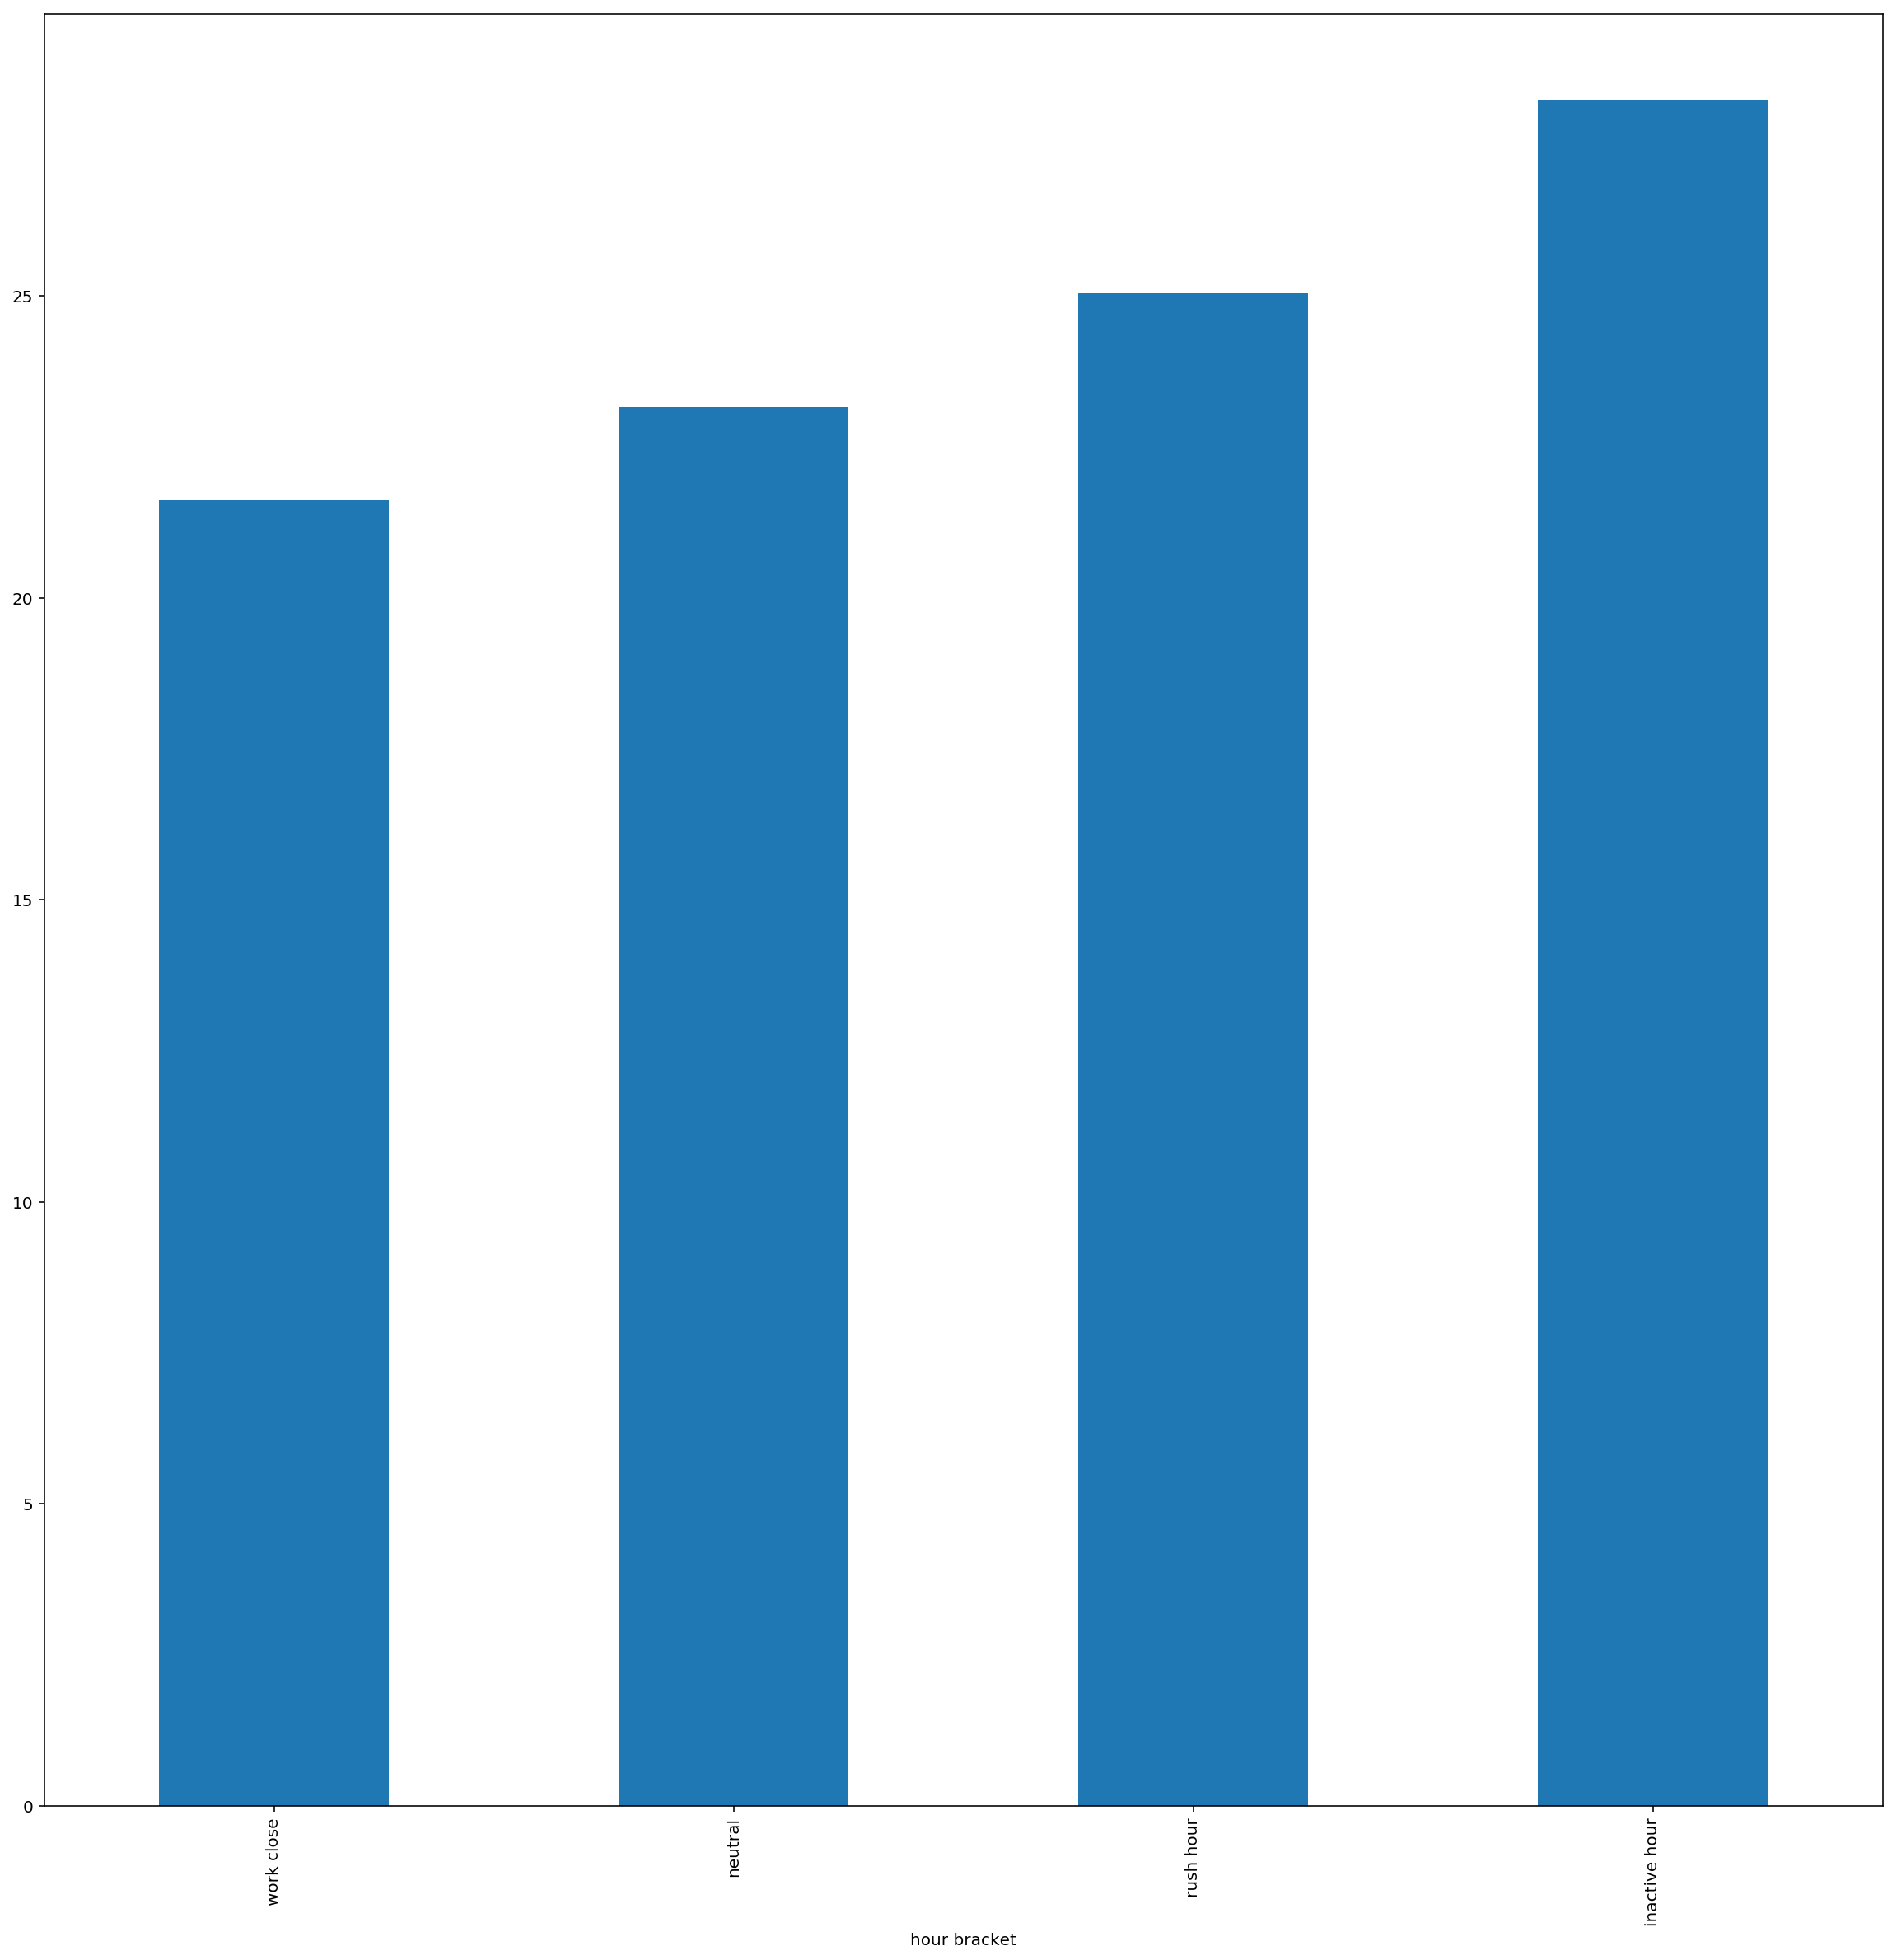

In [90]:
#Pick time hour speed range

plt.figure(figsize = (20, 20))

all_t_train.groupby(['hour bracket'])['speed'].median().sort_values()\
.plot(kind = 'bar')

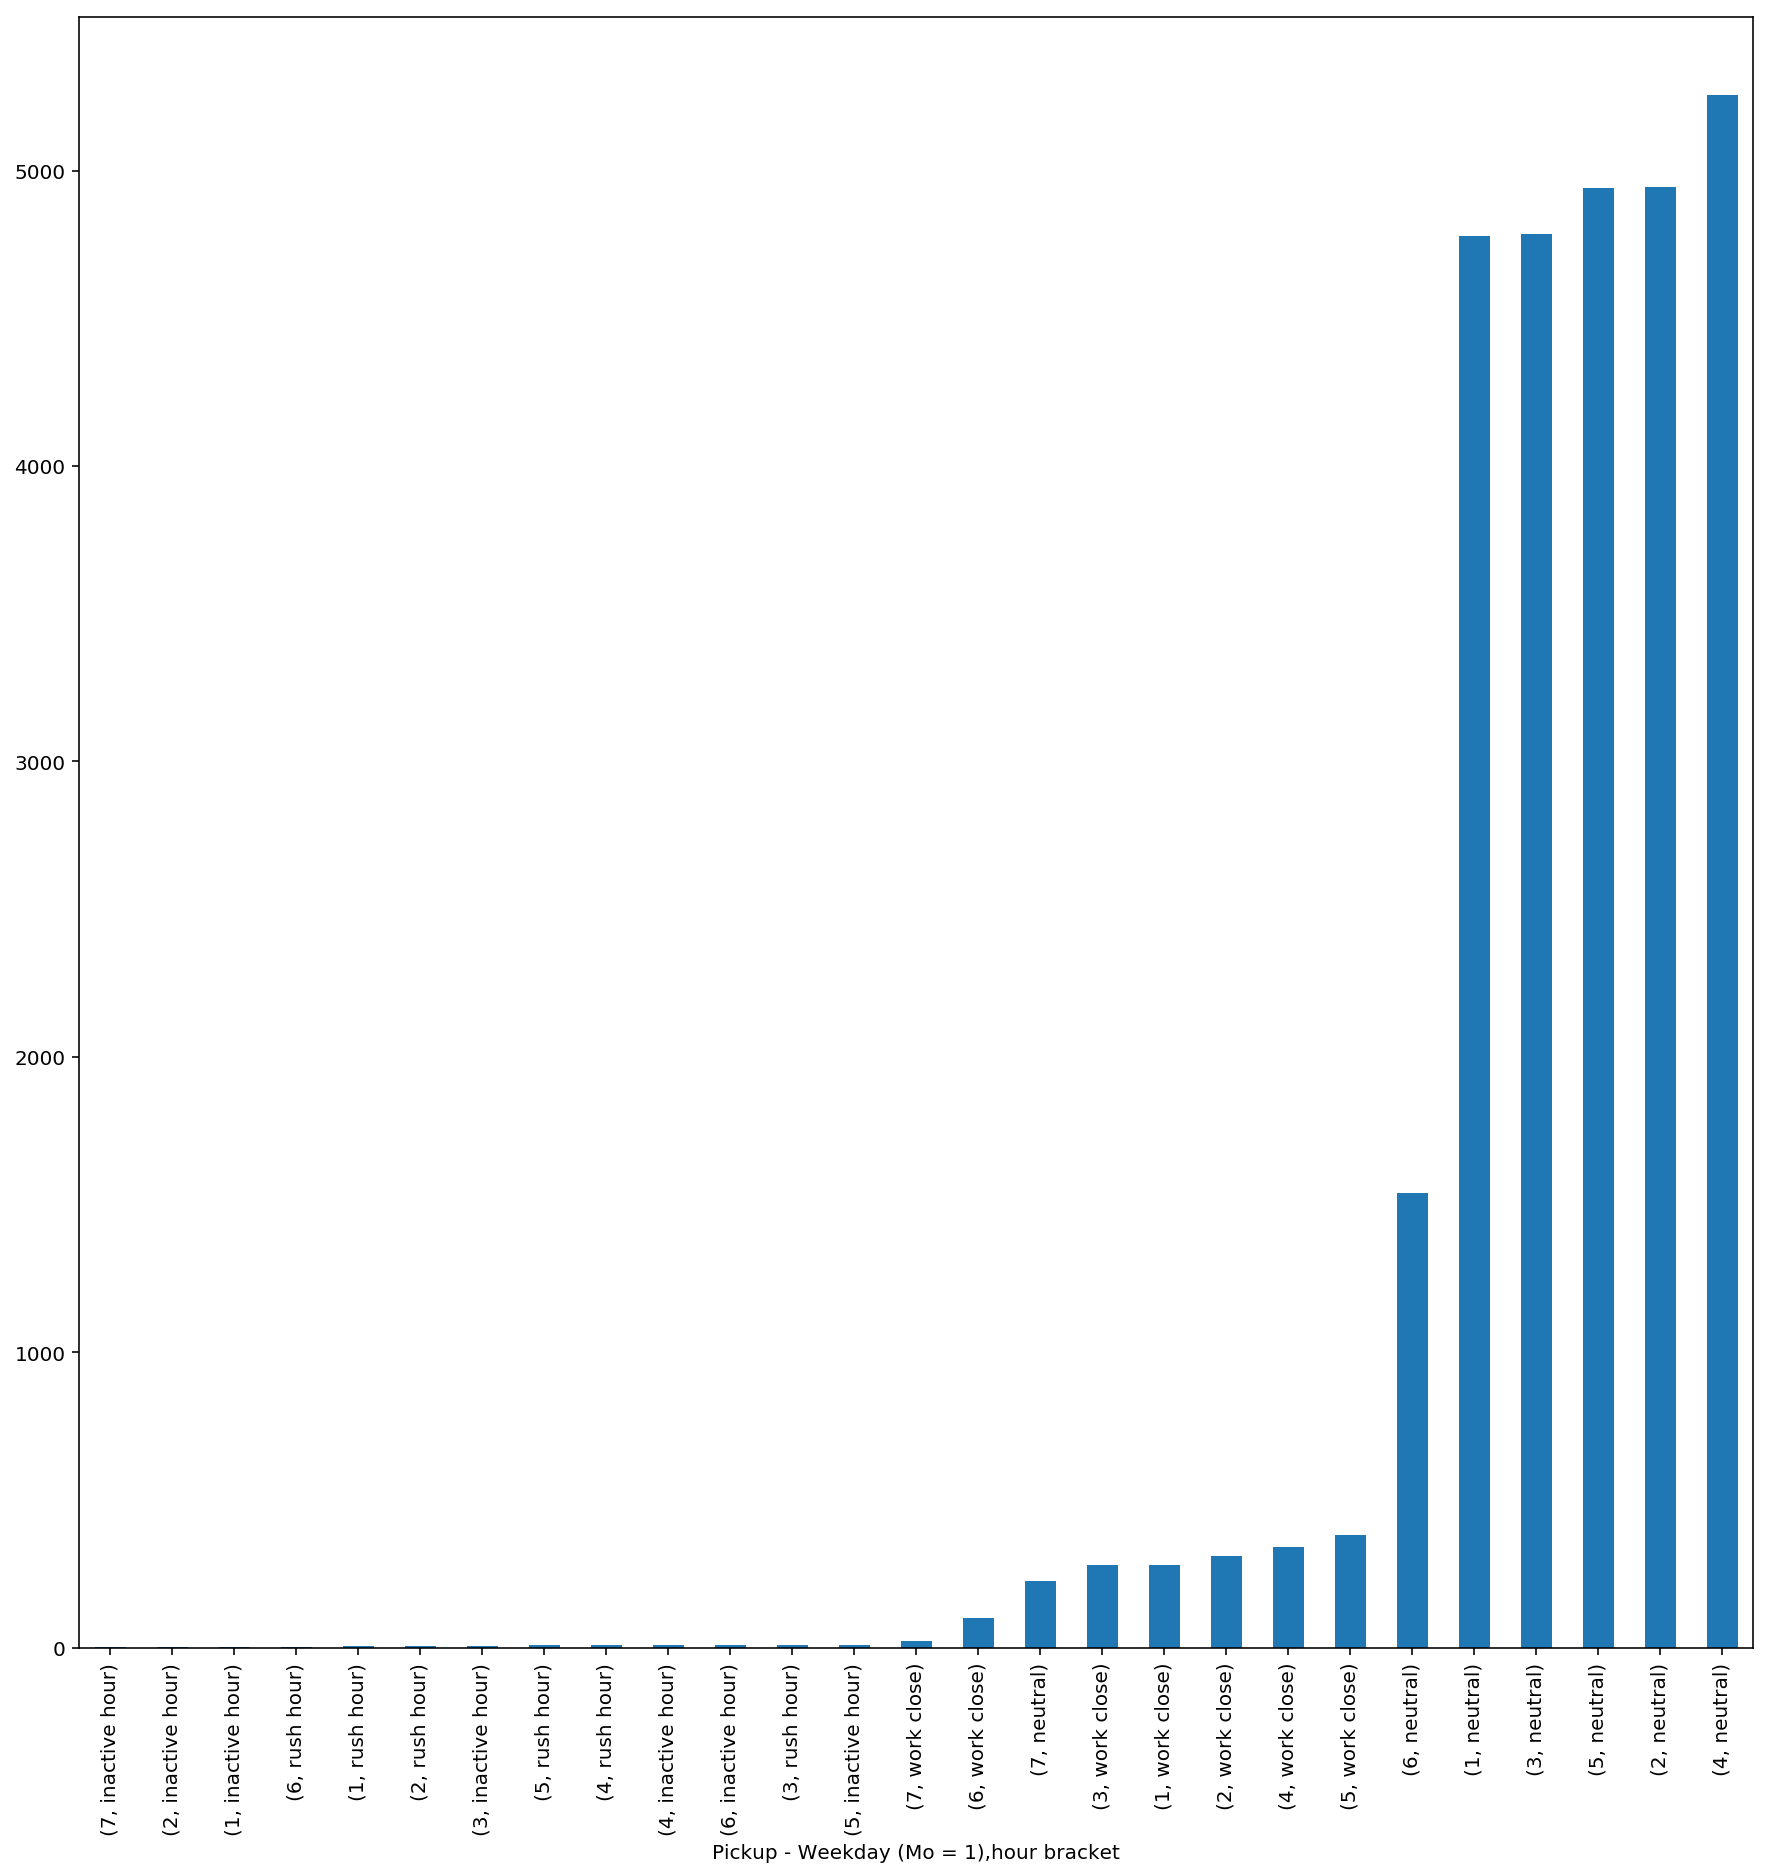

In [91]:
#visualize hour by weekday

plt.figure(figsize = (15, 15))

all_t.groupby(['Pickup - Weekday (Mo = 1)'])['hour bracket'].value_counts().sort_values().plot(kind='bar')

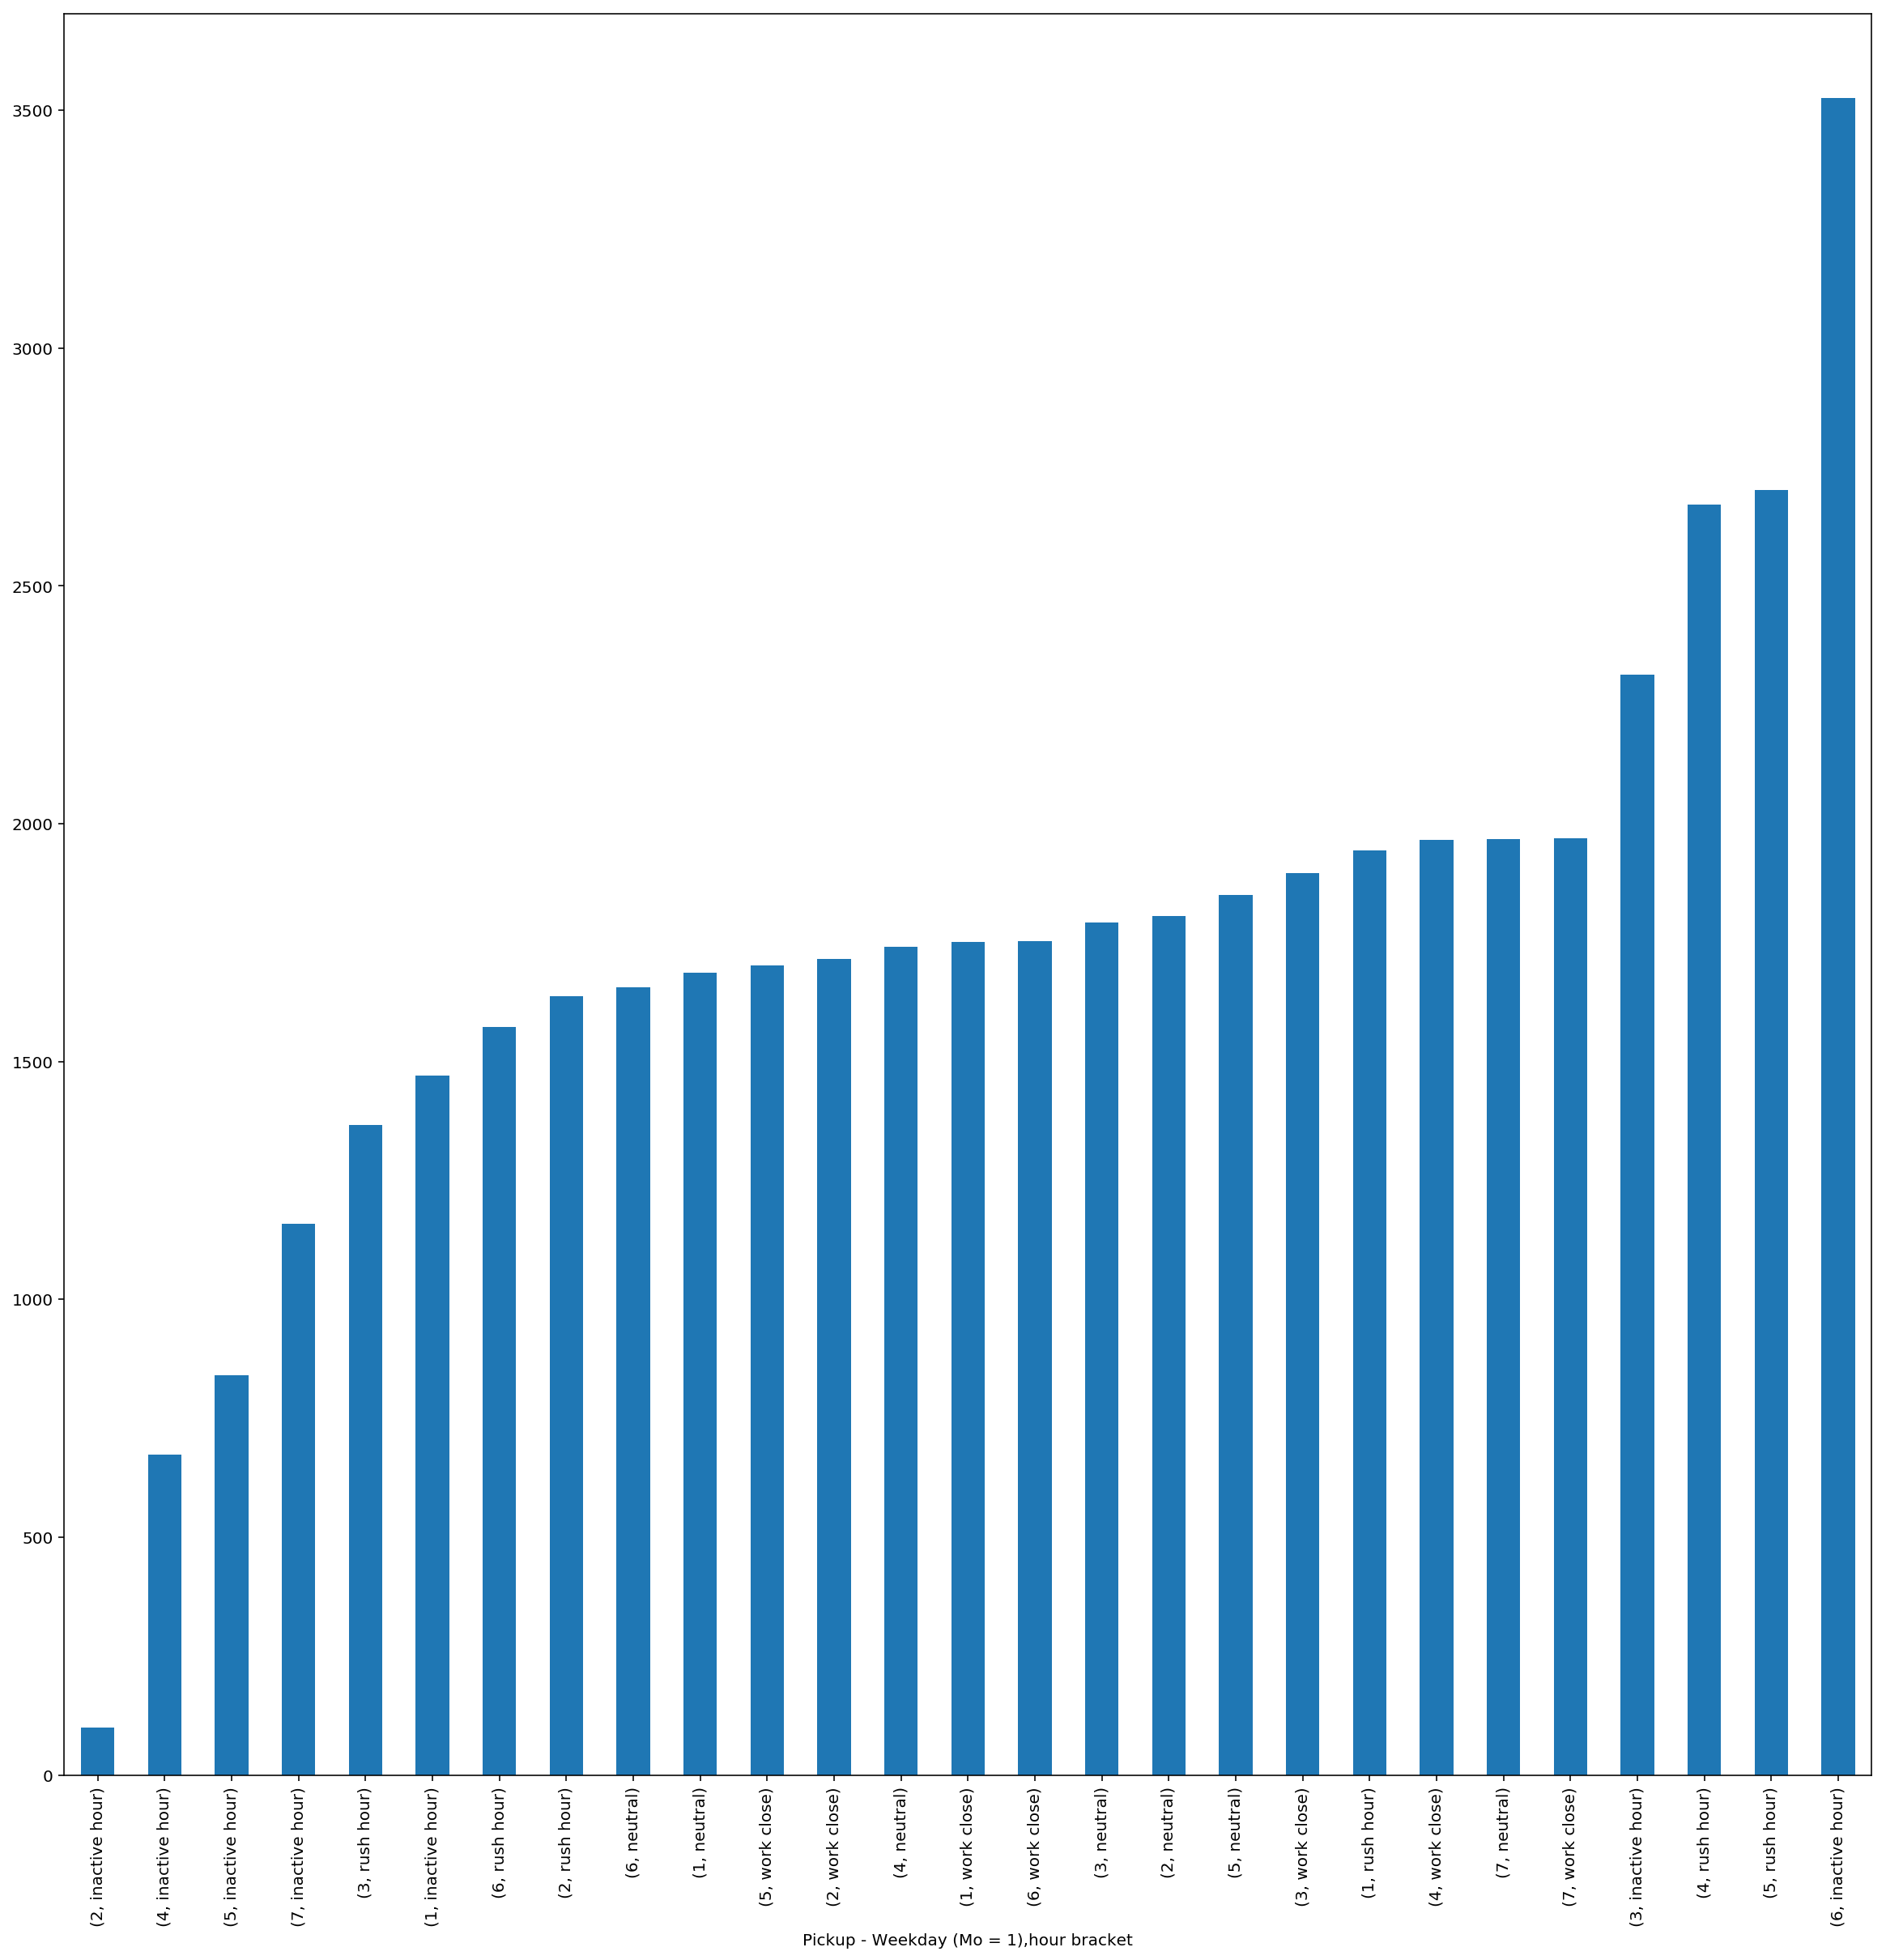

In [92]:
#visualize hour by weekday with Time

plt.figure(figsize = (20, 20))

all_t.groupby(['Pickup - Weekday (Mo = 1)', 'hour bracket'])['Time from Pickup to Arrival'].median().sort_values().\
plot(kind='bar')

In [93]:
# #Visualize hours where arrival pickup and pickup time don't match


# all_t['pick time hour'].astype(int) - all_t['arrival pick time hour'].astype(int)).value_counts()


# Numerical Features EDA

In [94]:
all_t.dtypes

Destination Lat                      float64
Destination Long                     float64
Distance (KM)                          int64
Order No                              object
Personal or Business                  object
Pickup - Day of Month                  int64
Pickup - Weekday (Mo = 1)              int64
Pickup Lat                           float64
Pickup Long                          float64
Platform Type                          int64
Rider Id                              object
Temperature                          float64
Time from Pickup to Arrival            int64
User Id                               object
identifier                             int64
No_Of_Orders                           int64
Age                                    int64
Average_Rating                       float64
No_of_Ratings                          int64
confirmation_placement_delta         float64
arrival pickup_confirmation delta    float64
pickup_arrival pickup_delta          float64
pick time 

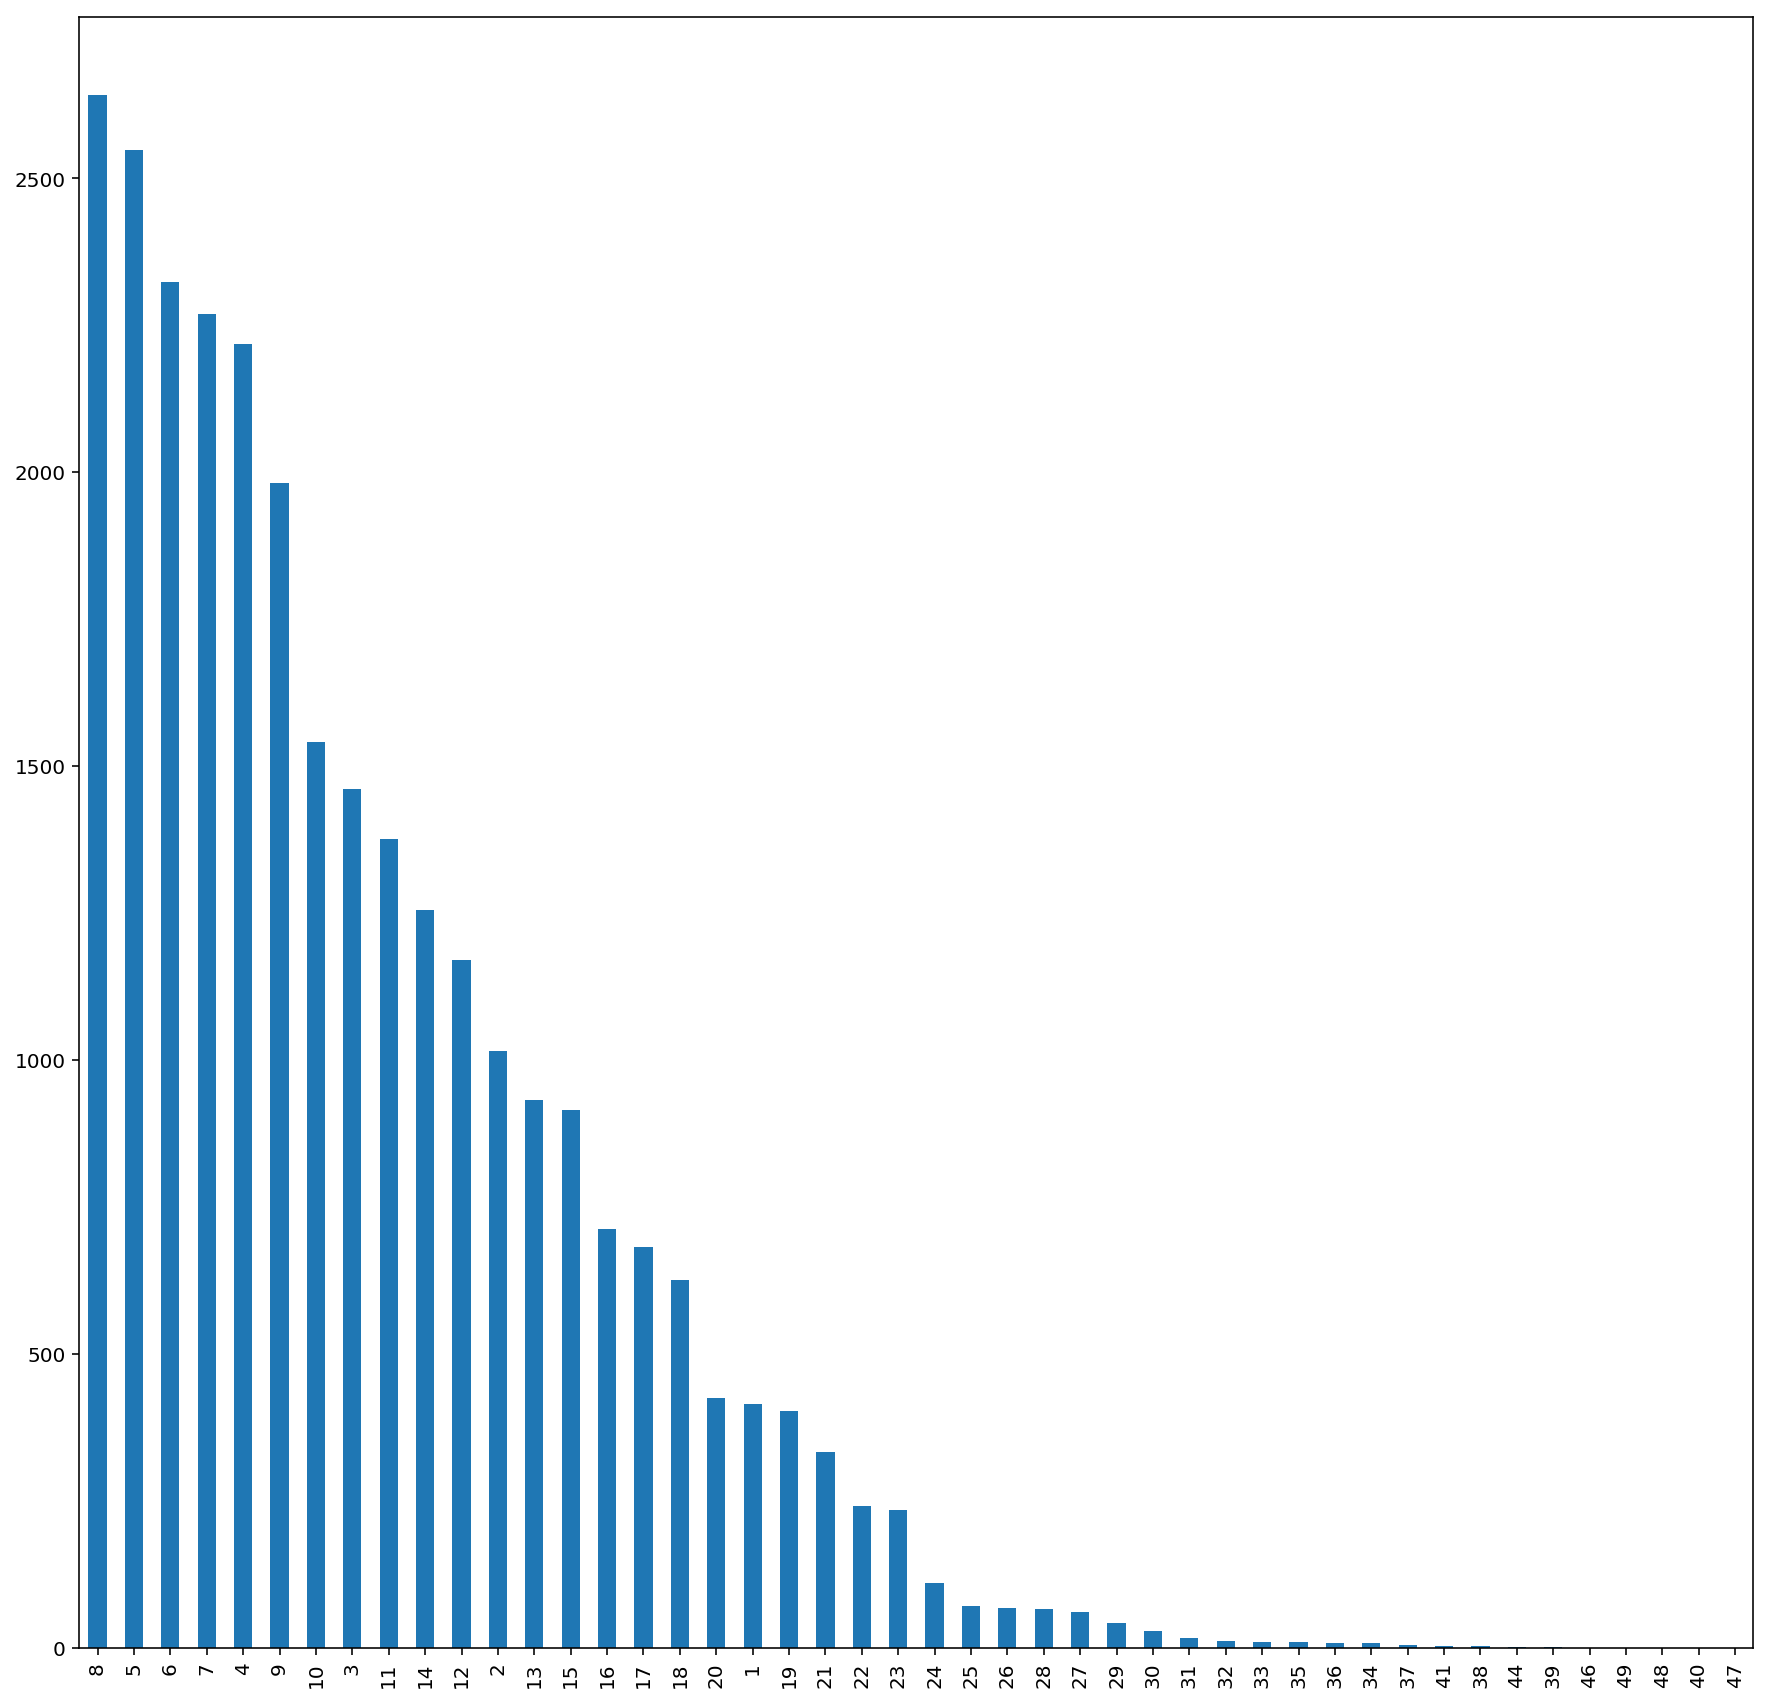

In [95]:
plt.figure(figsize = (15, 15))

all_t['Distance (KM)'].value_counts().plot(kind = 'bar')

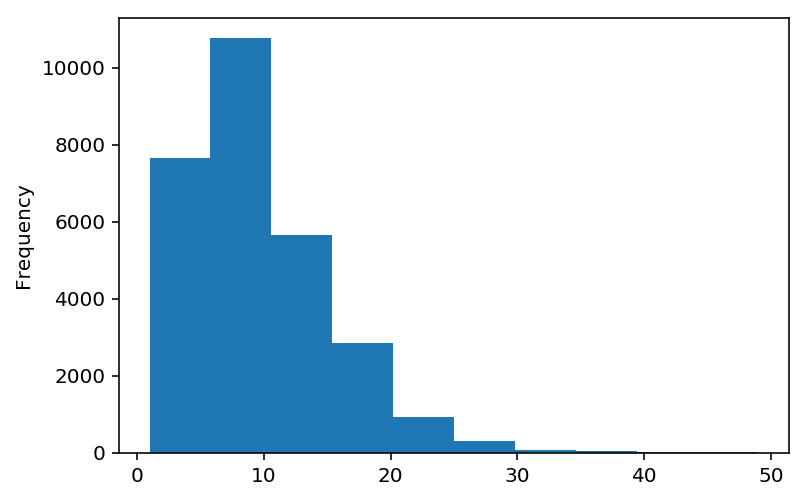

In [96]:
all_t['Distance (KM)'].plot(kind = 'hist')

- Write your observation 

Majority of data points for Distance are between 3 to 10KM with a few datapoints beyond 30, left skewed distribution

Possibly set Distance interval between 1 and 30Km

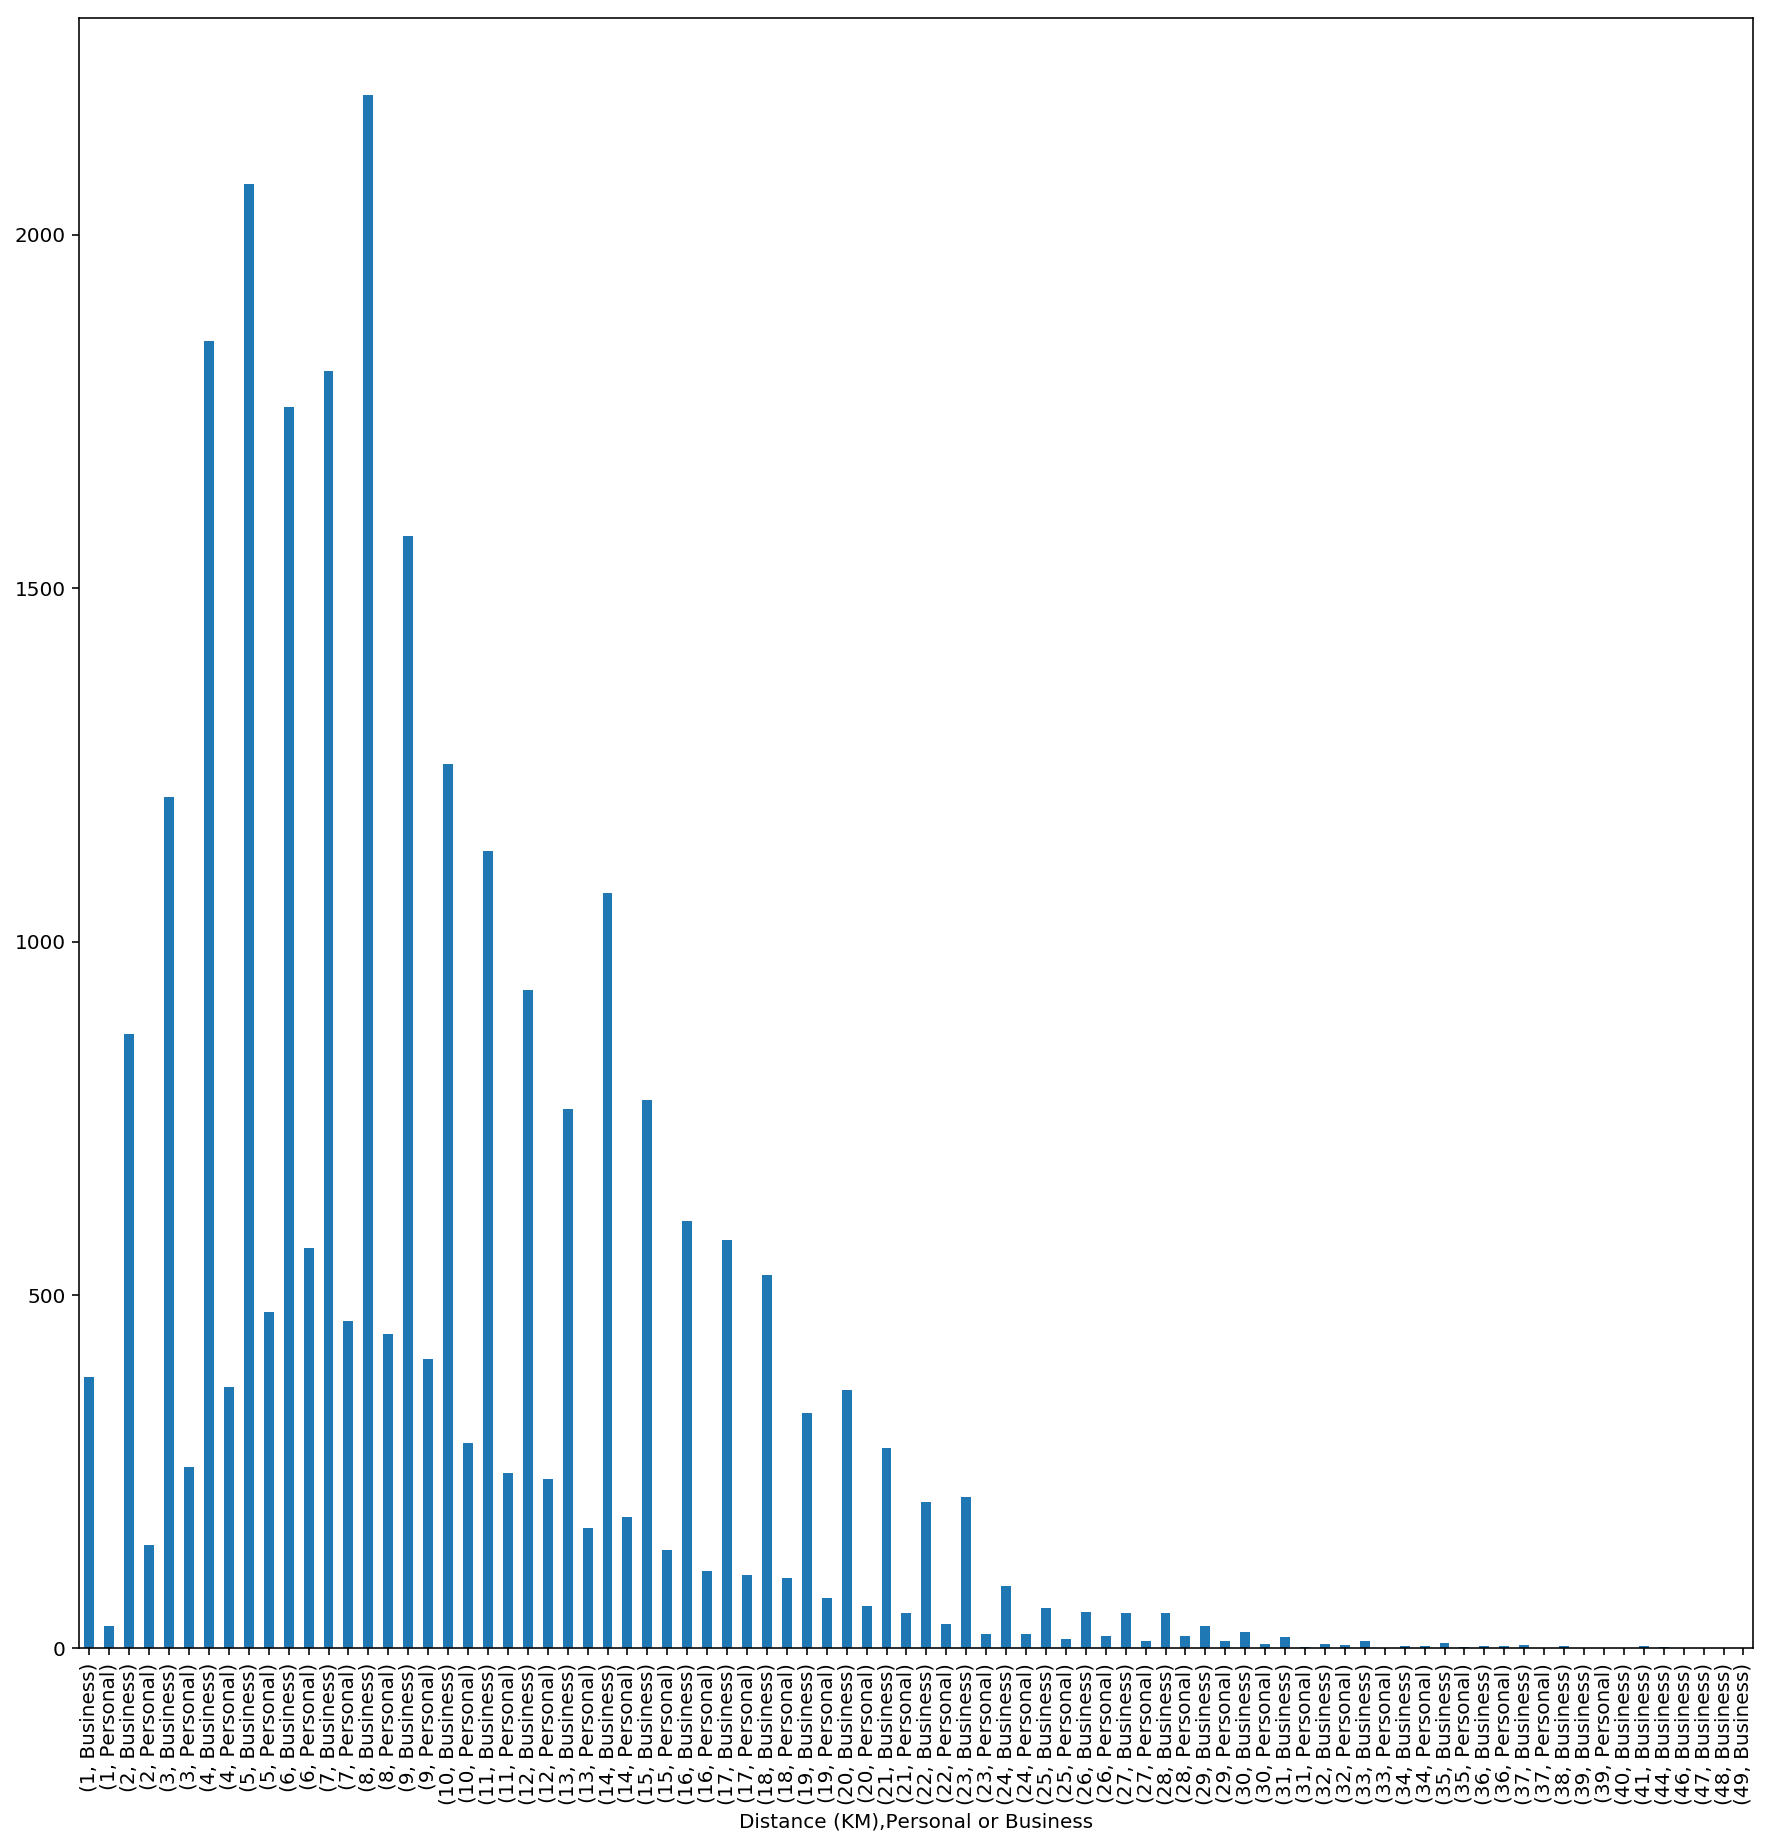

In [97]:
plt.figure(figsize = (15, 15))

all_t.groupby('Distance (KM)')['Personal or Business'].value_counts().plot(kind='bar')

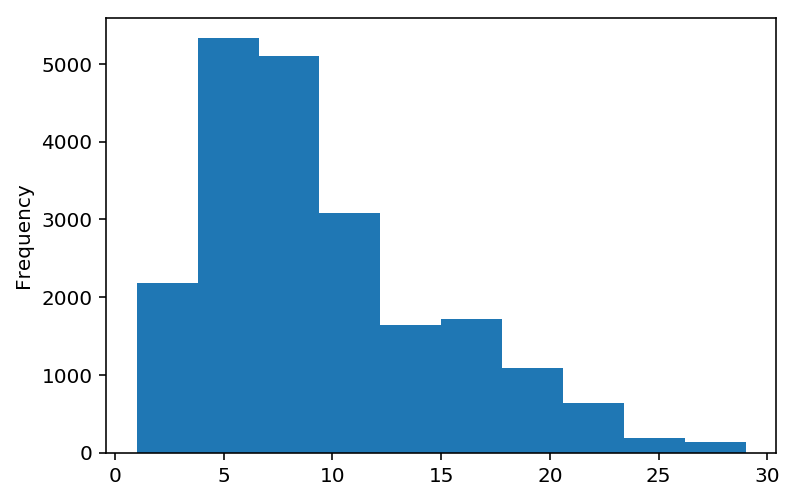

In [98]:
#Removing train set values where Distance < 30

all_t = all_t[(all_t['Distance (KM)'] < 30) & (all_t['identifier'] == 1)]

all_t['Distance (KM)'].plot(kind = 'hist')

In [99]:
#fixing types for all features

all_t.dtypes

all_t['Pickup - Day of Month'] = all_t['Pickup - Day of Month'].astype(str)

all_t['Pickup - Weekday (Mo = 1)'] = all_t['Pickup - Weekday (Mo = 1)'].astype(str)

all_t['Platform Type'] = all_t['Platform Type'].astype(str)

all_t['identifier'] = all_t['identifier'].astype(str)

In [100]:
#Extracting numeric columns for scatter plots

#dict for holding numeric columns

scatter =[]

for column in all_t.columns:
    
    if all_t[column].dtype != 'object':
        
        scatter.append(column)

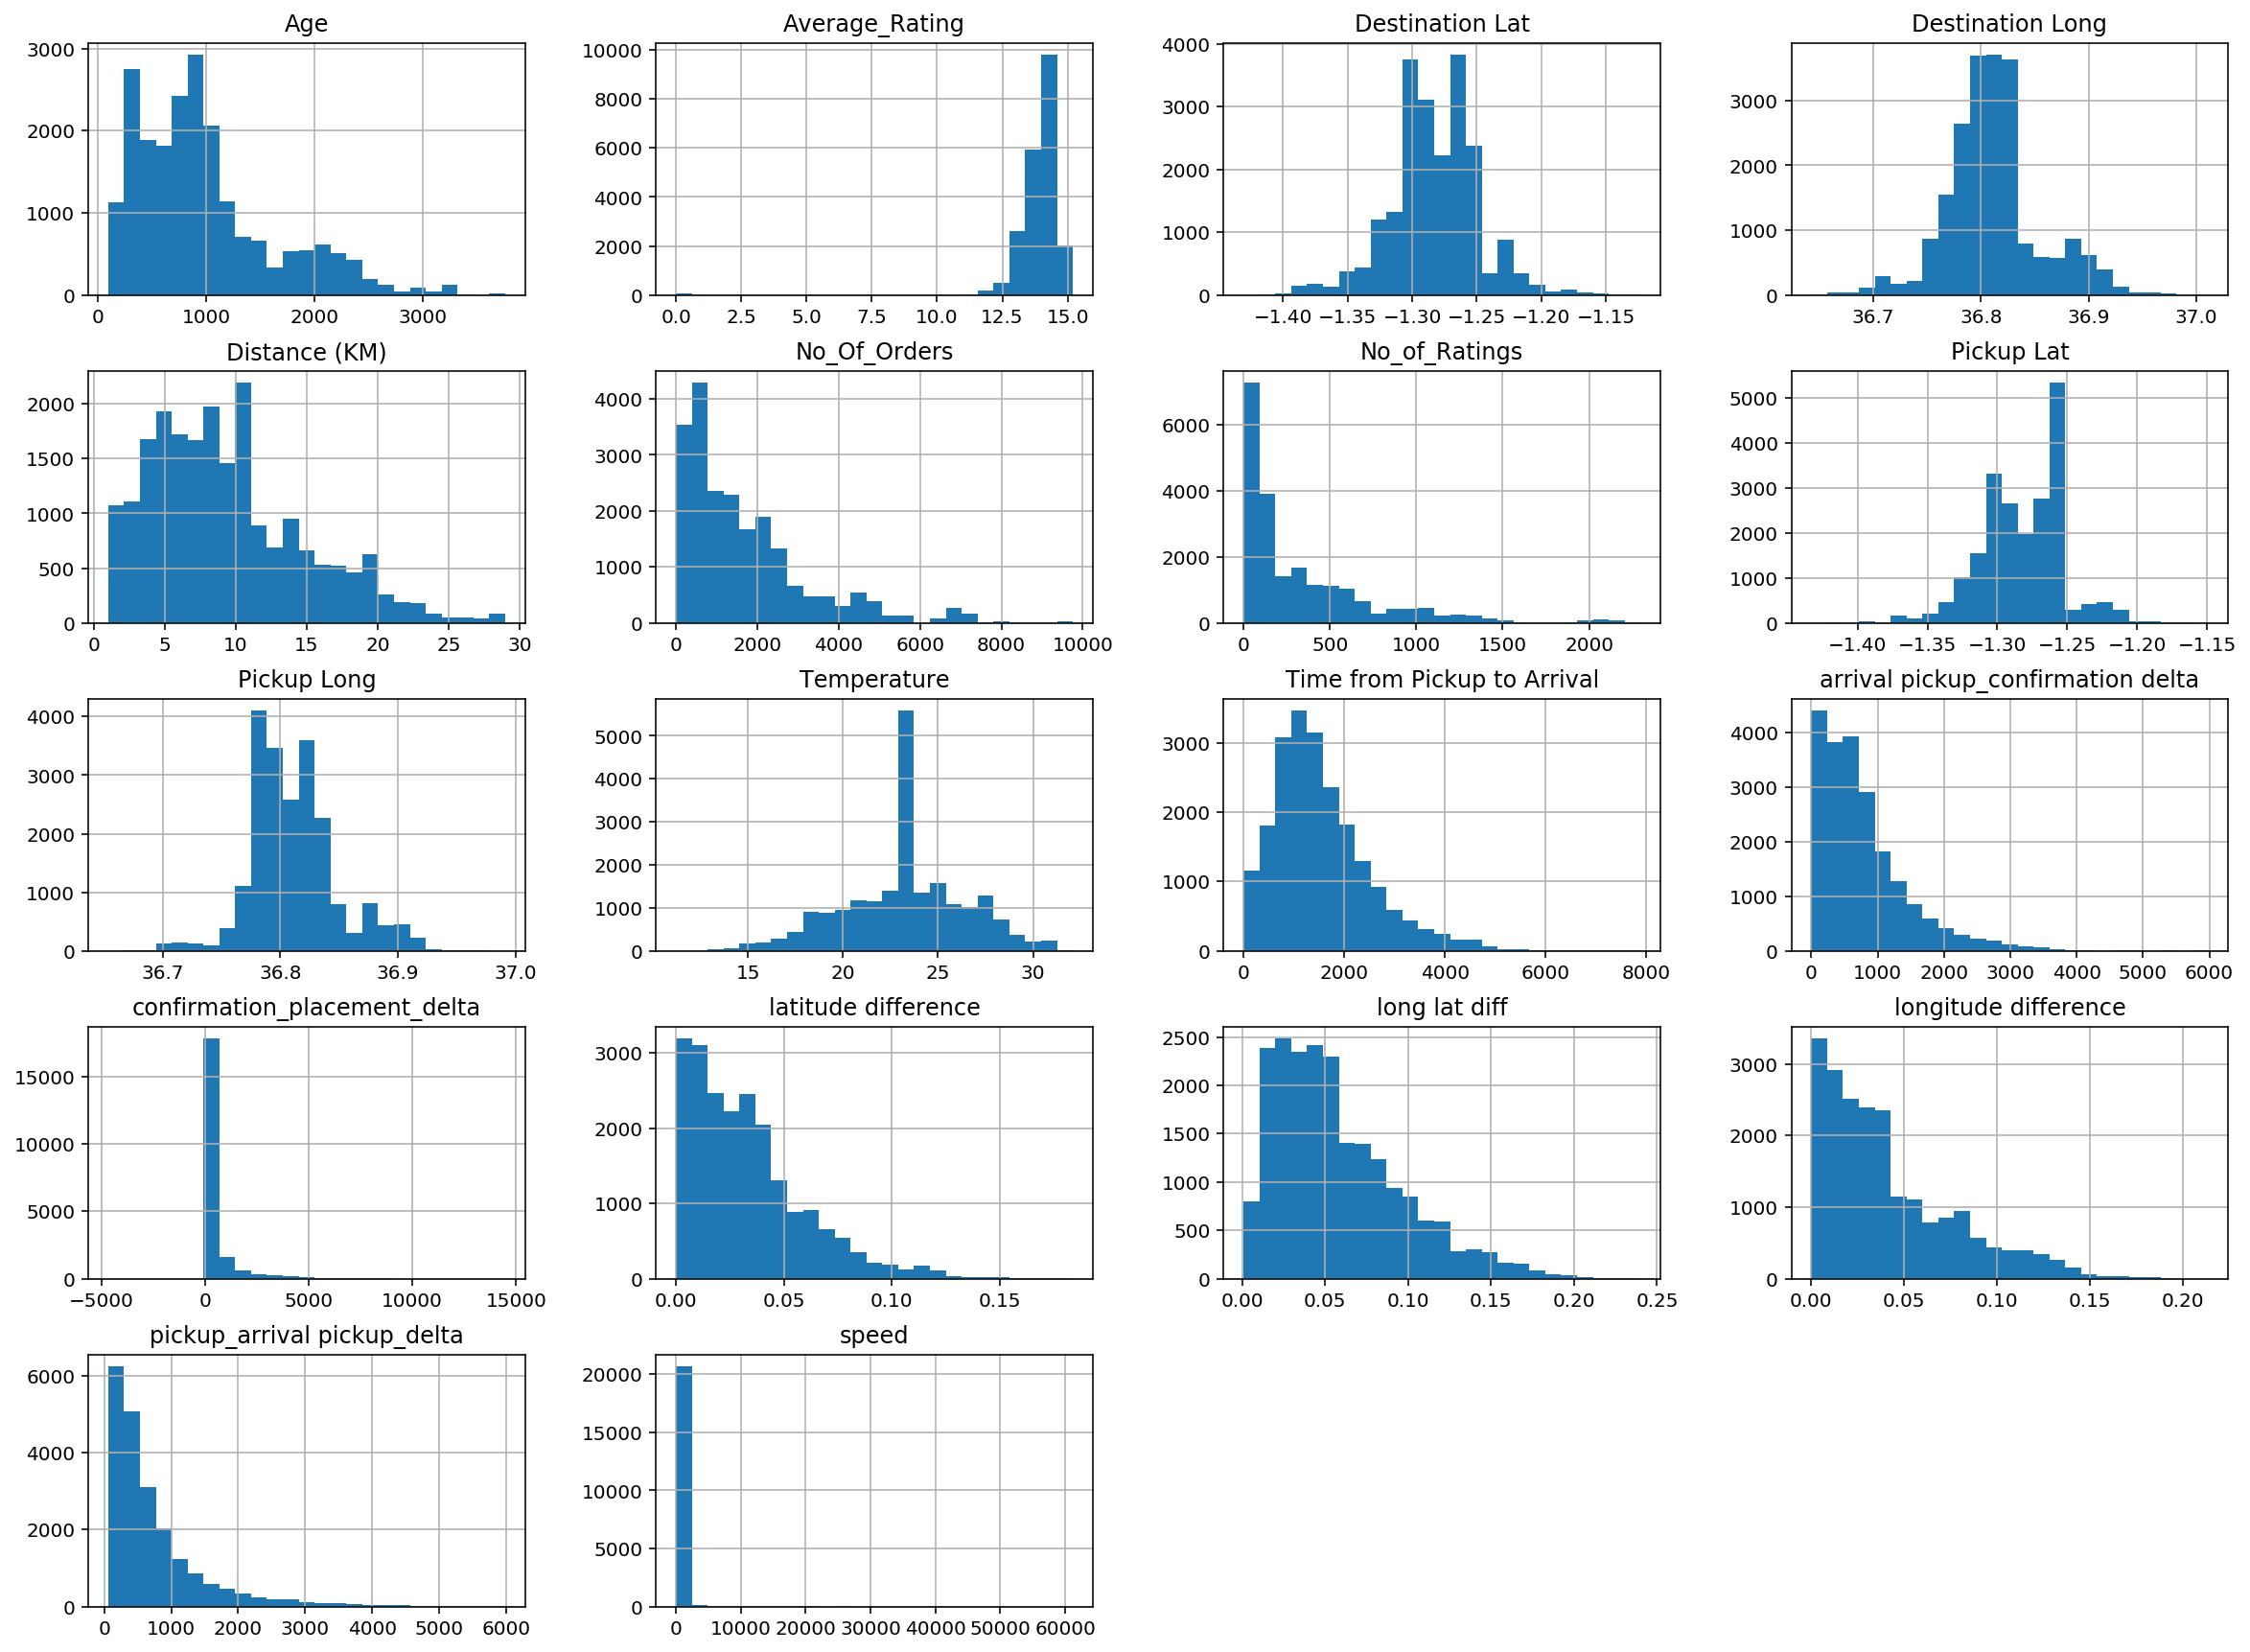

In [101]:
all_t[scatter].hist(bins = 25, figsize = (20, 15));

Age, No of Ratings, No_Of_Orders reflect simialr things showing the riders history over time- Can we just pick one feature ftom this instead of all the information. Maybe Age since most correlated with Time. Experiment with this

Can we create informative distance representations by grouping distance features in classes

Using hours for time and deltas will help the distribution instead of seconds

Temperature values are generally within 23-25, check distribution of Temperature ranges with Time




In [102]:
all_t.columns

Index(['Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Platform Type', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'identifier', 'No_Of_Orders',
       'Age', 'Average_Rating', 'No_of_Ratings',
       'confirmation_placement_delta', 'arrival pickup_confirmation delta',
       'pickup_arrival pickup_delta', 'pick time hour',
       'arrival pick time hour', 'latitude difference', 'longitude difference',
       'long lat diff', 'speed', 'week of month', 'hour bracket'],
      dtype='object')

In [103]:
#comparing number of orders to Age on platform & ratings to order to understand if repeat repeat orders or more ratings to order 

#correlates with good delivery time

all_t['order/Age'] = all_t['No_Of_Orders'] / all_t['Age']

all_t['Ratings/order'] = all_t['No_of_Ratings'] / all_t['No_Of_Orders']

all_t_train = all_t[all_t['identifier'] == '1']

In [104]:
pd.DataFrame(all_t_train.groupby('Ratings/order')['Time from Pickup to Arrival'].median()).reset_index().head()

,Ratings/order,Time from Pickup to Arrival
0,0.000000,1803.0
1,0.006923,2181.0
2,0.010755,1796.0
3,0.011429,1615.0
4,0.012624,1107.5


In [105]:
all_t_train['Ratings/order'].corr(all_t_train['Time from Pickup to Arrival'])


0.011214996706571794

In [106]:
all_t_train['order/Age'].corr(all_t_train['Time from Pickup to Arrival'])

-0.049231176504495294

# Creating Distance brackets as features

In [107]:
all_t_train['Distance (KM)'].describe()

count    21114.000000
mean         9.407123
std          5.458447
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         29.000000
Name: Distance (KM), dtype: float64

In [108]:
#function for week of month

def augment_dist_brackets(df):
    
    if df in list(range(1, 6)):
        
        return 'dist 1-5'
    
    elif df in list(range(6, 11)):
        
        return 'dist 6-10'
    
    elif df in list(range(11, 16)):
        
        return 'dist 11-15'
    
    elif df in list(range(16, 21)):
        
        return 'dist 16-20'
    
    elif df in list(range(21, 26)):
        
        return 'dist 21-25'
    
    else:
        
        return 'dist > 25'
    
    

In [109]:
#applying augment month_week fucntion

all_t['dist bracket'] = all_t['Distance (KM)'].apply(augment_dist_brackets)

In [110]:
#resassign train data to reflect new feature

all_t_train = all_t[all_t['identifier'] == '1']

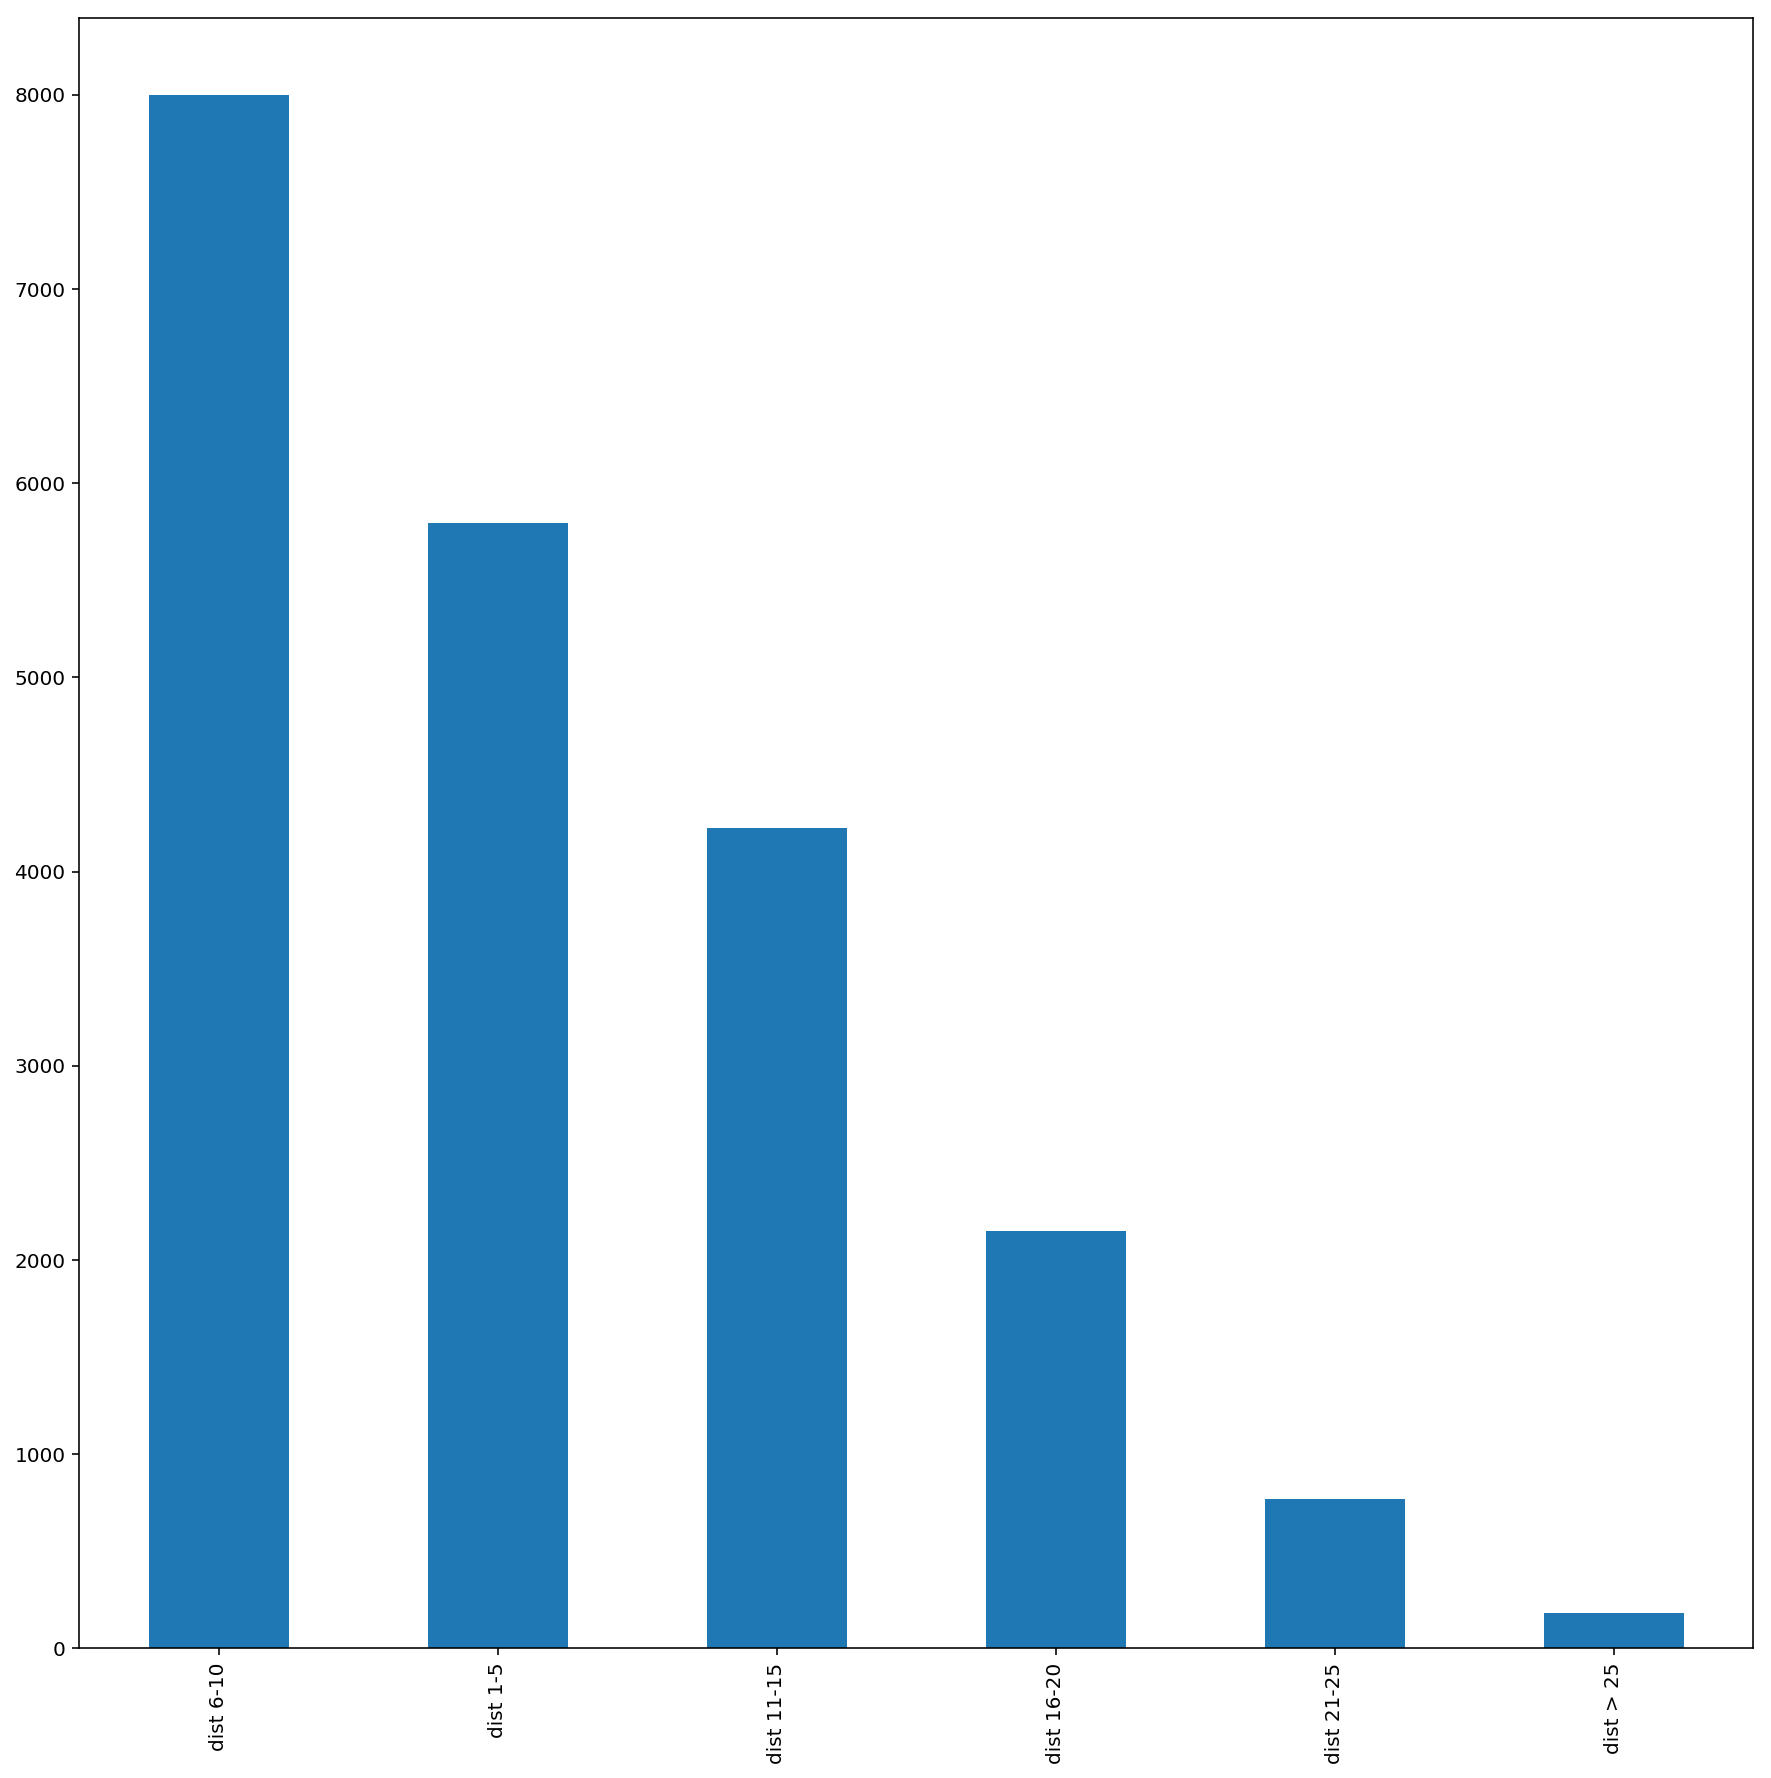

In [111]:
#plot of dist brackets

plt.figure(figsize = (15, 15))

all_t['dist bracket'].value_counts().plot(kind = 'bar')

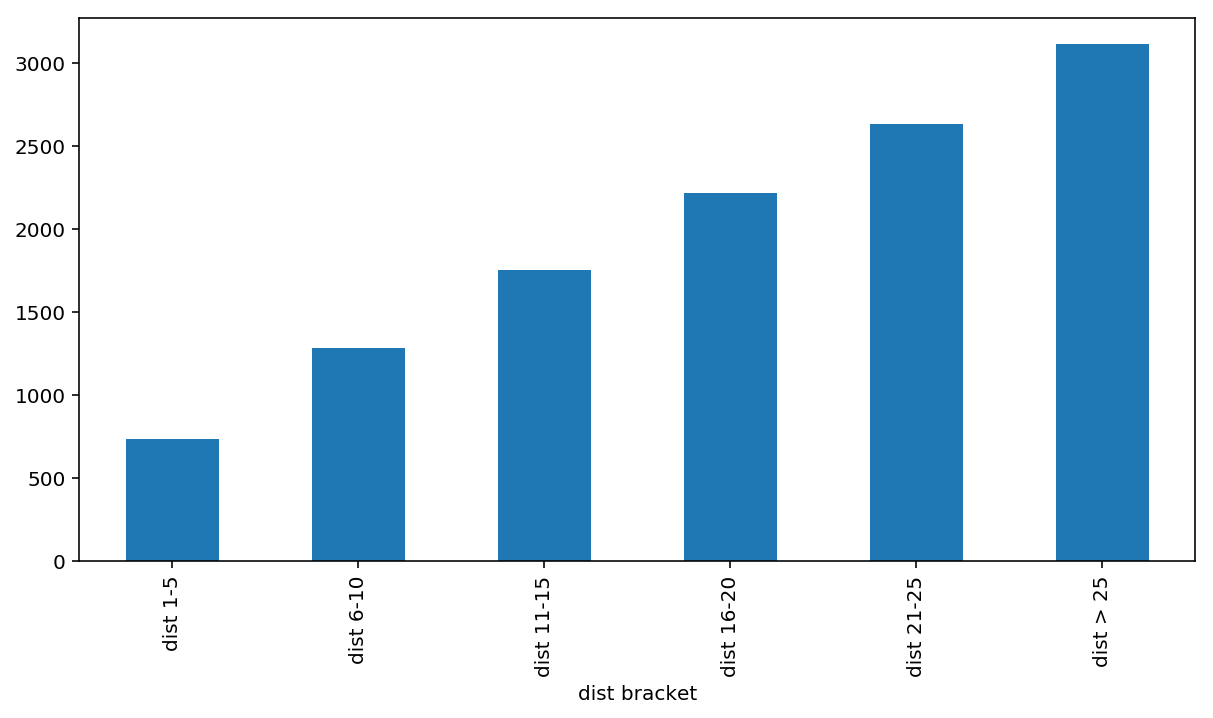

In [112]:
#Dist bracket Time from arrival range

plt.figure(figsize = (10, 5))

all_t_train.groupby(['dist bracket'])['Time from Pickup to Arrival'].median().sort_values()\
.plot(kind = 'bar')

Purpose of this distance bracket is to first have a feature that can distinguish Time of Arrival into categories(predictive feature) or range for values for that distance bracket value, to narrow the range of values the numeric Distance value needs to use to calculate it;s Time of Arrival.

As observed in the plot, this feature is predictive with a clear hierachy

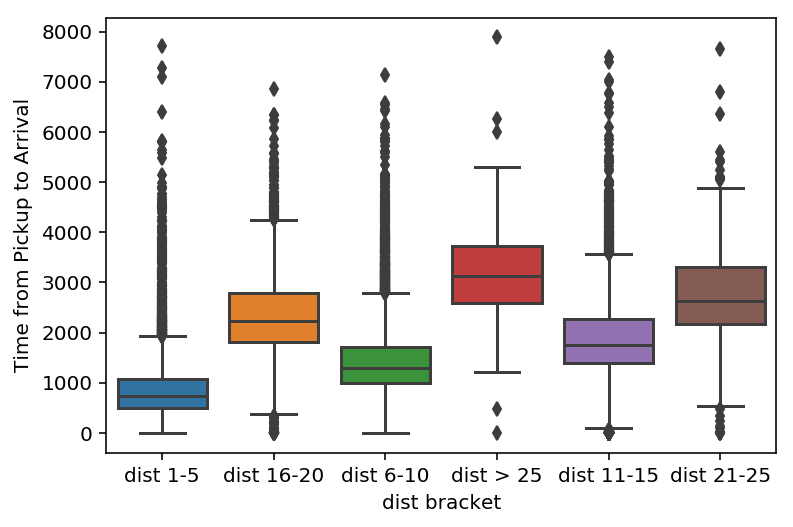

In [113]:
#visualize Platform boxplot to understand distribution 

sb.boxplot(data = all_t_train, x = 'dist bracket', y = 'Time from Pickup to Arrival')

Clear hierachy observed with lowest Time values in lowest distance bracket and highest distance values in highest distance brackets

# Visualization of route

In [ ]:
# pip install folium 

In [114]:
import folium
from folium.plugins import HeatMap

In [115]:
all_t.columns

Index(['Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Platform Type', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'identifier', 'No_Of_Orders',
       'Age', 'Average_Rating', 'No_of_Ratings',
       'confirmation_placement_delta', 'arrival pickup_confirmation delta',
       'pickup_arrival pickup_delta', 'pick time hour',
       'arrival pick time hour', 'latitude difference', 'longitude difference',
       'long lat diff', 'speed', 'week of month', 'hour bracket', 'order/Age',
       'Ratings/order', 'dist bracket'],
      dtype='object')

In [121]:
# Shows the geo-location given a dataframe.
CITY_COORDNIATE = [-1.16, 36.49]

def show_map(dataframe):
    # Create empty map zoomed in on Nariobi
    map = folium.Map(location= CITY_COORDNIATE, max_zoom = 20, tiles='Stamen Terrain')
    
    # marker for depot
    latlon = dataframe[['Destination Lat','Destination Long']].drop_duplicates()
    
    # Lat. and Long. of the dataframe
    for lat,lon in zip(latlon['Destination Lat'],latlon['Destination Long']):
        folium.Marker([lat,lon]).add_to(map)
    
    return map
    

In [123]:
heat_data = [[all_t['Destination Lat'], all_t['Destination Long']] for  row in all_t.iterrows()]

In [124]:
all_t['Destination Lat'].head(), all_t['Destination Long'].head()

(0   -1.300406
 1   -1.356237
 2   -1.273412
 3   -1.223520
 4   -1.300431
 Name: Destination Lat, dtype: float64, 0    36.829741
 1    36.904295
 2    36.818206
 3    36.802061
 4    36.752427
 Name: Destination Long, dtype: float64)

In [ ]:
# Pick-up and Destination Visualization

In [ ]:
# What is the most common pick-up and final destination 

I will do this during the week

------------------------

# Model Building 

- Model 1: ???

I will do this during the week

- Procedure

- Result

 - Observation 

# Future Work

- Augument the dataset by obtaining week class( Week1 - False, Week2- True, Week3 - False, Week4- False). DO EDA
- Augment the dataset by obtaining the hour of the day for `Arrival at Pickup - Time`,`Pickup - Time` ands `Arrival at Destination - Time`
- Compute the time difference between `Pickup - Time` ands `Arrival at Destination - Time`. DO EDA
- Look the the Uber Movement EDA notebook, which other information can you obtain from the Uber Movement for Nairobi.( Outiline them all, so we can discuss if they are really necessary).
- Since we have distance info already, verify the  how accuracy of this variable by comparing with the geo-location co-ordinates for few sample(10 random instances).

## Question 

- Useful Links and Discussion on Zindi forum

https://github.com/GIScience/openpoiservice
    
Hi, I've also watched Eniola's videos on ArcGIS, other than that, i have tried on my own to use ArcGIS with no success. What you can do though, is create a csv with all your pickup points, and another csv with all your destination points ( lat + long ) , and follow the video's instruction on how to load your points in the map. Then you can do analysis for dataset enrichment.


Video link https://youtu.be/8i6hQn5yY1s

https://www.openstreetmap.org/#map=2/69.6/-74.9

https://maps.openrouteservice.org/

https://developer.here.com/

OSRM (Open Street Routing Machine) library